![ZHVI Growth Predictions]('images/0_Zillow_Time_Series_Banner.png')

# Predicting Growth in Zillow Home Value Index
**Author:** Shawn Samuel

# Overview

Using ARIMA time series modeling, predictions were made and validated for median home prices for a desired set of zip codes. The predictions and historical analysis for each zip code were compared to select the top 5 zip codes to invest in based on potential for growth. The data is from the Zillow Home Value Index from 1996 to 2021. The hypothecial use case is to help first time home buyers to think like investors as the weigh the many factors in purchasing a home.

# Business Understanding

For this project, I am answering the question "What are the 5 best zip codes to invest in?" for a fictional real estate agency: ACME Realtors. To further clarify, I will be designing a tool for first-time home buyers (FTHB) to help them think like investors. Generally, first-time home buyers are overwhelmed by many factors when considering what home to buy. The investment potential of particualr areas may not be top of mind. Also, FTHB may not have access to high-performance data analytics and machine learning tools that are usually geared towards real estate investors. The use case for this tool will be for FTHB who have an idea (either due to preference or restriction) of a group of zipcodes they are interested in. Once this machine learning tool is built, it can be used as an added-value product ACME Realtors can provide their FTHB clients. For the FTHB, it will be a resource to enable them to think about their home purchase as an investment and maximize returns.

# Data Understanding

The data contains monthly ZHVI median pricing for 30,297 zip codes across America. This can be used to extract time series for individual zip codes. We are then able to use ARIMA modeling on the individual zip code time series to make predictions.

The ZHVI was obtained from Zillow's [Research Website](https://www.zillow.com/research/data). According to Zillow, "Zillow Home Value Index is a smoothed, seasonally adjusted measure of the typical home value and market changes across a given region and housing type. It reflects the typical value for homes in the 35th to 65th percentile range. Check out this [overview of ZHVI](https://www.zillow.com/research/zhvi-methodology-2019-highlights-26221) and a [deep-dive into its methodology](https://www.zillow.com/research/zhvi-methodology-2019-deep-26226/)." The following video also provides a greater understanding of the ZHVI.

In [1]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/rousqnB-G2c" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

For our purposes, index appreciation can be interpreted as the market’s total appreciation. In other words, the ZHVI appreciation can be viewed as the theoretical financial return that could be gained from buying all homes in a given subset (by geography and/or home type) in one period and selling them in the next period. Although this index includes homes of all sizes and types, including those that are not of interest to the client, it gives a general and powerful perspective on the price trend in a given area. 

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import warnings
import itertools

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose

from sklearn import metrics
import pmdarima as pm
from pmdarima import model_selection
from pmdarima.arima.stationarity import ADFTest

# Data Preprocessing

In [3]:
df_orig = pd.read_csv('data/original_zillow_data.csv')

In [4]:
df_orig.info() # compare to the original dataset provided by Flatiron

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [5]:
df_full = pd.read_csv('data/all_homes_zhvi_zip_may_12_2020.csv') # full and latest

In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30297 entries, 0 to 30296
Columns: 312 entries, RegionID to 2021-03-31
dtypes: float64(303), int64(3), object(6)
memory usage: 72.1+ MB


In [7]:
df_full.describe()

RegionID      SizeRank    RegionName    1996-01-31    1996-02-29  \
count   30297.000000  30297.000000  30297.000000  1.326700e+04  1.350700e+04   
mean    80470.145856  15909.646797  48863.298214  1.259902e+05  1.256241e+05   
std     25618.002684   9561.471905  27396.943207  8.309302e+04  8.291245e+04   
min     58001.000000      0.000000    501.000000  1.184100e+04  1.196800e+04   
25%     68873.000000   7665.000000  26032.000000  7.308050e+04  7.290550e+04   
50%     79245.000000  15440.000000  48438.000000  1.081590e+05  1.077060e+05   
75%     89235.000000  23954.000000  71722.000000  1.561755e+05  1.558505e+05   
max    753844.000000  35187.000000  99901.000000  1.975503e+06  1.970282e+06   

         1996-03-31    1996-04-30    1996-05-31    1996-06-30    1996-07-31  \
count  1.354600e+04  1.356600e+04  1.364900e+04  1.368300e+04  1.370500e+04   
mean   1.255627e+05  1.255894e+05  1.256560e+05  1.256838e+05  1.258181e+05   
std    8.282601e+04  8.260398e+04  8.244442e+04  8.229131e+04  8.216745e+04   
min    1.200900e+04  1.216000e+04  1.217100e+04  1.207700e+04  1.194200e+04   
25%    7.282300e+04  7.288925e+04  7.306100e+04  7.317300e+04  7.335400e+04   
50%    1.077510e+05  1.078530e+05  1.079030e+05  1.079300e+05  1.081660e+05   
75%    1.557655e+05  1.558382e+05  1.559310e+05  1.559395e+05  1.561290e+05   
max    1.948973e+06  1.915973e+06  1.862647e+06  1.809263e+06  1.755061e+06   

       ...    2020-06-30    2020-07-31    2020-08-31    2020-09-30  \
count  ...  3.029700e+04  3.029700e+04  3.029700e+04  3.029700e+04   
mean   ...  2.328612e+05  2.340105e+05  2.355519e+05  2.373374e+05   
std    ...  2.380375e+05  2.390434e+05  2.409116e+05  2.428401e+05   
min    ...  1.503200e+04  1.503100e+04  1.501900e+04  1.496400e+04   
25%    ...  1.091880e+05  1.094660e+05  1.098800e+05  1.102910e+05   
50%    ...  1.697610e+05  1.705000e+05  1.714330e+05  1.724890e+05   
75%    ...  2.721570e+05  2.738620e+05  2.757710e+05  2.781750e+05   
max    ...  6.785790e+06  6.781105e+06  6.837346e+06  6.824912e+06   

         2020-10-31    2020-11-30    2020-12-31    2021-01-31    2021-02-28  \
count  3.029700e+04  3.029700e+04  3.029700e+04  3.029700e+04  3.029700e+04   
mean   2.393152e+05  2.415465e+05  2.438366e+05  2.460684e+05  2.483831e+05   
std    2.449336e+05  2.468785e+05  2.489094e+05  2.505943e+05  2.522736e+05   
min    1.490900e+04  1.485300e+04  1.484400e+04  1.493900e+04  1.512900e+04   
25%    1.107550e+05  1.116350e+05  1.124270e+05  1.131370e+05  1.139270e+05   
50%    1.738820e+05  1.754150e+05  1.770630e+05  1.787090e+05  1.802460e+05   
75%    2.808650e+05  2.838520e+05  2.870180e+05  2.899870e+05  2.933250e+05   
max    6.856019e+06  6.834944e+06  6.861944e+06  6.815616e+06  6.782266e+06   

         2021-03-31  
count  3.029700e+04  
mean   2.508368e+05  
std    2.538671e+05  
min    1.526200e+04  
25%    1.147720e+05  
50%    1.818980e+05  
75%    2.968910e+05  
max    6.685364e+06  

[8 rows x 306 columns]

In [8]:
df_full.head()

RegionID  SizeRank  RegionName RegionType StateName State      City  \
0     61639         0       10025        Zip        NY    NY  New York   
1     84654         1       60657        Zip        IL    IL   Chicago   
2     61637         2       10023        Zip        NY    NY  New York   
3     91982         3       77494        Zip        TX    TX      Katy   
4     84616         4       60614        Zip        IL    IL   Chicago   

                              Metro       CountyName  1996-01-31  ...  \
0       New York-Newark-Jersey City  New York County    227153.0  ...   
1          Chicago-Naperville-Elgin      Cook County    212230.0  ...   
2       New York-Newark-Jersey City  New York County    200946.0  ...   
3  Houston-The Woodlands-Sugar Land    Harris County    201011.0  ...   
4          Chicago-Naperville-Elgin      Cook County    283626.0  ...   

   2020-06-30  2020-07-31  2020-08-31  2020-09-30  2020-10-31  2020-11-30  \
0   1091641.0   1087154.0   1085121.0   1086397.0   1082450.0   1078831.0   
1    497724.0    499152.0    501262.0    504040.0    506695.0    509141.0   
2    998619.0    998643.0   1001866.0   1013305.0   1016169.0   1014689.0   
3    339450.0    340170.0    341602.0    343191.0    345709.0    348800.0   
4    635967.0    637199.0    638751.0    641622.0    644350.0    647291.0   

   2020-12-31  2021-01-31  2021-02-28  2021-03-31  
0   1074640.0   1066881.0   1069011.0   1073214.0  
1    511452.0    513457.0    515542.0    516747.0  
2   1009092.0   1011561.0   1021442.0   1029770.0  
3    353185.0    357460.0    362468.0    367829.0  
4    650118.0    652578.0    655761.0    658233.0  

[5 rows x 312 columns]

In [9]:
cols = list(df_full.columns.values) #grab columns of dataset

In [10]:
cols

['RegionID',
 'SizeRank',
 'RegionName',
 'RegionType',
 'StateName',
 'State',
 'City',
 'Metro',
 'CountyName',
 '1996-01-31',
 '1996-02-29',
 '1996-03-31',
 '1996-04-30',
 '1996-05-31',
 '1996-06-30',
 '1996-07-31',
 '1996-08-31',
 '1996-09-30',
 '1996-10-31',
 '1996-11-30',
 '1996-12-31',
 '1997-01-31',
 '1997-02-28',
 '1997-03-31',
 '1997-04-30',
 '1997-05-31',
 '1997-06-30',
 '1997-07-31',
 '1997-08-31',
 '1997-09-30',
 '1997-10-31',
 '1997-11-30',
 '1997-12-31',
 '1998-01-31',
 '1998-02-28',
 '1998-03-31',
 '1998-04-30',
 '1998-05-31',
 '1998-06-30',
 '1998-07-31',
 '1998-08-31',
 '1998-09-30',
 '1998-10-31',
 '1998-11-30',
 '1998-12-31',
 '1999-01-31',
 '1999-02-28',
 '1999-03-31',
 '1999-04-30',
 '1999-05-31',
 '1999-06-30',
 '1999-07-31',
 '1999-08-31',
 '1999-09-30',
 '1999-10-31',
 '1999-11-30',
 '1999-12-31',
 '2000-01-31',
 '2000-02-29',
 '2000-03-31',
 '2000-04-30',
 '2000-05-31',
 '2000-06-30',
 '2000-07-31',
 '2000-08-31',
 '2000-09-30',
 '2000-10-31',
 '2000-11-30',
 

In [11]:
cols[9:] # obtain column names for just dates

['1996-01-31',
 '1996-02-29',
 '1996-03-31',
 '1996-04-30',
 '1996-05-31',
 '1996-06-30',
 '1996-07-31',
 '1996-08-31',
 '1996-09-30',
 '1996-10-31',
 '1996-11-30',
 '1996-12-31',
 '1997-01-31',
 '1997-02-28',
 '1997-03-31',
 '1997-04-30',
 '1997-05-31',
 '1997-06-30',
 '1997-07-31',
 '1997-08-31',
 '1997-09-30',
 '1997-10-31',
 '1997-11-30',
 '1997-12-31',
 '1998-01-31',
 '1998-02-28',
 '1998-03-31',
 '1998-04-30',
 '1998-05-31',
 '1998-06-30',
 '1998-07-31',
 '1998-08-31',
 '1998-09-30',
 '1998-10-31',
 '1998-11-30',
 '1998-12-31',
 '1999-01-31',
 '1999-02-28',
 '1999-03-31',
 '1999-04-30',
 '1999-05-31',
 '1999-06-30',
 '1999-07-31',
 '1999-08-31',
 '1999-09-30',
 '1999-10-31',
 '1999-11-30',
 '1999-12-31',
 '2000-01-31',
 '2000-02-29',
 '2000-03-31',
 '2000-04-30',
 '2000-05-31',
 '2000-06-30',
 '2000-07-31',
 '2000-08-31',
 '2000-09-30',
 '2000-10-31',
 '2000-11-30',
 '2000-12-31',
 '2001-01-31',
 '2001-02-28',
 '2001-03-31',
 '2001-04-30',
 '2001-05-31',
 '2001-06-30',
 '2001-07-

In [12]:
new_cols = ['RegionName'] + cols[9:] # concat zips with dates

In [13]:
df_zip = df_full[new_cols].rename(columns = {'RegionName':'Zip'}) # rename to "Zip"

In [14]:
df_zip.head()

Zip  1996-01-31  1996-02-29  1996-03-31  1996-04-30  1996-05-31  \
0  10025    227153.0    225738.0    225814.0    225790.0    226306.0   
1  60657    212230.0    212073.0    211661.0    211524.0    210956.0   
2  10023    200946.0    200989.0    201100.0    201816.0    202857.0   
3  77494    201011.0    201259.0    201062.0    199869.0    198728.0   
4  60614    283626.0    283367.0    282845.0    282702.0    282021.0   

   1996-06-30  1996-07-31  1996-08-31  1996-09-30  ...  2020-06-30  \
0    226934.0    226823.0    227619.0    227965.0  ...   1091641.0   
1    211141.0    210927.0    211539.0    212435.0  ...    497724.0   
2    203710.0    203994.0    204078.0    204399.0  ...    998619.0   
3    198060.0    198825.0    198512.0    197857.0  ...    339450.0   
4    282109.0    281613.0    282177.0    283263.0  ...    635967.0   

   2020-07-31  2020-08-31  2020-09-30  2020-10-31  2020-11-30  2020-12-31  \
0   1087154.0   1085121.0   1086397.0   1082450.0   1078831.0   1074640.0   
1    499152.0    501262.0    504040.0    506695.0    509141.0    511452.0   
2    998643.0   1001866.0   1013305.0   1016169.0   1014689.0   1009092.0   
3    340170.0    341602.0    343191.0    345709.0    348800.0    353185.0   
4    637199.0    638751.0    641622.0    644350.0    647291.0    650118.0   

   2021-01-31  2021-02-28  2021-03-31  
0   1066881.0   1069011.0   1073214.0  
1    513457.0    515542.0    516747.0  
2   1011561.0   1021442.0   1029770.0  
3    357460.0    362468.0    367829.0  
4    652578.0    655761.0    658233.0  

[5 rows x 304 columns]

In [15]:
new_cols = ['Zip'] # create list that will eventually contain zip + formatted dates

In [16]:
new_cols_dates = list(map(lambda x : x[:7], df_zip.columns[1:])) # format dates to be yyyy-mm

In [17]:
new_cols = new_cols + new_cols_dates

In [18]:
df_zip.columns = new_cols # reassign column names

In [19]:
df_zip.head() # sanity check

Zip   1996-01   1996-02   1996-03   1996-04   1996-05   1996-06  \
0  10025  227153.0  225738.0  225814.0  225790.0  226306.0  226934.0   
1  60657  212230.0  212073.0  211661.0  211524.0  210956.0  211141.0   
2  10023  200946.0  200989.0  201100.0  201816.0  202857.0  203710.0   
3  77494  201011.0  201259.0  201062.0  199869.0  198728.0  198060.0   
4  60614  283626.0  283367.0  282845.0  282702.0  282021.0  282109.0   

    1996-07   1996-08   1996-09  ...    2020-06    2020-07    2020-08  \
0  226823.0  227619.0  227965.0  ...  1091641.0  1087154.0  1085121.0   
1  210927.0  211539.0  212435.0  ...   497724.0   499152.0   501262.0   
2  203994.0  204078.0  204399.0  ...   998619.0   998643.0  1001866.0   
3  198825.0  198512.0  197857.0  ...   339450.0   340170.0   341602.0   
4  281613.0  282177.0  283263.0  ...   635967.0   637199.0   638751.0   

     2020-09    2020-10    2020-11    2020-12    2021-01    2021-02    2021-03  
0  1086397.0  1082450.0  1078831.0  1074640.0  1066881.0  1069011.0  1073214.0  
1   504040.0   506695.0   509141.0   511452.0   513457.0   515542.0   516747.0  
2  1013305.0  1016169.0  1014689.0  1009092.0  1011561.0  1021442.0  1029770.0  
3   343191.0   345709.0   348800.0   353185.0   357460.0   362468.0   367829.0  
4   641622.0   644350.0   647291.0   650118.0   652578.0   655761.0   658233.0  

[5 rows x 304 columns]

## Select Desired Zipcodes

In [20]:
# desired zipcodes - these are actual zipcodes that I as a 
# first-time home buyer am interested in

selected_zipcodes = [7601, 7603, 7607, 7621, 7624, 7626, 
                     7627, 7628, 7630, 7631, 7632, 7641, 
                     7646, 7649, 7661, 7662, 7666, 7670]

In [21]:
df_select = df_zip[df_zip.Zip.isin(selected_zipcodes)].reset_index(drop=True) # only select the above zips

In [22]:
df_select # sanity check

Zip   1996-01   1996-02   1996-03   1996-04   1996-05   1996-06  \
0   7601  128756.0  128416.0  128068.0  127534.0  127222.0  127320.0   
1   7666  185153.0  184639.0  184310.0  183452.0  182735.0  182050.0   
2   7631  177387.0  176659.0  176430.0  175836.0  175295.0  174756.0   
3   7621  170635.0  170240.0  170024.0  169420.0  168615.0  167813.0   
4   7646  188027.0  187576.0  187139.0  186274.0  185535.0  185251.0   
5   7628  187257.0  186730.0  186240.0  185353.0  184629.0  184181.0   
6   7670  330208.0  329549.0  329097.0  328430.0  328122.0  328250.0   
7   7661  212395.0  212400.0  212341.0  211938.0  211392.0  211150.0   
8   7607  171514.0  171132.0  170716.0  169762.0  169221.0  169101.0   
9   7626  272268.0  271748.0  270956.0  270080.0  268863.0  267744.0   
10  7624  281451.0  281054.0  281245.0  281713.0  282723.0  283742.0   
11  7603  161706.0  161466.0  161477.0  161440.0  161501.0  161401.0   
12  7649  250788.0  250133.0  249845.0  249144.0  248579.0  248085.0   
13  7630  230702.0  230306.0  230042.0  229223.0  228146.0  227093.0   
14  7662  168503.0  168467.0  168260.0  167937.0  167894.0  167936.0   
15  7632  473345.0  471827.0  472146.0  471316.0  470929.0  469257.0   
16  7627  329872.0  329545.0  330144.0  330977.0  332502.0  333221.0   
17  7641  280852.0  280083.0  279301.0  278041.0  276908.0  276588.0   

     1996-07   1996-08   1996-09  ...    2020-06    2020-07    2020-08  \
0   127504.0  127841.0  128194.0  ...   329643.0   332648.0   335839.0   
1   181712.0  181744.0  181896.0  ...   437079.0   440061.0   442415.0   
2   174316.0  174227.0  174461.0  ...   419603.0   422705.0   425261.0   
3   167035.0  166497.0  165971.0  ...   409775.0   412076.0   414080.0   
4   185160.0  184955.0  184953.0  ...   436116.0   438404.0   440183.0   
5   183754.0  183555.0  183413.0  ...   411976.0   414271.0   416105.0   
6   328614.0  328610.0  328303.0  ...   799070.0   802732.0   804793.0   
7   210587.0  210114.0  209459.0  ...   499472.0   501348.0   502195.0   
8   169567.0  170051.0  170663.0  ...   410332.0   413262.0   416683.0   
9   266425.0  265618.0  265499.0  ...   642334.0   643591.0   644842.0   
10  284636.0  285811.0  286969.0  ...   697126.0   700710.0   704170.0   
11  161055.0  160817.0  160395.0  ...   360081.0   362956.0   366471.0   
12  247820.0  247629.0  247466.0  ...   617816.0   620325.0   622277.0   
13  226462.0  226537.0  227034.0  ...   510567.0   513579.0   516392.0   
14  168092.0  168012.0  167881.0  ...   403221.0   406147.0   409268.0   
15  469279.0  470430.0  472410.0  ...  1162978.0  1162888.0  1160695.0   
16  334100.0  335001.0  335630.0  ...   752173.0   754278.0   757108.0   
17  277014.0  278656.0  279983.0  ...   657813.0   661195.0   664168.0   

      2020-09    2020-10    2020-11    2020-12    2021-01    2021-02  \
0    339361.0   343322.0   347449.0   351585.0   356181.0   360196.0   
1    445916.0   449746.0   454232.0   458906.0   463834.0   467894.0   
2    428049.0   431426.0   435666.0   440754.0   445700.0   449855.0   
3    417186.0   420934.0   425532.0   430781.0   435920.0   440344.0   
4    443324.0   446772.0   451419.0   455958.0   461087.0   465364.0   
5    419218.0   422453.0   427076.0   431847.0   437656.0   442289.0   
6    807525.0   812163.0   819283.0   827017.0   834992.0   840549.0   
7    505267.0   509464.0   515808.0   521824.0   528193.0   533400.0   
8    421039.0   426846.0   432812.0   439036.0   445209.0   449762.0   
9    648118.0   652838.0   658771.0   665537.0   673643.0   681370.0   
10   709898.0   715182.0   721510.0   728055.0   737261.0   747326.0   
11   371302.0   377027.0   384074.0   391727.0   399745.0   406390.0   
12   624520.0   628789.0   634324.0   640712.0   647590.0   653745.0   
13   519992.0   524394.0   530145.0   536687.0   544035.0   550566.0   
14   413164.0   417963.0   423265.0   428595.0   434233.0   438781.0   
15  1164329.0  1166816.0  1171480.0  1176808.0  1184676.0  1189615.0   
16   

In [23]:
# rename to "df" for ease of use

df = df_select.set_index('Zip') # set zips as index (this is for the coming transformation to work)

In [24]:
df.index.name = None # no need for index to be named after transformation

In [25]:
df = df.T # switch columns and rows

In [26]:
df.index = pd.to_datetime(df.index) # turn dates into datetime objects

In [27]:
df #sanity check = success

7601      7666      7631      7621      7646      7628  \
1996-01-01  128756.0  185153.0  177387.0  170635.0  188027.0  187257.0   
1996-02-01  128416.0  184639.0  176659.0  170240.0  187576.0  186730.0   
1996-03-01  128068.0  184310.0  176430.0  170024.0  187139.0  186240.0   
1996-04-01  127534.0  183452.0  175836.0  169420.0  186274.0  185353.0   
1996-05-01  127222.0  182735.0  175295.0  168615.0  185535.0  184629.0   
...              ...       ...       ...       ...       ...       ...   
2020-11-01  347449.0  454232.0  435666.0  425532.0  451419.0  427076.0   
2020-12-01  351585.0  458906.0  440754.0  430781.0  455958.0  431847.0   
2021-01-01  356181.0  463834.0  445700.0  435920.0  461087.0  437656.0   
2021-02-01  360196.0  467894.0  449855.0  440344.0  465364.0  442289.0   
2021-03-01  364518.0  472481.0  454346.0  444875.0  469964.0  447569.0   

                7670      7661      7607      7626      7624      7603  \
1996-01-01  330208.0  212395.0  171514.0  272268.0  281451.0  161706.0   
1996-02-01  329549.0  212400.0  171132.0  271748.0  281054.0  161466.0   
1996-03-01  329097.0  212341.0  170716.0  270956.0  281245.0  161477.0   
1996-04-01  328430.0  211938.0  169762.0  270080.0  281713.0  161440.0   
1996-05-01  328122.0  211392.0  169221.0  268863.0  282723.0  161501.0   
...              ...       ...       ...       ...       ...       ...   
2020-11-01  819283.0  515808.0  432812.0  658771.0  721510.0  384074.0   
2020-12-01  827017.0  521824.0  439036.0  665537.0  728055.0  391727.0   
2021-01-01  834992.0  528193.0  445209.0  673643.0  737261.0  399745.0   
2021-02-01  840549.0  533400.0  449762.0  681370.0  747326.0  406390.0   
2021-03-01  847160.0  539417.0  454622.0  689277.0  758025.0  413404.0   

                7649      7630      7662       7632      7627      7641  
1996-01-01  250788.0  230702.0  168503.0   473345.0  329872.0  280852.0  
1996-02-01  250133.0  230306.0  168467.0   471827.0  329545.0  280083.0  
1996-03-01  249845.0  230042.0  168260.0   472146.0  330144.0  279301.0  
1996-04-01  249144.0  229223.0  167937.0   471316.0  330977.0  278041.0  
1996-05-01  248579.0  228146.0  167894.0   470929.0  332502.0  276908.0  
...              ...       ...       ...        ...       ...       ...  
2020-11-01  634324.0  530145.0  423265.0  1171480.0  770038.0  681575.0  
2020-12-01  640712.0  536687.0  428595.0  1176808.0  777833.0  689698.0  
2021-01-01  647590.0  544035.0  434233.0  1184676.0  787929.0  698755.0  
2021-02-01  653745.0  550566.0  438781.0  1189615.0  797676.0  707204.0  
2021-03-01  660448.0  557298.0  443817.0  1195279.0  807890.0  716426.0  

[303 rows x 18 columns]

## Potential Zipcode Expansion

In [28]:
# select even more zips I'd be interested in case we want to expand search

df_more= df_full[(df_full['State'] == 'NJ') & 
                 (df_full['Metro'] == 'New York-Newark-Jersey City') & 
                 (df_full['CountyName'] == 'Bergen County')]

In [29]:
df_more # 65 zip codes in expanded set

RegionID  SizeRank  RegionName RegionType StateName State  \
893       60540       900        7024        Zip        NJ    NJ   
946       60714       955        7601        Zip        NJ    NJ   
2587      60750      2610        7666        Zip        NJ    NJ   
3488      60656      3525        7410        Zip        NJ    NJ   
4210      60729      4257        7631        Zip        NJ    NJ   
...         ...       ...         ...        ...       ...   ...   
15085     60664     15372        7423        Zip        NJ    NJ   
16691     60732     17078        7641        Zip        NJ    NJ   
17167     60583     17598        7074        Zip        NJ    NJ   
17934     60719     18446        7606        Zip        NJ    NJ   
19117     60722     19799        7620        Zip        NJ    NJ   

                   City                        Metro     CountyName  \
893            Fort Lee  New York-Newark-Jersey City  Bergen County   
946          Hackensack  New York-Newark-Jersey City  Bergen County   
2587            Teaneck  New York-Newark-Jersey City  Bergen County   
3488          Fair Lawn  New York-Newark-Jersey City  Bergen County   
4210          Englewood  New York-Newark-Jersey City  Bergen County   
...                 ...                          ...            ...   
15085         Ho Ho Kus  New York-Newark-Jersey City  Bergen County   
16691           Haworth  New York-Newark-Jersey City  Bergen County   
17167         Moonachie  New York-Newark-Jersey City  Bergen County   
17934  South Hackensack  New York-Newark-Jersey City  Bergen County   
19117            Alpine  New York-Newark-Jersey City  Bergen County   

       1996-01-31  ...  2020-06-30  2020-07-31  2020-08-31  2020-09-30  \
893      218351.0  ...    565425.0    565311.0    564520.0    564995.0   
946      128756.0  ...    329643.0    332648.0    335839.0    339361.0   
2587     185153.0  ...    437079.0    440061.0    442415.0    445916.0   
3488     190749.0  ...    452153.0    454304.0    456054.0    459243.0   
4210     177387.0  ...    419603.0    422705.0    425261.0    428049.0   
...           ...  ...         ...         ...         ...         ...   
15085    291690.0  ...    772199.0    773821.0    776661.0    781714.0   
16691    280852.0  ...    657813.0    661195.0    664168.0    668487.0   
17167    205695.0  ...    426009.0    429167.0    432981.0    436577.0   
17934    189484.0  ...    441535.0    445411.0    450110.0    455584.0   
19117   1018702.0  ...   2303571.0   2323996.0   2334557.0   2341255.0   

       2020-10-31  2020-11-30  2020-12-31  2021-01-31  2021-02-28  2021-03-31  
893      567528.0    570652.0    574066.0    577843.0    581098.0    583829.0  
946      343322.0    347449.0    351585.0    356181.0    360196.0    364518.0  
2587     449746.0    454232.0    458906.0    463834.0    467894.0    472481.0  
3488     462912.0    467800.0    472839.0    478137.0    482275.0    486839.0  
4210     431426.0    435666.0    440754.0    445700.0    449855.0    454346.0  
...           ...         ...         ...         ...         ...         ...  
15085    786443.0    792669.0    800020.0    809061.0    816404.0    824128.0  
16691    673998.0    681575.0    689698.0    698755.0    707204.0    716426.0  
17167    441504.0    445802.0    450847.0    456149.0    461318.0    466219.0  
17934    461909.0    468344.0    474549.0    480961.0    486375.0    492438.0  
19117   2350396.0   2368406.0   2381739.0   2391895.0   2396777.0   2412176.0  

[65 rows x 312 columns]

# EDA and Visualization

## Plot all selected zips

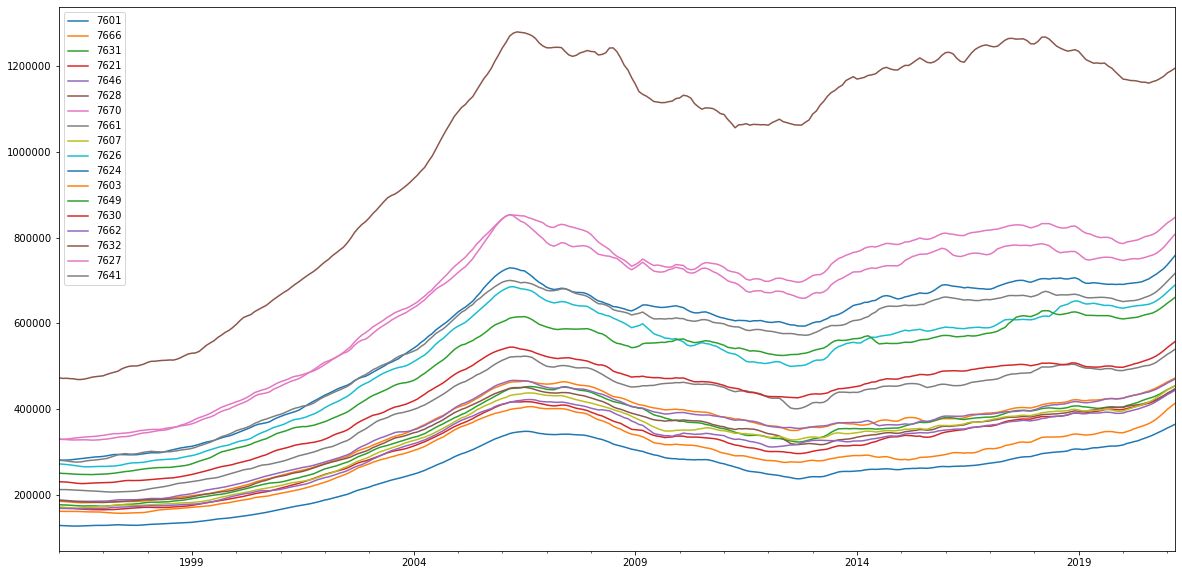

In [30]:
df.plot(figsize = [20,10])

## Account for Market Crash

In [31]:
df['mean'] = df.mean(axis=1) # create a trend line that reflects the mean

In [32]:
df_crash = df[(df.index > '2007-12-01')] # create a separate df after the housing crash

In [33]:
df_crash[df_crash['mean'] == df_crash['mean'].min()] # find the mean min date 

7601      7666      7631      7621      7646      7628  \
2012-09-01  237429.0  350673.0  323396.0  296350.0  355155.0  317337.0   

                7670      7661      7607      7626      7624      7603  \
2012-09-01  696166.0  401037.0  328995.0  500805.0  594185.0  276281.0   

                7649      7630      7662       7632      7627      7641  \
2012-09-01  527868.0  426588.0  318106.0  1062934.0  660976.0  573717.0   

                     mean  
2012-09-01  458222.111111

In [34]:
df = df[(df.index >= '2012-09-01')] # we will use the upward trend after this point

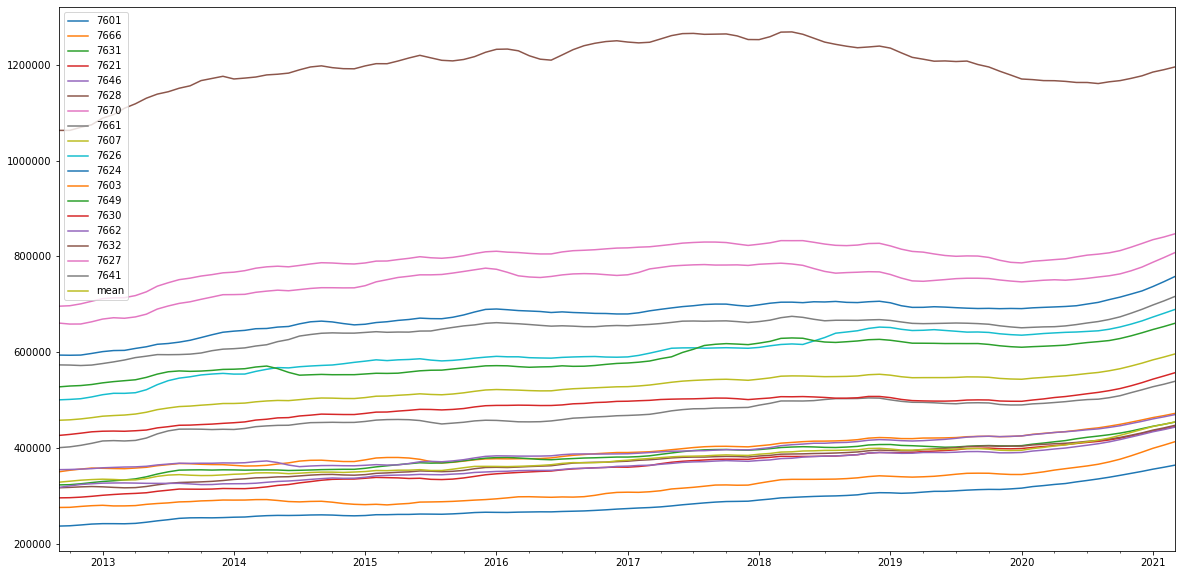

In [35]:
df.plot(figsize = [20,10]) # visualize post-crash recovery trend

## Select One Zip

In [36]:
new_milford_7646 = df[7646]
ts = new_milford_7646

## Stationary Check Function

In [37]:
def stationarity_check(TS):
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=12, center=False).mean()
    roll_std = TS.rolling(window=12, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS.dropna())
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(10,5))
    plt.plot(TS, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling 12mo Mean')
    plt.plot(roll_std, color='black', label = 'Rolling 12mo Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    fig.tight_layout()
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

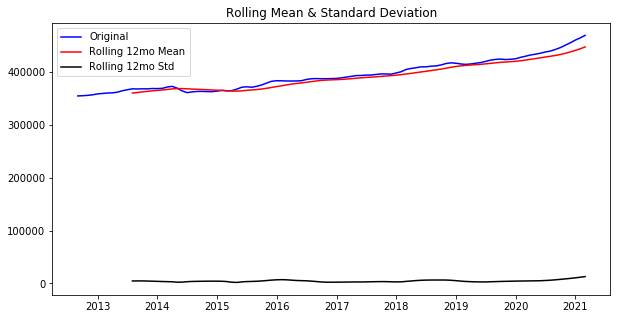

Results of Dickey-Fuller Test: 

Test Statistic                  2.221301
p-value                         0.998900
#Lags Used                     13.000000
Number of Observations Used    89.000000
Critical Value (1%)            -3.506057
Critical Value (5%)            -2.894607
Critical Value (10%)           -2.584410
dtype: float64


In [38]:
stationarity_check(ts)

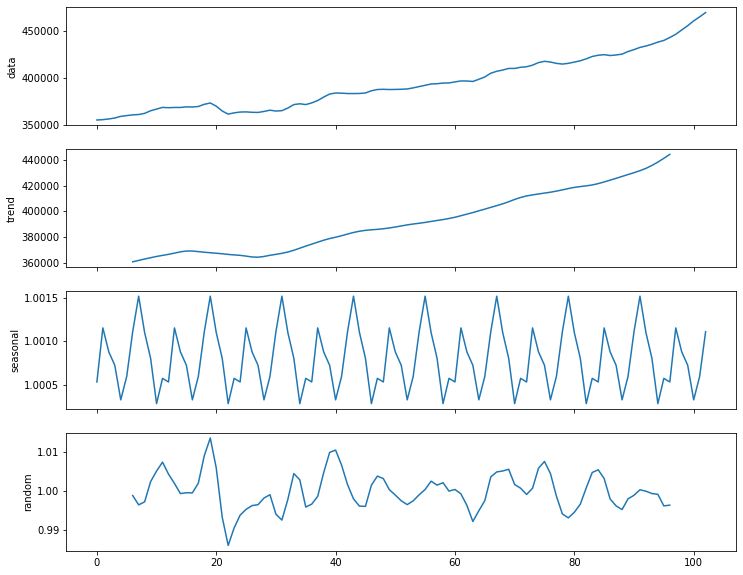

In [39]:
# Print decomposition
decomposed = decompose(ts.values, 'multiplicative', m=12)
decomposed_plot(decomposed, figure_kwargs={'figsize': (12, 10)})
plt.show()

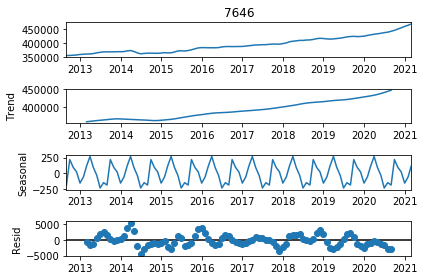

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose #for comparison
decomposition = seasonal_decompose(ts)
decomposition.plot();

## Stationary Checks

### Difference

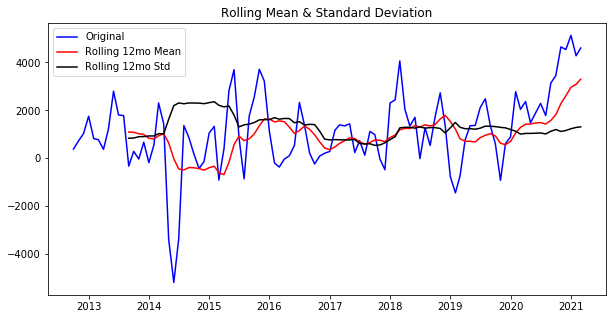

Results of Dickey-Fuller Test: 

Test Statistic                 -1.084616
p-value                         0.721168
#Lags Used                     13.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64


In [41]:
# Now let's check the difference
ts_diff = ts.diff()
stationarity_check(ts_diff)

### Log Transform

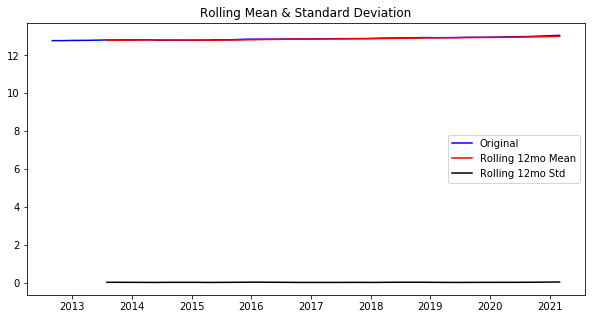

Results of Dickey-Fuller Test: 

Test Statistic                  2.837419
p-value                         1.000000
#Lags Used                     11.000000
Number of Observations Used    91.000000
Critical Value (1%)            -3.504343
Critical Value (5%)            -2.893866
Critical Value (10%)           -2.584015
dtype: float64


In [42]:
# log transform
ts_log = np.log1p(ts)
stationarity_check(ts_log)

### Square Root

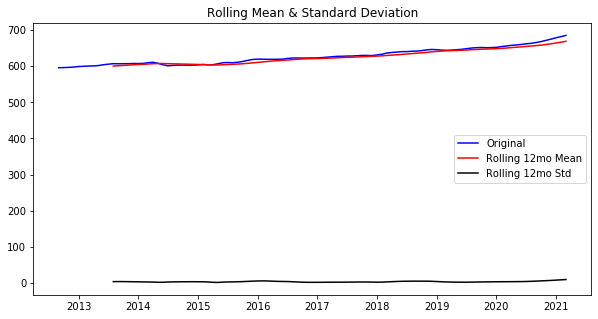

Results of Dickey-Fuller Test: 

Test Statistic                  2.198399
p-value                         0.998881
#Lags Used                     13.000000
Number of Observations Used    89.000000
Critical Value (1%)            -3.506057
Critical Value (5%)            -2.894607
Critical Value (10%)           -2.584410
dtype: float64


In [43]:
# square root transform
ts_sqrt = np.sqrt(ts)
stationarity_check(ts_sqrt)

### Log of Square Root

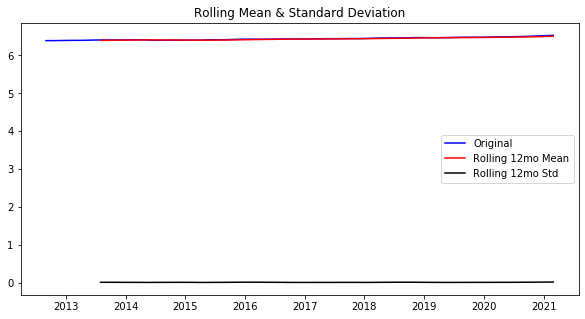

Results of Dickey-Fuller Test: 

Test Statistic                  2.837561
p-value                         1.000000
#Lags Used                     11.000000
Number of Observations Used    91.000000
Critical Value (1%)            -3.504343
Critical Value (5%)            -2.893866
Critical Value (10%)           -2.584015
dtype: float64


In [44]:
# square root transform
ts_sqrt_log = np.log1p(ts_sqrt)
stationarity_check(ts_sqrt_log)

### Log minus Rolling Mean

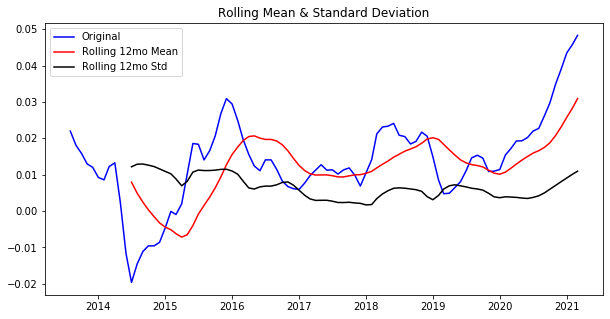

Results of Dickey-Fuller Test: 

Test Statistic                 -0.720784
p-value                         0.841292
#Lags Used                     11.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64


In [45]:
# Subtracting the rolling mean from the log
ts_roll_mean = ts_log.rolling(window=12).mean()
ts_log_minus_roll_mean = ts_log - ts_roll_mean
stationarity_check(ts_log_minus_roll_mean)

### Weighted MA of Log

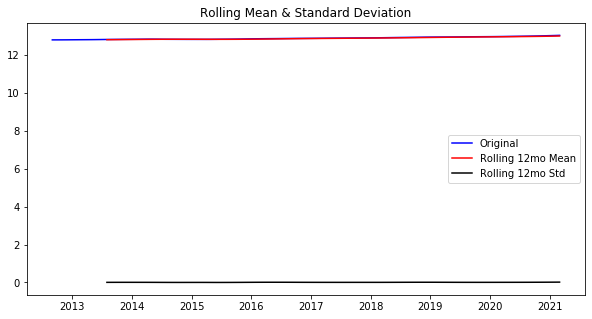

Results of Dickey-Fuller Test: 

Test Statistic                  2.694807
p-value                         0.999087
#Lags Used                     12.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


In [46]:
# Weighted Moving Average of log transformed data
exp_roll_mean = np.log(ts).ewm(halflife=4).mean()
stationarity_check(exp_roll_mean)

### Log minus Weighted MA of Log

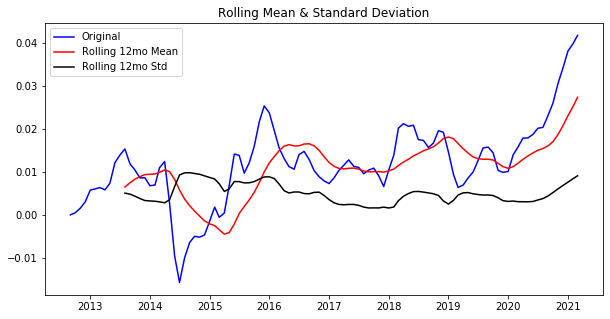

Results of Dickey-Fuller Test: 

Test Statistic                 -0.751187
p-value                         0.833042
#Lags Used                     13.000000
Number of Observations Used    89.000000
Critical Value (1%)            -3.506057
Critical Value (5%)            -2.894607
Critical Value (10%)           -2.584410
dtype: float64


In [47]:
# Subtract the exponential weighted rolling mean from the logged data
log_minus_exp_roll_mean = ts_log - exp_roll_mean
stationarity_check(log_minus_exp_roll_mean)

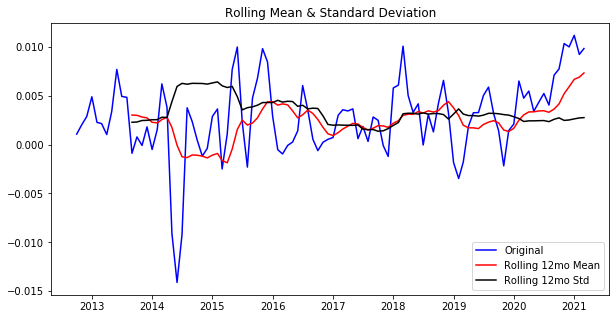

Results of Dickey-Fuller Test: 

Test Statistic                 -1.665975
p-value                         0.448723
#Lags Used                     13.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64


In [48]:
# first difference of log
log_diff = ts_log.diff()
stationarity_check(log_diff)

## Correlation Plots

### ACF

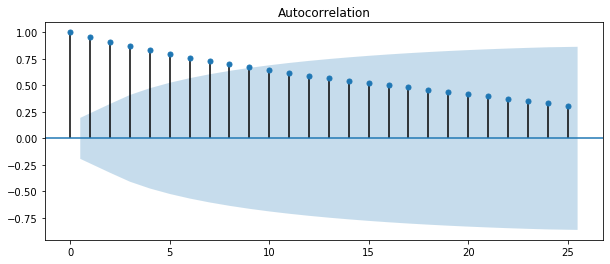

In [49]:
# Plot the ACF
fig, ax = plt.subplots(figsize=(10,4))
plot_acf(ts, ax=ax, lags=25);

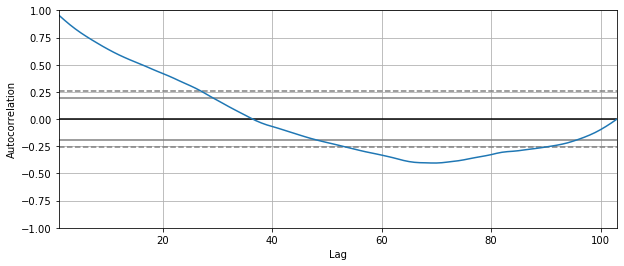

In [50]:
plt.figure(figsize=(10, 4))
pd.plotting.autocorrelation_plot(ts)

### PCF

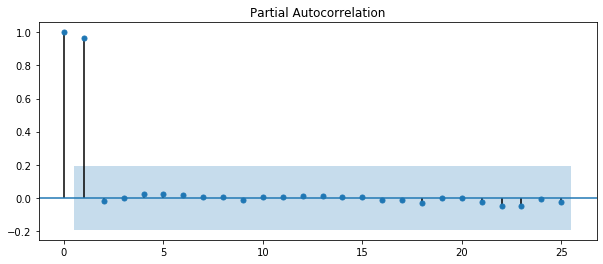

In [51]:
# Plot the PACF
fig, ax = plt.subplots(figsize=(10,4))
plot_pacf(ts, ax=ax, lags=25);

# ARIMA Modeling

## Import Custom Metrics & Function

In [52]:
from sjs_utilities import arima_eval

## Train-Test Splits

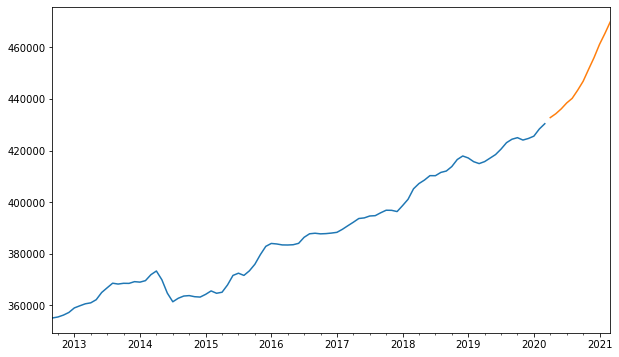

In [53]:
train_12mo, test_12mo = model_selection.train_test_split(ts, test_size=12)
plt.figure(figsize=(10,6))
train_12mo.plot()
test_12mo.plot()

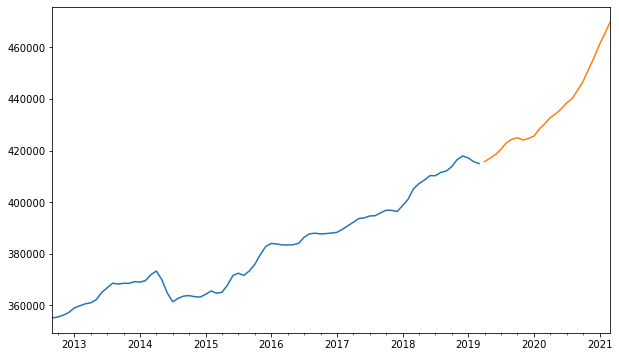

In [54]:
train_24mo, test_24mo = model_selection.train_test_split(ts, test_size=24)
plt.figure(figsize=(10,6))
train_24mo.plot()
test_24mo.plot()

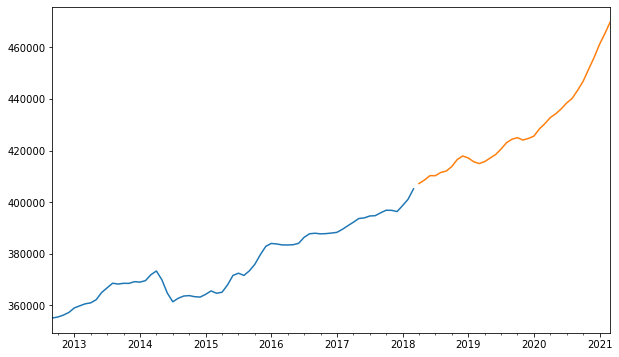

In [55]:
train_36mo, test_36mo = model_selection.train_test_split(ts, test_size=36)
plt.figure(figsize=(10,6))
train_36mo.plot()
test_36mo.plot()

## First Run of Auto ARIMA

### 12 Month Test Set

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1590.069, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1567.725, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1588.136, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1583.542, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1592.041, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1571.725, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.121 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -781.862
Date:                Sun, 30 May 2021   AIC                           1567.725
Time:                        18:02:47   BIC                           1572.724
Sample:                             0   HQIC                          1569.741
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    835.7778    166.945      5.006      0.000     508.572    1162.983
sigma2      2.057e+06   2.08e+05      9.897      0.000    1.65e+06    2.46e+06
===================================================================================
Ljung-Box (Q):                      134.70   Jarque-Bera (JB):                55.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -0.98
Prob(H) (two-sided):                  0.10   Kurtosis:                         6.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

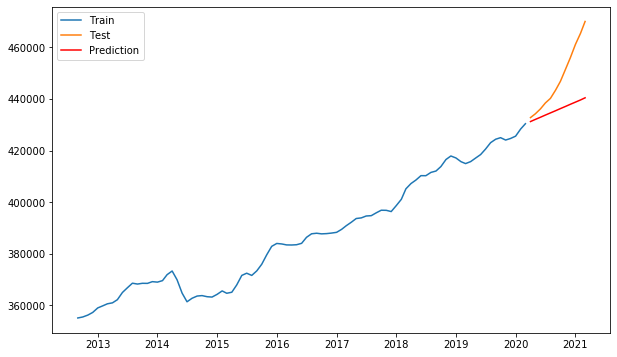

Model Explained Variance      r^2         MAE        RMSE ARIMA Order  \
0  12mo             41.06%  -59.07%  $12,155.19  $15,320.44   (0, 1, 0)   

  Seasonal Order      AIC  
0   (0, 0, 0, 0)  1567.72

In [56]:
arima = pm.auto_arima(train_12mo, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100)
arima_eval('12mo', ts, train_12mo, test_12mo, arima);

### 24 Month Test Set

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1383.756, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1364.272, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1380.957, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1378.840, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1380.776, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1368.261, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.322 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   79
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -680.136
Date:                Sun, 30 May 2021   AIC                           1364.272
Time:                        18:02:47   BIC                           1368.985
Sample:                             0   HQIC                          1366.159
                                 - 79                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    766.3846    183.803      4.170      0.000     406.137    1126.632
sigma2      2.195e+06   2.41e+05      9.112      0.000    1.72e+06    2.67e+06
===================================================================================
Ljung-Box (Q):                      126.21   Jarque-Bera (JB):                42.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                            -0.92
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

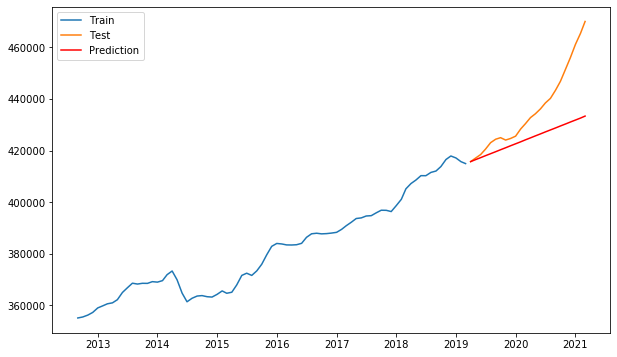

Model Explained Variance      r^2         MAE        RMSE ARIMA Order  \
1  24mo             54.17%    3.08%  $11,013.03  $15,168.44   (0, 1, 0)   
0  12mo             41.06%  -59.07%  $12,155.19  $15,320.44   (0, 1, 0)   

  Seasonal Order      AIC  
1   (0, 0, 0, 0)  1364.27  
0   (0, 0, 0, 0)  1567.72

In [57]:
arima = pm.auto_arima(train_24mo, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100)
arima_eval('24mo', ts, train_24mo, test_24mo, arima);

### 36 Month Test Set

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1176.733, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1158.520, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1171.307, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1171.916, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1171.151, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1172.496, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.448 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   67
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -577.260
Date:                Sun, 30 May 2021   AIC                           1158.520
Time:                        18:02:49   BIC                           1162.900
Sample:                             0   HQIC                          1160.251
                                 - 67                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    757.7121    206.163      3.675      0.000     353.640    1161.784
sigma2      2.315e+06   2.72e+05      8.509      0.000    1.78e+06    2.85e+06
===================================================================================
Ljung-Box (Q):                       99.78   Jarque-Bera (JB):                40.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.96
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

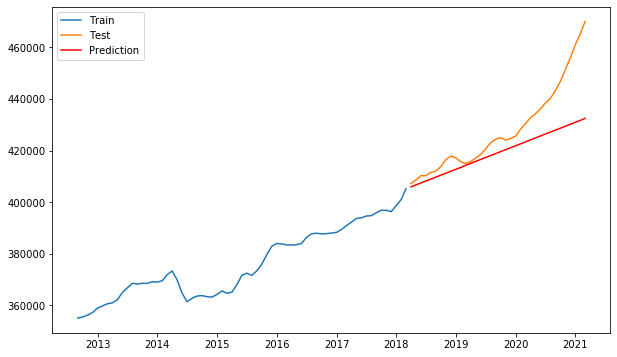

Model Explained Variance      r^2         MAE        RMSE ARIMA Order  \
2  36mo             66.66%   38.33%   $8,827.77  $13,023.85   (0, 1, 0)   
1  24mo             54.17%    3.08%  $11,013.03  $15,168.44   (0, 1, 0)   
0  12mo             41.06%  -59.07%  $12,155.19  $15,320.44   (0, 1, 0)   

  Seasonal Order      AIC  
2   (0, 0, 0, 0)  1158.52  
1   (0, 0, 0, 0)  1364.27  
0   (0, 0, 0, 0)  1567.72

In [58]:
arima = pm.auto_arima(train_36mo, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100)
arima_eval('36mo', ts, train_36mo, test_36mo, arima);

## 2nd Difference

In [59]:
# Stationary Check
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(ts)
print(f"P-Value: {p_val:.4f}, so should you difference the data? {should_diff}")

P-Value: 0.9900, so should you difference the data? True


In [60]:
# Estimate the number of differences using an ADF test:
from pmdarima.arima.utils import ndiffs
n_adf = ndiffs(ts, test='adf')
n_adf

2

In [61]:
ts_diff_2 = ts.diff(periods=2).dropna()

In [62]:
train_2diff_12mo, test_2diff_12mo = model_selection.train_test_split(ts_diff_2, test_size=12)
train_2diff_24mo, test_2diff_24mo = model_selection.train_test_split(ts_diff_2, test_size=24)
train_2diff_36mo, test_2diff_36mo = model_selection.train_test_split(ts_diff_2, test_size=36)

### 12 Month Test Set

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1515.756, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1651.617, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1599.260, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1681.508, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1521.229, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1512.833, Time=0.54 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1549.457, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1514.702, Time=0.48 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1524.446, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1515.925, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1525.708, Time=0.11 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 2.551 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   89
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -751.417
Date:                Sun, 30 May 2021   AIC                           1512.833
Time:                        18:02:53   BIC                           1525.276
Sample:                             0   HQIC                          1517.848
                                 - 89                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1061.6787    281.348      3.774      0.000     510.246    1613.111
ar.L1          0.8170      0.076     10.814      0.000       0.669       0.965
ar.L2         -0.4579      0.089     -5.132      0.000      -0.633      -0.283
ma.L1          0.9057      0.064     14.210      0.000       0.781       1.031
sigma2      1.205e+06   1.52e+05      7.930      0.000    9.07e+05     1.5e+06
===================================================================================
Ljung-Box (Q):                       62.92   Jarque-Bera (JB):                 4.84
Prob(Q):                              0.01   Prob(JB):                         0.09
Heteroskedasticity (H):               0.72   Skew:                            -0.16
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

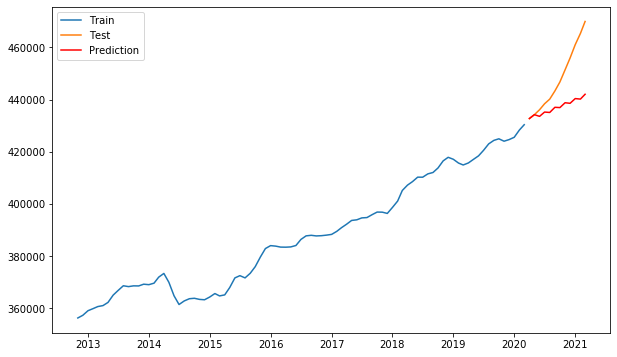

Model Explained Variance      r^2         MAE        RMSE  \
3  2nd Diff 12mo             40.30%  -40.10%  $10,892.44  $14,378.12   
2           36mo             66.66%   38.33%   $8,827.77  $13,023.85   
1           24mo             54.17%    3.08%  $11,013.03  $15,168.44   
0           12mo             41.06%  -59.07%  $12,155.19  $15,320.44   

  ARIMA Order Seasonal Order      AIC  
3   (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2   (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1   (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0   (0, 1, 0)   (0, 0, 0, 0)  1567.72

In [63]:
arima = pm.auto_arima(train_2diff_12mo, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100)
arima_eval('2nd Diff 12mo', ts, train_2diff_12mo, test_2diff_12mo, arima, periods=2);

### 24 Month Test Set

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1318.215, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1434.534, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1389.408, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1455.857, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1322.566, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1316.281, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1349.787, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1318.139, Time=0.23 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1326.363, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1319.136, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1324.834, Time=0.10 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 1.302 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   77
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -653.141
Date:                Sun, 30 May 2021   AIC                           1316.281
Time:                        18:02:54   BIC                           1328.000
Sample:                             0   HQIC                          1320.969
                                 - 77                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    988.7687    313.741      3.152      0.002     373.847    1603.690
ar.L1          0.7934      0.082      9.704      0.000       0.633       0.954
ar.L2         -0.4352      0.096     -4.511      0.000      -0.624      -0.246
ma.L1          0.9456      0.051     18.552      0.000       0.846       1.045
sigma2      1.287e+06   1.78e+05      7.246      0.000    9.39e+05    1.63e+06
===================================================================================
Ljung-Box (Q):                       62.14   Jarque-Bera (JB):                 3.28
Prob(Q):                              0.01   Prob(JB):                         0.19
Heteroskedasticity (H):               0.71   Skew:                            -0.08
Prob(H) (two-sided):                  0.39   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

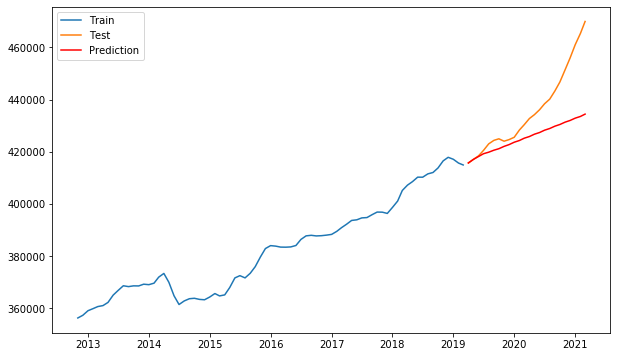

Model Explained Variance      r^2         MAE        RMSE  \
4  2nd Diff 24mo             54.80%   12.25%  $10,050.39  $14,432.66   
3  2nd Diff 12mo             40.30%  -40.10%  $10,892.44  $14,378.12   
2           36mo             66.66%   38.33%   $8,827.77  $13,023.85   
1           24mo             54.17%    3.08%  $11,013.03  $15,168.44   
0           12mo             41.06%  -59.07%  $12,155.19  $15,320.44   

  ARIMA Order Seasonal Order      AIC  
4   (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3   (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2   (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1   (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0   (0, 1, 0)   (0, 0, 0, 0)  1567.72

In [64]:
arima = pm.auto_arima(train_2diff_24mo, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100)
arima_eval('2nd Diff 24mo', ts, train_2diff_24mo, test_2diff_24mo, arima, periods=2);

### 36 Month Test Set

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1114.064, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1213.166, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1177.947, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1228.611, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1116.964, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1112.344, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1127.681, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1144.278, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1111.695, Time=0.24 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1120.512, Time=0.03 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1113.407, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1113.205, Time=0.30 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=1116.475, Time=0.04 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   65
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -549.847
Date:                Sun, 30 May 2021   AIC                           1111.695
Time:                        18:02:56   BIC                           1124.741
Sample:                             0   HQIC                          1116.842
                                 - 65                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    754.5945    331.098      2.279      0.023     105.654    1403.535
ar.L1          1.0235      0.166      6.165      0.000       0.698       1.349
ar.L2         -0.7512      0.227     -3.310      0.001      -1.196      -0.306
ar.L3          0.2412      0.173      1.394      0.163      -0.098       0.580
ma.L1          0.8105      0.133      6.097      0.000       0.550       1.071
sigma2      1.223e+06   2.33e+05      5.246      0.000    7.66e+05    1.68e+06
===================================================================================
Ljung-Box (Q):                       53.90   Jarque-Bera (JB):                 1.27
Prob(Q):                              0.07   Prob(JB):                         0.53
Heteroskedasticity (H):               0.49   Skew:                             0.05
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

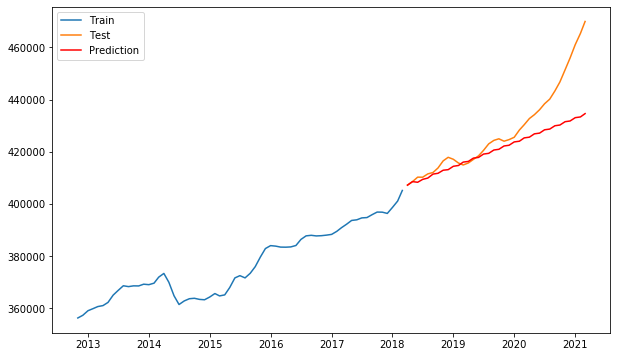

Model Explained Variance      r^2         MAE        RMSE  \
5  2nd Diff 36mo             67.75%   48.86%   $7,329.80  $11,859.02   
4  2nd Diff 24mo             54.80%   12.25%  $10,050.39  $14,432.66   
3  2nd Diff 12mo             40.30%  -40.10%  $10,892.44  $14,378.12   
2           36mo             66.66%   38.33%   $8,827.77  $13,023.85   
1           24mo             54.17%    3.08%  $11,013.03  $15,168.44   
0           12mo             41.06%  -59.07%  $12,155.19  $15,320.44   

  ARIMA Order Seasonal Order      AIC  
5   (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4   (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3   (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2   (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1   (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0   (0, 1, 0)   (0, 0, 0, 0)  1567.72

In [65]:
arima = pm.auto_arima(train_2diff_36mo, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100)
arima_eval('2nd Diff 36mo', ts, train_2diff_36mo, test_2diff_36mo, arima, periods=2);

## 1st Difference

In [66]:
train_1diff_12mo, test_1diff_12mo = model_selection.train_test_split(ts_diff.dropna(), test_size=12)
train_1diff_24mo, test_1diff_24mo = model_selection.train_test_split(ts_diff.dropna(), test_size=24)
train_1diff_36mo, test_1diff_36mo = model_selection.train_test_split(ts_diff.dropna(), test_size=36)

### 12 Month Test Set

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1567.725, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1537.715, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1534.680, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1592.035, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1529.619, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1524.450, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1522.405, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1524.317, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1526.291, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1534.596, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.542 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   90
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -757.203
Date:                Sun, 30 May 2021   AIC                           1522.405
Time:                        18:02:58   BIC                           1532.404
Sample:                             0   HQIC                          1526.437
                                 - 90                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    536.7137    137.537      3.902      0.000     267.146     806.281
ar.L1          0.7730      0.075     10.311      0.000       0.626       0.920
ar.L2         -0.4186      0.080     -5.203      0.000      -0.576      -0.261
sigma2      1.204e+06   1.49e+05      8.080      0.000    9.12e+05     1.5e+06
===================================================================================
Ljung-Box (Q):                       61.55   Jarque-Bera (JB):                 7.84
Prob(Q):                              0.02   Prob(JB):                         0.02
Heteroskedasticity (H):               0.70   Skew:                            -0.34
Prob(H) (two-sided):                  0.33   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

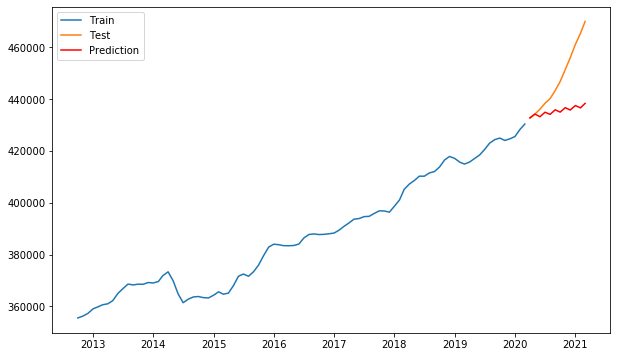

Model Explained Variance      r^2         MAE        RMSE  \
6  1st Diff 12mo             22.69%  -83.95%  $12,544.34  $16,475.30   
5  2nd Diff 36mo             67.75%   48.86%   $7,329.80  $11,859.02   
4  2nd Diff 24mo             54.80%   12.25%  $10,050.39  $14,432.66   
3  2nd Diff 12mo             40.30%  -40.10%  $10,892.44  $14,378.12   
2           36mo             66.66%   38.33%   $8,827.77  $13,023.85   
1           24mo             54.17%    3.08%  $11,013.03  $15,168.44   
0           12mo             41.06%  -59.07%  $12,155.19  $15,320.44   

  ARIMA Order Seasonal Order      AIC  
6   (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5   (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4   (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3   (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2   (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1   (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0   (0, 1, 0)   (0, 0, 0, 0)  1567.72

In [67]:
arima = pm.auto_arima(train_1diff_12mo, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100)
arima_eval('1st Diff 12mo', ts, train_1diff_12mo, test_1diff_12mo, arima, periods=2);

### 24 Month Test Set

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1364.272, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1338.187, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1334.513, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1380.770, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1331.156, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1327.122, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1325.071, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1327.091, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1329.112, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1333.497, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.142 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   78
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -658.536
Date:                Sun, 30 May 2021   AIC                           1325.071
Time:                        18:03:00   BIC                           1334.498
Sample:                             0   HQIC                          1328.845
                                 - 78                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    499.9244    151.165      3.307      0.001     203.646     796.203
ar.L1          0.7776      0.081      9.556      0.000       0.618       0.937
ar.L2         -0.4212      0.086     -4.902      0.000      -0.590      -0.253
sigma2       1.28e+06   1.72e+05      7.441      0.000    9.43e+05    1.62e+06
===================================================================================
Ljung-Box (Q):                       59.58   Jarque-Bera (JB):                 6.03
Prob(Q):                              0.02   Prob(JB):                         0.05
Heteroskedasticity (H):               0.66   Skew:                            -0.33
Prob(H) (two-sided):                  0.29   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

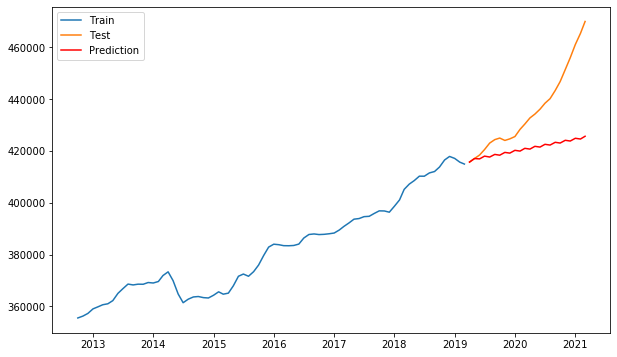

Model Explained Variance      r^2         MAE        RMSE  \
7  1st Diff 24mo             30.77%  -59.99%  $14,677.88  $19,488.23   
6  1st Diff 12mo             22.69%  -83.95%  $12,544.34  $16,475.30   
5  2nd Diff 36mo             67.75%   48.86%   $7,329.80  $11,859.02   
4  2nd Diff 24mo             54.80%   12.25%  $10,050.39  $14,432.66   
3  2nd Diff 12mo             40.30%  -40.10%  $10,892.44  $14,378.12   
2           36mo             66.66%   38.33%   $8,827.77  $13,023.85   
1           24mo             54.17%    3.08%  $11,013.03  $15,168.44   
0           12mo             41.06%  -59.07%  $12,155.19  $15,320.44   

  ARIMA Order Seasonal Order      AIC  
7   (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6   (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5   (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4   (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3   (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2   (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1   (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0   (0, 1, 0)   (0, 0, 0, 0)  1567.72

In [68]:
arima = pm.auto_arima(train_1diff_24mo, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100)
arima_eval('1st Diff 24mo', ts, train_1diff_24mo, test_1diff_24mo, arima, periods=2);

### 36 Month Test Set

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1123.817, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1158.520, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1137.020, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1133.865, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1171.143, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1124.668, Time=0.56 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1126.295, Time=0.31 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1125.513, Time=0.27 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1124.815, Time=0.62 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1130.192, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1123.732, Time=0.22 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=1123.534, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1122.604, Time=0.24 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1125.041, Time=0.20 sec

Best model:  ARIMA(0,0,2)(0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   66
Model:               SARIMAX(0, 0, 2)   Log Likelihood                -557.302
Date:                Sun, 30 May 2021   AIC                           1122.604
Time:                        18:03:04   BIC                           1131.363
Sample:                             0   HQIC                          1126.065
                                 - 66                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    545.3982    363.370      1.501      0.133    -166.794    1257.591
ma.L1          0.9408      0.087     10.827      0.000       0.771       1.111
ma.L2          0.6411      0.106      6.065      0.000       0.434       0.848
sigma2      1.228e+06   1.71e+05      7.181      0.000    8.93e+05    1.56e+06
===================================================================================
Ljung-Box (Q):                       59.14   Jarque-Bera (JB):                10.67
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.37
Prob(H) (two-sided):                  0.35   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

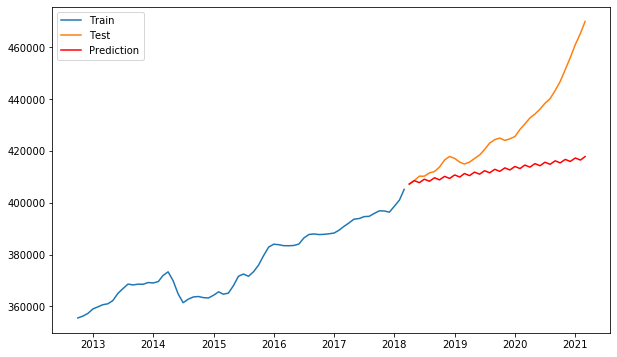

Model Explained Variance      r^2         MAE        RMSE  \
8  1st Diff 36mo             29.36%  -57.94%  $15,495.56  $20,841.99   
7  1st Diff 24mo             30.77%  -59.99%  $14,677.88  $19,488.23   
6  1st Diff 12mo             22.69%  -83.95%  $12,544.34  $16,475.30   
5  2nd Diff 36mo             67.75%   48.86%   $7,329.80  $11,859.02   
4  2nd Diff 24mo             54.80%   12.25%  $10,050.39  $14,432.66   
3  2nd Diff 12mo             40.30%  -40.10%  $10,892.44  $14,378.12   
2           36mo             66.66%   38.33%   $8,827.77  $13,023.85   
1           24mo             54.17%    3.08%  $11,013.03  $15,168.44   
0           12mo             41.06%  -59.07%  $12,155.19  $15,320.44   

  ARIMA Order Seasonal Order      AIC  
8   (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7   (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6   (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5   (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4   (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3   (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2   (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1   (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0   (0, 1, 0)   (0, 0, 0, 0)  1567.72

In [69]:
arima = pm.auto_arima(train_1diff_36mo, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100)
arima_eval('1st Diff 36mo', ts, train_1diff_36mo, test_1diff_36mo, arima, periods=2);

## Logged

In [70]:
train_log_12mo, test_log_12mo = model_selection.train_test_split(ts_log, test_size=12)
train_log_24mo, test_log_24mo = model_selection.train_test_split(ts_log, test_size=24)
train_log_36mo, test_log_36mo = model_selection.train_test_split(ts_log, test_size=36)

### 12 Month Test Set

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-792.854, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-745.708, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-775.273, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-781.310, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-722.539, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-788.368, Time=0.54 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-789.454, Time=0.33 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-791.714, Time=1.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-790.419, Time=1.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-781.702, Time=0.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-791.668, Time=1.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-787.188, Time=0.36 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-790.481, Time=1.36 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-788.776, Time=1.35 sec

Best model:  ARIMA(2,1,2)(0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 402.427
Date:                Sun, 30 May 2021   AIC                           -792.854
Time:                        18:03:16   BIC                           -777.856
Sample:                             0   HQIC                          -786.806
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.001      2.760      0.006       0.001       0.003
ar.L1          0.5236      0.240      2.181      0.029       0.053       0.994
ar.L2         -0.4525      0.147     -3.080      0.002      -0.741      -0.165
ma.L1          0.3048      0.271      1.126      0.260      -0.226       0.835
ma.L2          0.3338      0.217      1.535      0.125      -0.092       0.760
sigma2      7.555e-06      1e-06      7.522      0.000    5.59e-06    9.52e-06
===================================================================================
Ljung-Box (Q):                       56.30   Jarque-Bera (JB):                13.45
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.42
Prob(H) (two-sided):                  0.16   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

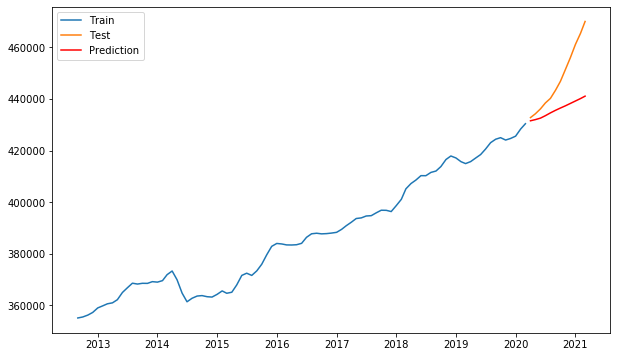

Model Explained Variance      r^2         MAE        RMSE  \
9    Logged 12mo             44.05%  -53.03%  $11,968.21  $15,026.74   
8  1st Diff 36mo             29.36%  -57.94%  $15,495.56  $20,841.99   
7  1st Diff 24mo             30.77%  -59.99%  $14,677.88  $19,488.23   
6  1st Diff 12mo             22.69%  -83.95%  $12,544.34  $16,475.30   
5  2nd Diff 36mo             67.75%   48.86%   $7,329.80  $11,859.02   
4  2nd Diff 24mo             54.80%   12.25%  $10,050.39  $14,432.66   
3  2nd Diff 12mo             40.30%  -40.10%  $10,892.44  $14,378.12   
2           36mo             66.66%   38.33%   $8,827.77  $13,023.85   
1           24mo             54.17%    3.08%  $11,013.03  $15,168.44   
0           12mo             41.06%  -59.07%  $12,155.19  $15,320.44   

  ARIMA Order Seasonal Order      AIC  
9   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8   (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7   (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6   (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5   (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4   (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3   (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2   (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1   (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0   (0, 1, 0)   (0, 0, 0, 0)  1567.72

In [71]:
arima = pm.auto_arima(train_log_12mo, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100)
y_pred_log_12mo = arima_eval('Logged 12mo', ts, train_log_12mo, test_log_12mo, arima, log=True);

### 24 Month Test Set

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-792.854, Time=1.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-745.708, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-775.273, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-781.310, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-722.539, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-788.368, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-789.454, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-791.714, Time=0.38 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-790.419, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-781.702, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-791.668, Time=0.36 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-787.188, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-790.481, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-788.776, Time=0.86 sec

Best model:  ARIMA(2,1,2)(0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 402.427
Date:                Sun, 30 May 2021   AIC                           -792.854
Time:                        18:03:22   BIC                           -777.856
Sample:                             0   HQIC                          -786.806
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.001      2.760      0.006       0.001       0.003
ar.L1          0.5236      0.240      2.181      0.029       0.053       0.994
ar.L2         -0.4525      0.147     -3.080      0.002      -0.741      -0.165
ma.L1          0.3048      0.271      1.126      0.260      -0.226       0.835
ma.L2          0.3338      0.217      1.535      0.125      -0.092       0.760
sigma2      7.555e-06      1e-06      7.522      0.000    5.59e-06    9.52e-06
===================================================================================
Ljung-Box (Q):                       56.30   Jarque-Bera (JB):                13.45
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.42
Prob(H) (two-sided):                  0.16   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

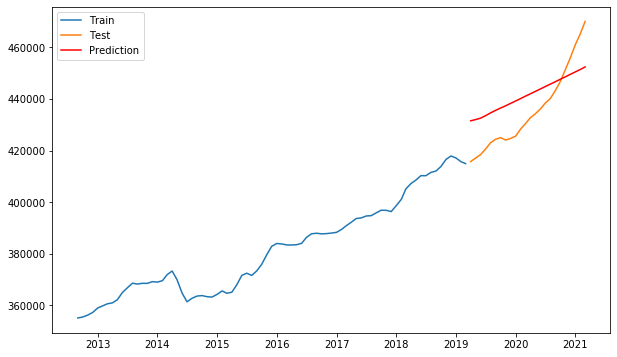

Model Explained Variance      r^2         MAE        RMSE  \
10    Logged 24mo             62.77%   47.38%  $10,337.96  $11,176.45   
9     Logged 12mo             44.05%  -53.03%  $11,968.21  $15,026.74   
8   1st Diff 36mo             29.36%  -57.94%  $15,495.56  $20,841.99   
7   1st Diff 24mo             30.77%  -59.99%  $14,677.88  $19,488.23   
6   1st Diff 12mo             22.69%  -83.95%  $12,544.34  $16,475.30   
5   2nd Diff 36mo             67.75%   48.86%   $7,329.80  $11,859.02   
4   2nd Diff 24mo             54.80%   12.25%  $10,050.39  $14,432.66   
3   2nd Diff 12mo             40.30%  -40.10%  $10,892.44  $14,378.12   
2            36mo             66.66%   38.33%   $8,827.77  $13,023.85   
1            24mo             54.17%    3.08%  $11,013.03  $15,168.44   
0            12mo             41.06%  -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

In [72]:
arima = pm.auto_arima(train_log_12mo, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100)
y_pred_log_12mo = arima_eval('Logged 24mo', ts, train_log_24mo, test_log_24mo, arima, log=True);

### 36 Month Test Set

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-792.854, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-745.708, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-775.273, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-781.310, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-722.539, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-788.368, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-789.454, Time=1.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-791.714, Time=0.99 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-790.419, Time=1.90 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-781.702, Time=0.69 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-791.668, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-787.188, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-790.481, Time=0.62 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-788.776, Time=1.16 sec

Best model:  ARIMA(2,1,2)(0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 402.427
Date:                Sun, 30 May 2021   AIC                           -792.854
Time:                        18:03:32   BIC                           -777.856
Sample:                             0   HQIC                          -786.806
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.001      2.760      0.006       0.001       0.003
ar.L1          0.5236      0.240      2.181      0.029       0.053       0.994
ar.L2         -0.4525      0.147     -3.080      0.002      -0.741      -0.165
ma.L1          0.3048      0.271      1.126      0.260      -0.226       0.835
ma.L2          0.3338      0.217      1.535      0.125      -0.092       0.760
sigma2      7.555e-06      1e-06      7.522      0.000    5.59e-06    9.52e-06
===================================================================================
Ljung-Box (Q):                       56.30   Jarque-Bera (JB):                13.45
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.42
Prob(H) (two-sided):                  0.16   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

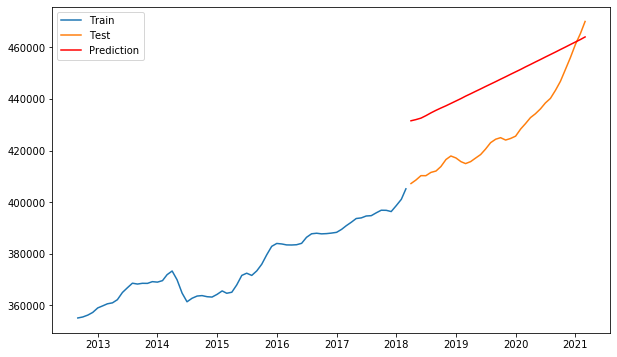

Model Explained Variance      r^2         MAE        RMSE  \
11    Logged 36mo             76.47%  -58.20%  $19,709.78  $20,858.69   
10    Logged 24mo             62.77%   47.38%  $10,337.96  $11,176.45   
9     Logged 12mo             44.05%  -53.03%  $11,968.21  $15,026.74   
8   1st Diff 36mo             29.36%  -57.94%  $15,495.56  $20,841.99   
7   1st Diff 24mo             30.77%  -59.99%  $14,677.88  $19,488.23   
6   1st Diff 12mo             22.69%  -83.95%  $12,544.34  $16,475.30   
5   2nd Diff 36mo             67.75%   48.86%   $7,329.80  $11,859.02   
4   2nd Diff 24mo             54.80%   12.25%  $10,050.39  $14,432.66   
3   2nd Diff 12mo             40.30%  -40.10%  $10,892.44  $14,378.12   
2            36mo             66.66%   38.33%   $8,827.77  $13,023.85   
1            24mo             54.17%    3.08%  $11,013.03  $15,168.44   
0            12mo             41.06%  -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

In [73]:
arima = pm.auto_arima(train_log_12mo, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100)
y_pred_log_12mo = arima_eval('Logged 36mo', ts, train_log_36mo, test_log_36mo, arima, log=True);

## Try Stats Models best params

In [74]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

#determine what the best model would be using a for loop
ans = []
for comb in pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(train_12mo,
                                        order=comb,
                                        seasonal_order=(0,0,0,0),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        output = mod.fit()
        ans.append([comb, output.aic])
        print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
    except:
        continue
            
#print out the best model parameters
ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
ans_df[ans_df['aic'] == ans_df['aic'].min()]

pdq         aic
7  (1, 1, 1)  1507.29678

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   7646   No. Observations:                   91
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -750.648
Date:                Sun, 30 May 2021   AIC                           1507.297
Time:                        18:03:33   BIC                           1514.729
Sample:                    09-01-2012   HQIC                          1510.291
                         - 03-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5872      0.089      6.583      0.000       0.412       0.762
ma.L1          0.1574      0.080      1.961      0.050    8.85e-05       0.315
sigma2      1.413e+06    1.8e+05      7.841      0.000    1.06e+06    1.77e+06
===================================================================================
Ljung-Box (Q):                      104.47   Jarque-Bera (JB):                 9.65
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               0.69   Skew:                            -0.35
Prob(H) (two-sided):                  0.33   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

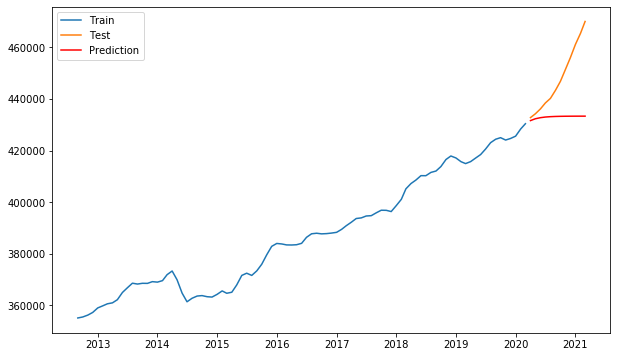

Model Explained Variance       r^2         MAE        RMSE  \
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

In [75]:
# run ARIMA model based on this returned order

warnings.filterwarnings("ignore") # specify to ignore warning messages
mod = sm.tsa.statespace.SARIMAX(train_12mo, order=(1,1,1),
                                seasonal_order=(0,0,0,0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
arima_eval('Stats Best Params', ts, train_12mo, test_12mo, mod, library='statsmodels');

In [76]:
# I'm curious about the better scores wtih longer test sets. I imagine that
# the last year throw the model off as the increase is so much greater than
# the rest of the time frame. So the longer test set provides a longer period
# that the model will predict closer to the known trend.

## Seasonality Needed?

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1510.366, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1483.875, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1499.082, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1496.451, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1548.123, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1485.873, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1485.873, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1487.873, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1537.644, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1494.465, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1498.226, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 1.835 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -739.938
Date:                Sun, 30 May 2021   AIC                           1483.875
Time:                        18:03:36   BIC                           1488.875
Sample:                             0   HQIC                          1485.892
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    938.7889     97.454      9.633      0.000     747.782    1129.795
sigma2      8.103e+05   1.29e+05      6.282      0.000    5.57e+05    1.06e+06
===================================================================================
Ljung-Box (Q):                       98.56   Jarque-Bera (JB):                 1.53
Prob(Q):                              0.00   Prob(JB):                         0.47
Heteroskedasticity (H):               0.91   Skew:                             0.31
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

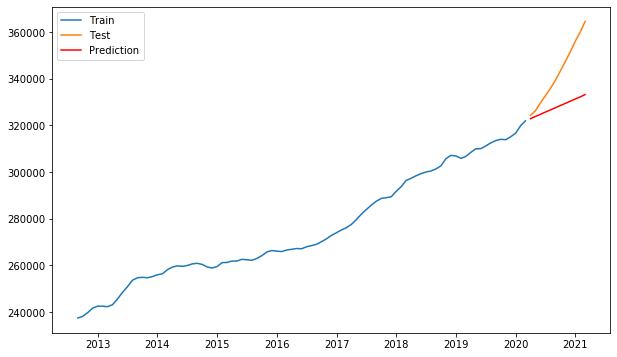

Model Explained Variance       r^2         MAE        RMSE  \
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1480.251, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1483.875, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1537.644, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1494.465, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1548.123, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1501.545, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1500.985, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1482.330, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1498.226, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1490.728, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1502.831, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=nan sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
To

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -739.938
Date:                Sun, 30 May 2021   AIC                           1483.875
Time:                        18:03:38   BIC                           1488.875
Sample:                             0   HQIC                          1485.892
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    938.7889     97.454      9.633      0.000     747.782    1129.795
sigma2      8.103e+05   1.29e+05      6.282      0.000    5.57e+05    1.06e+06
===================================================================================
Ljung-Box (Q):                       98.56   Jarque-Bera (JB):                 1.53
Prob(Q):                              0.00   Prob(JB):                         0.47
Heteroskedasticity (H):               0.91   Skew:                             0.31
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

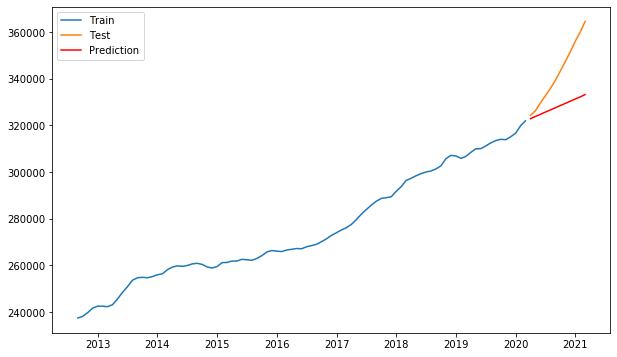

Model Explained Variance       r^2         MAE        RMSE  \
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1601.429, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1583.564, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1617.029, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1594.275, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1606.810, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1584.583, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1584.568, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1586.527, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1615.512, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1593.152, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1605.308, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 1.309 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -789.782
Date:                Sun, 30 May 2021   AIC                           1583.564
Time:                        18:03:40   BIC                           1588.563
Sample:                             0   HQIC                          1585.580
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    891.1222    175.532      5.077      0.000     547.086    1235.158
sigma2      2.453e+06   3.29e+05      7.452      0.000    1.81e+06     3.1e+06
===================================================================================
Ljung-Box (Q):                      301.87   Jarque-Bera (JB):                 7.17
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               0.51   Skew:                            -0.57
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

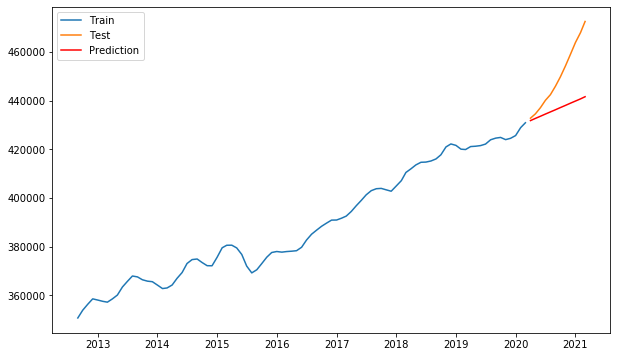

Model Explained Variance       r^2         MAE        RMSE  \
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1608.933, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1583.564, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1615.512, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1593.152, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1606.810, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1605.308, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.272 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -789.782
Date:                Sun, 30 May 2021   AIC                           1583.564
Time:                        18:03:40   BIC                           1588.563
Sample:                             0   HQIC                          1585.580
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    891.1222    175.532      5.077      0.000     547.086    1235.158
sigma2      2.453e+06   3.29e+05      7.452      0.000    1.81e+06     3.1e+06
===================================================================================
Ljung-Box (Q):                      301.87   Jarque-Bera (JB):                 7.17
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               0.51   Skew:                            -0.57
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

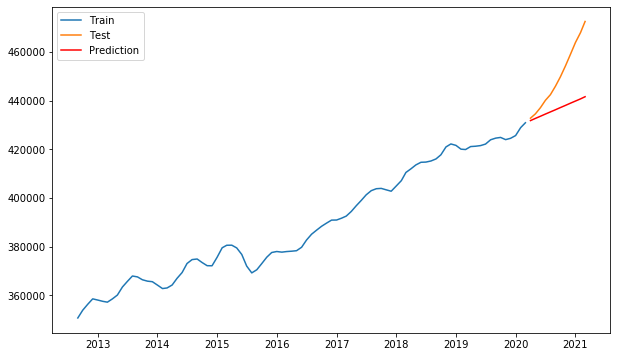

Model Explained Variance       r^2         MAE        RMSE  \
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1571.327, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1653.256, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1582.354, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1602.107, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1572.965, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1572.961, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1574.957, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1573.325, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1580.672, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1609.173, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 1.231 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -783.664
Date:                Sun, 30 May 2021   AIC                           1571.327
Time:                        18:03:42   BIC                           1576.327
Sample:                             0   HQIC                          1573.343
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    969.8667    164.833      5.884      0.000     646.800    1292.933
sigma2      2.141e+06    3.2e+05      6.701      0.000    1.51e+06    2.77e+06
===================================================================================
Ljung-Box (Q):                      176.12   Jarque-Bera (JB):                 4.54
Prob(Q):                              0.00   Prob(JB):                         0.10
Heteroskedasticity (H):               0.67   Skew:                             0.53
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

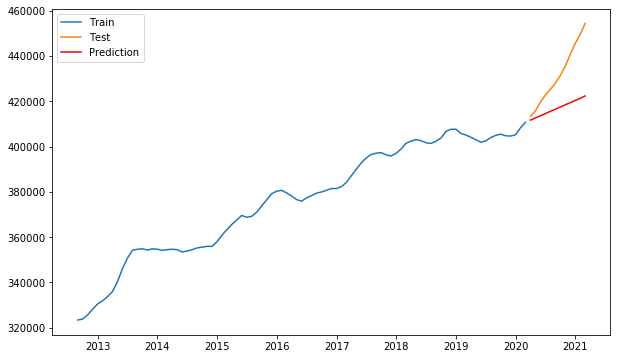

Model Explained Variance       r^2         MAE        RMSE  \
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1571.327, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1573.325, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1580.672, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1602.107, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1609.173, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.695 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -783.664
Date:                Sun, 30 May 2021   AIC                           1571.327
Time:                        18:03:43   BIC                           1576.327
Sample:                             0   HQIC                          1573.343
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    969.8667    164.833      5.884      0.000     646.800    1292.933
sigma2      2.141e+06    3.2e+05      6.701      0.000    1.51e+06    2.77e+06
===================================================================================
Ljung-Box (Q):                      176.12   Jarque-Bera (JB):                 4.54
Prob(Q):                              0.00   Prob(JB):                         0.10
Heteroskedasticity (H):               0.67   Skew:                             0.53
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

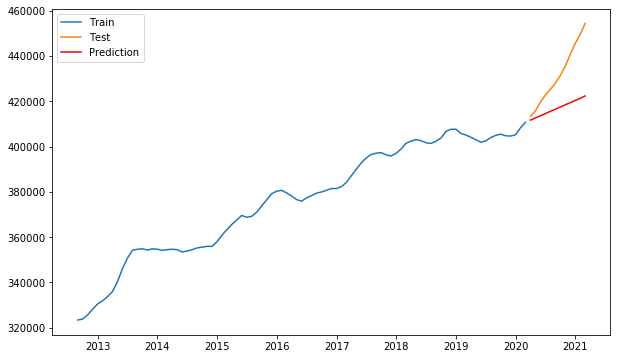

Model Explained Variance       r^2         MAE        RMSE  \
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1532.574, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1578.007, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1537.124, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1593.709, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1532.462, Time=0.10 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1532.713, Time=0.40 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1534.460, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1532.463, Time=0.07 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1534.712, Time=0.47 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1537.330, Time=0.28 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1540.976, Time=0.18 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=1596.023, Time=0.02 sec

Best model:  ARIMA(0,1,0)(1,0,0)[12] intercept
Total fit time: 3.209 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   91
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -763.231
Date:                            Sun, 30 May 2021   AIC                           1532.462
Time:                                    18:03:46   BIC                           1539.962
Sample:                                         0   HQIC                          1535.486
                                             - 91                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1189.6333    135.064      8.808      0.000     924.914    1454.353
ar.S.L12      -0.0099      0.030     -0.330      0.741      -0.068       0.049
sigma2      1.392e+06   2.29e+05      6.089      0.000    9.44e+05    1.84e+06
===================================================================================
Ljung-Box (Q):                      212.08   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.00   Prob(JB):                         0.80
Heteroskedasticity (H):               1.01   Skew:                            -0.16
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

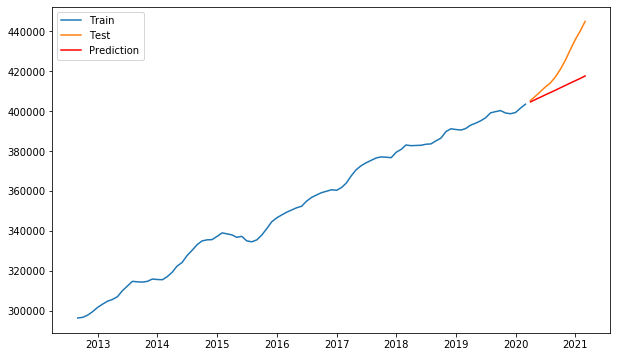

Model Explained Variance       r^2         MAE        RMSE  \
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1553.840, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1532.574, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1576.549, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1534.713, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1593.709, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1542.188, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.320 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   91
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -763.231
Date:                            Sun, 30 May 2021   AIC                           1532.462
Time:                                    18:03:46   BIC                           1539.962
Sample:                                         0   HQIC                          1535.486
                                             - 91                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1189.6333    135.064      8.808      0.000     924.914    1454.353
ar.S.L12      -0.0099      0.030     -0.330      0.741      -0.068       0.049
sigma2      1.392e+06   2.29e+05      6.089      0.000    9.44e+05    1.84e+06
===================================================================================
Ljung-Box (Q):                      212.08   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.00   Prob(JB):                         0.80
Heteroskedasticity (H):               1.01   Skew:                            -0.16
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

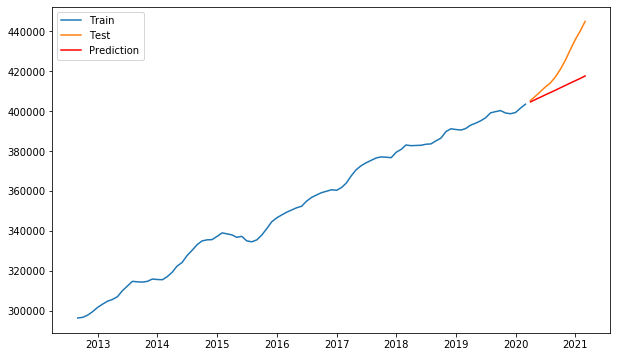

Model Explained Variance       r^2         MAE        RMSE  \
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1592.002, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1567.725, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1589.478, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1571.911, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1592.041, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1568.627, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1568.618, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1570.609, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1588.136, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1583.542, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1571.725, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 1.335 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -781.862
Date:                Sun, 30 May 2021   AIC                           1567.725
Time:                        18:03:48   BIC                           1572.724
Sample:                             0   HQIC                          1569.741
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    835.7778    166.945      5.006      0.000     508.572    1162.983
sigma2      2.057e+06   2.08e+05      9.897      0.000    1.65e+06    2.46e+06
===================================================================================
Ljung-Box (Q):                      134.70   Jarque-Bera (JB):                55.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -0.98
Prob(H) (two-sided):                  0.10   Kurtosis:                         6.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

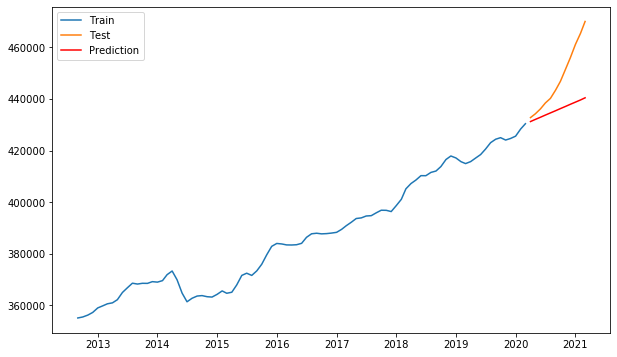

Model Explained Variance       r^2         MAE        RMSE  \
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1590.069, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1567.725, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1588.136, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1583.542, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1592.041, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1571.725, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.507 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -781.862
Date:                Sun, 30 May 2021   AIC                           1567.725
Time:                        18:03:49   BIC                           1572.724
Sample:                             0   HQIC                          1569.741
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    835.7778    166.945      5.006      0.000     508.572    1162.983
sigma2      2.057e+06   2.08e+05      9.897      0.000    1.65e+06    2.46e+06
===================================================================================
Ljung-Box (Q):                      134.70   Jarque-Bera (JB):                55.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -0.98
Prob(H) (two-sided):                  0.10   Kurtosis:                         6.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

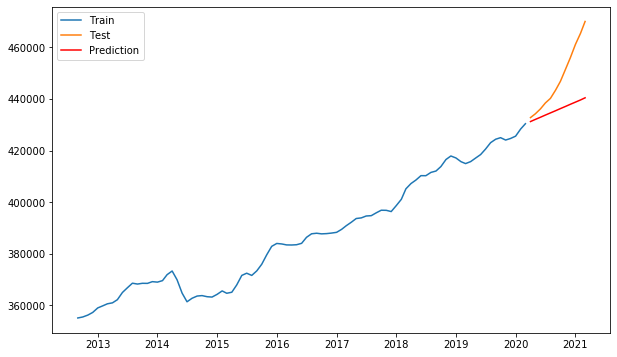

Model Explained Variance       r^2         MAE        RMSE  \
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
22   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1540.355, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1512.101, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1520.851, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1521.523, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1568.602, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1513.842, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1513.838, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1515.836, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1518.858, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1514.725, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1519.646, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 1.786 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -754.051
Date:                Sun, 30 May 2021   AIC                           1512.101
Time:                        18:03:51   BIC                           1517.101
Sample:                             0   HQIC                          1514.117
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1007.5000    110.998      9.077      0.000     789.948    1225.052
sigma2      1.109e+06   1.76e+05      6.291      0.000    7.63e+05    1.45e+06
===================================================================================
Ljung-Box (Q):                      154.80   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.00   Prob(JB):                         0.90
Heteroskedasticity (H):               0.80   Skew:                             0.01
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

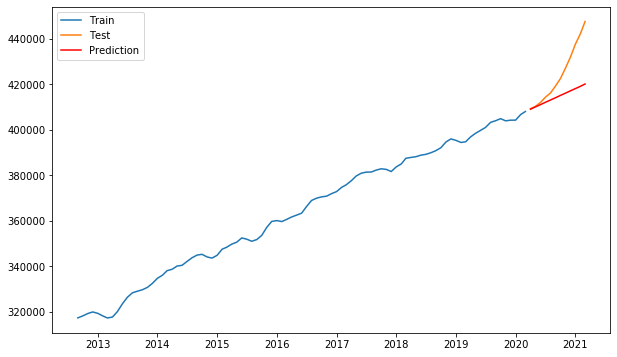

Model Explained Variance       r^2         MAE        RMSE  \
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
23   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
22   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1536.661, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1512.101, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1518.858, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1514.725, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1568.602, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1519.646, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.701 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -754.051
Date:                Sun, 30 May 2021   AIC                           1512.101
Time:                        18:03:52   BIC                           1517.101
Sample:                             0   HQIC                          1514.117
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1007.5000    110.998      9.077      0.000     789.948    1225.052
sigma2      1.109e+06   1.76e+05      6.291      0.000    7.63e+05    1.45e+06
===================================================================================
Ljung-Box (Q):                      154.80   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.00   Prob(JB):                         0.90
Heteroskedasticity (H):               0.80   Skew:                             0.01
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

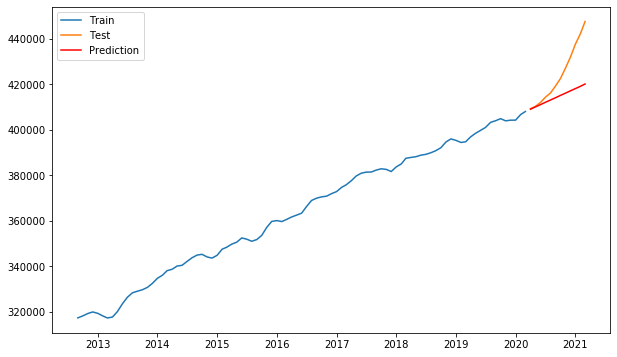

Model Explained Variance       r^2         MAE        RMSE  \
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
24   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
23   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
22   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=1644.617, Time=0.65 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1638.540, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1638.906, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1638.932, Time=0.15 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1638.329, Time=0.13 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=1673.237, Time=0.20 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1642.258, Time=1.19 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1639.720, Time=0.07 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=1683.931, Time=0.38 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1638.918, Time=0.07 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1640.554, Time=0.31 sec
 ARIMA(0,2,0)(1,0,0)[12] intercept   : AIC=1640.356, Time=0.04 sec

Best model:  ARIMA(0,2,0)(1,0,0)[12]          
Total fit time: 3.261 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   91
Model:             SARIMAX(0, 2, 0)x(1, 0, 0, 12)   Log Likelihood                -817.165
Date:                            Sun, 30 May 2021   AIC                           1638.329
Time:                                    18:03:55   BIC                           1643.306
Sample:                                         0   HQIC                          1640.335
                                             - 91                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0051      0.006     -0.802      0.423      -0.018       0.007
sigma2       5.53e+06   3.96e-12   1.39e+18      0.000    5.53e+06    5.53e+06
===================================================================================
Ljung-Box (Q):                      118.41   Jarque-Bera (JB):                 0.52
Prob(Q):                              0.00   Prob(JB):                         0.77
Heteroskedasticity (H):               1.15   Skew:                            -0.12
Prob(H) (two-sided):                  0.70   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

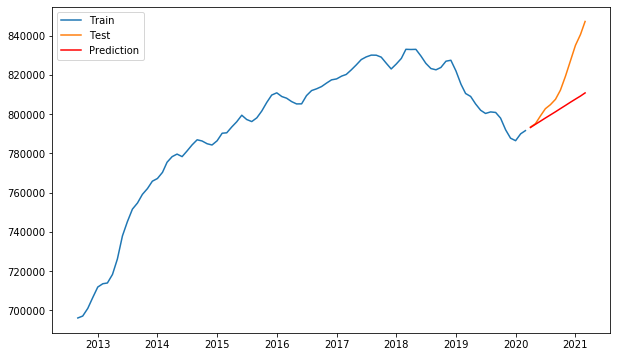

Model Explained Variance       r^2         MAE        RMSE  \
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
25   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
24   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
23   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
22   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1643.220, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1638.540, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1639.075, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1639.071, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1642.447, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1640.517, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.254 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   91
Model:             SARIMAX(0, 2, 0)x(1, 0, 0, 12)   Log Likelihood                -817.165
Date:                            Sun, 30 May 2021   AIC                           1638.329
Time:                                    18:03:56   BIC                           1643.306
Sample:                                         0   HQIC                          1640.335
                                             - 91                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0051      0.006     -0.802      0.423      -0.018       0.007
sigma2       5.53e+06   3.96e-12   1.39e+18      0.000    5.53e+06    5.53e+06
===================================================================================
Ljung-Box (Q):                      118.41   Jarque-Bera (JB):                 0.52
Prob(Q):                              0.00   Prob(JB):                         0.77
Heteroskedasticity (H):               1.15   Skew:                            -0.12
Prob(H) (two-sided):                  0.70   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

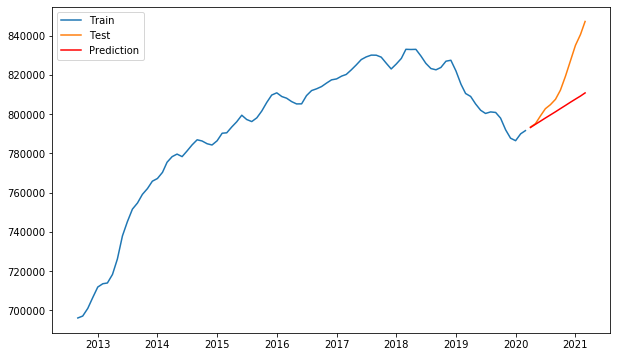

Model Explained Variance       r^2         MAE        RMSE  \
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
26   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
25   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
24   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
23   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
22   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1638.240, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1672.982, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1654.793, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1655.204, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1639.936, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1639.932, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1641.922, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1671.031, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1653.016, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1634.675, Time=0.20 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1658.850, Time=0.20 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1636.054, Time=0.37 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(2,1,1)(0,0,0)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -811.538
Date:                Sun, 30 May 2021   AIC                           1629.077
Time:                        18:04:03   BIC                           1636.576
Sample:                             0   HQIC                          1632.101
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9654      0.014     67.691      0.000       0.937       0.993
ma.L1         -0.9568      0.016    -60.113      0.000      -0.988      -0.926
sigma2      3.975e+06   1.71e-10   2.32e+16      0.000    3.98e+06    3.98e+06
===================================================================================
Ljung-Box (Q):                      168.88   Jarque-Bera (JB):                 1.43
Prob(Q):                              0.00   Prob(JB):                         0.49
Heteroskedasticity (H):               0.87   Skew:                             0.21
Prob(H) (two-sided):                  0.71   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.31e+31. Standard errors may be unstable.
"""

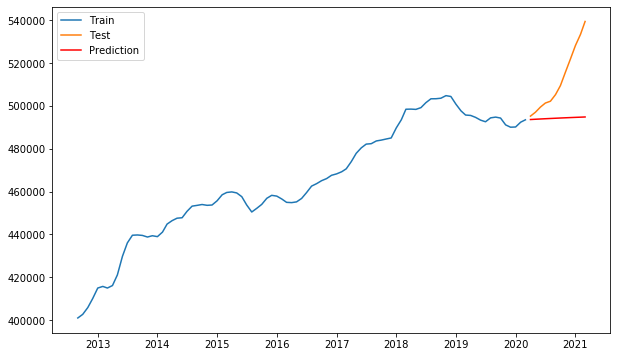

Model Explained Variance       r^2         MAE        RMSE  \
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
27   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
26   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
25   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
24   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
23   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
22   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1638.240, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1671.031, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1653.016, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1655.204, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1634.675, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1664.605, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1670.524, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1677.562, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1676.181, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1629.077, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1669.534, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1655.840, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1644.991, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -811.538
Date:                Sun, 30 May 2021   AIC                           1629.077
Time:                        18:04:04   BIC                           1636.576
Sample:                             0   HQIC                          1632.101
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9654      0.014     67.691      0.000       0.937       0.993
ma.L1         -0.9568      0.016    -60.113      0.000      -0.988      -0.926
sigma2      3.975e+06   1.71e-10   2.32e+16      0.000    3.98e+06    3.98e+06
===================================================================================
Ljung-Box (Q):                      168.88   Jarque-Bera (JB):                 1.43
Prob(Q):                              0.00   Prob(JB):                         0.49
Heteroskedasticity (H):               0.87   Skew:                             0.21
Prob(H) (two-sided):                  0.71   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.31e+31. Standard errors may be unstable.
"""

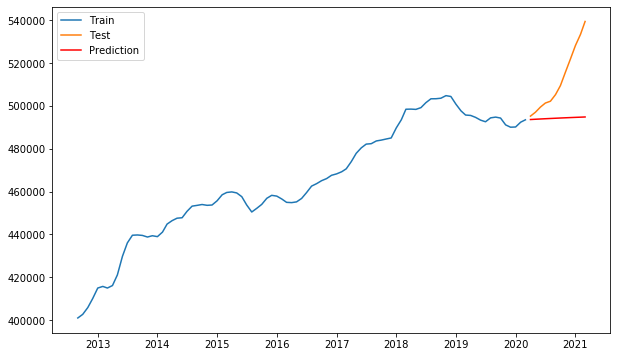

Model Explained Variance       r^2         MAE        RMSE  \
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
28   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
27   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
26   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
25   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
24   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
23   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
22   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1565.793, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1549.478, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1560.371, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1554.008, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1576.966, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1548.356, Time=0.08 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1550.462, Time=0.09 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1550.406, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1548.438, Time=0.04 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1552.406, Time=0.29 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1554.192, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1551.814, Time=0.15 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=1579.089, Time=0.04 sec

Best model:  ARIMA(0,1,0)(1,0,0)[12] intercept
Total fit time: 1.597 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   91
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -771.178
Date:                            Sun, 30 May 2021   AIC                           1548.356
Time:                                    18:04:06   BIC                           1555.855
Sample:                                         0   HQIC                          1551.380
                                             - 91                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    827.4811    137.200      6.031      0.000     558.574    1096.388
ar.S.L12      -0.0112      0.028     -0.397      0.691      -0.067       0.044
sigma2      1.605e+06   2.42e+05      6.638      0.000    1.13e+06    2.08e+06
===================================================================================
Ljung-Box (Q):                      174.01   Jarque-Bera (JB):                 0.15
Prob(Q):                              0.00   Prob(JB):                         0.93
Heteroskedasticity (H):               1.24   Skew:                             0.10
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

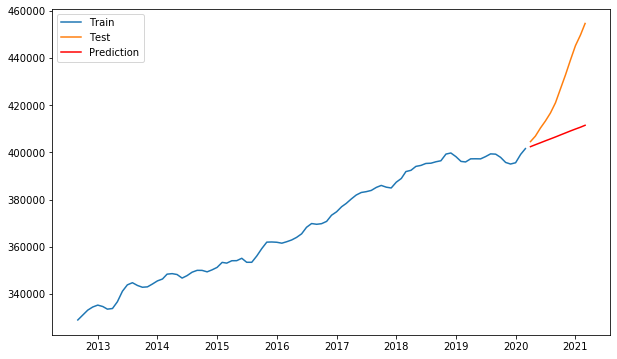

Model Explained Variance       r^2         MAE        RMSE  \
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
29   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
28   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
27   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
26   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
25   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
24   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
23   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
22   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1527.736, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1549.478, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1560.728, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1554.997, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1576.966, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1560.964, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1552.949, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1573.981, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1535.232, Time=0.45 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1551.282, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1584.540, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1566.062, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1570.582, Time=0.82 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.61 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   91
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -771.178
Date:                            Sun, 30 May 2021   AIC                           1548.356
Time:                                    18:04:10   BIC                           1555.855
Sample:                                         0   HQIC                          1551.380
                                             - 91                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    827.4811    137.200      6.031      0.000     558.574    1096.388
ar.S.L12      -0.0112      0.028     -0.397      0.691      -0.067       0.044
sigma2      1.605e+06   2.42e+05      6.638      0.000    1.13e+06    2.08e+06
===================================================================================
Ljung-Box (Q):                      174.01   Jarque-Bera (JB):                 0.15
Prob(Q):                              0.00   Prob(JB):                         0.93
Heteroskedasticity (H):               1.24   Skew:                             0.10
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

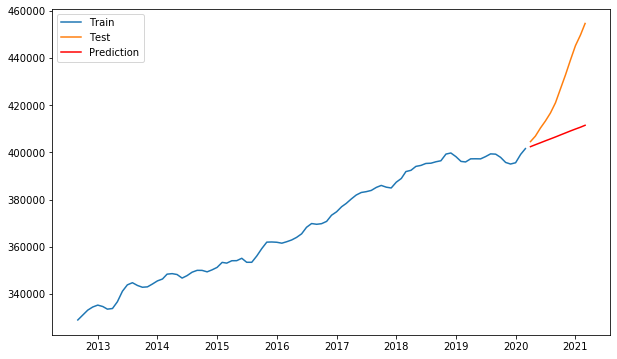

Model Explained Variance       r^2         MAE        RMSE  \
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
30   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
29   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
28   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
27   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
26   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
25   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
24   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
23   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
22   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1682.007, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1689.804, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1692.589, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1705.190, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1683.912, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1683.911, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1685.911, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1687.999, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1690.853, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1685.328, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 2.049 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -839.004
Date:                Sun, 30 May 2021   AIC                           1682.007
Time:                        18:04:12   BIC                           1687.007
Sample:                             0   HQIC                          1684.023
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1537.5778    327.904      4.689      0.000     894.897    2180.259
sigma2      7.324e+06   1.04e+06      7.044      0.000    5.29e+06    9.36e+06
===================================================================================
Ljung-Box (Q):                       99.89   Jarque-Bera (JB):                13.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.84
Prob(H) (two-sided):                  0.73   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

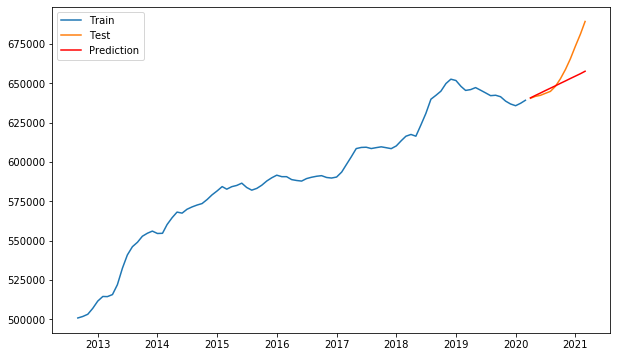

Model Explained Variance       r^2         MAE        RMSE  \
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
31   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
30   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
29   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
28   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
27   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
26   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
25   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
24   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
23   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
22   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1, 0)   (0, 0, 0, 0)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1720.679, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1682.007, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1687.999, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1690.853, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1705.190, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1685.328, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.365 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -839.004
Date:                Sun, 30 May 2021   AIC                           1682.007
Time:                        18:04:13   BIC                           1687.007
Sample:                             0   HQIC                          1684.023
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1537.5778    327.904      4.689      0.000     894.897    2180.259
sigma2      7.324e+06   1.04e+06      7.044      0.000    5.29e+06    9.36e+06
===================================================================================
Ljung-Box (Q):                       99.89   Jarque-Bera (JB):                13.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.84
Prob(H) (two-sided):                  0.73   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

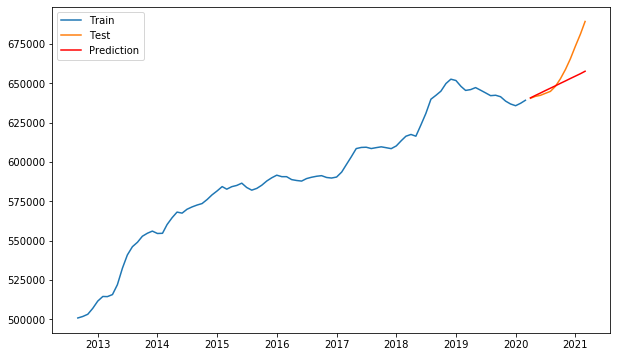

Model Explained Variance       r^2         MAE        RMSE  \
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
32   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
31   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
30   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
29   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
28   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
27   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
26   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
25   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
24   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
23   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
22   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)   (0, 0, 0, 0)  1512.83  
2    (0, 1, 0)   (0, 0, 0, 0)  1158.52  
1    (0, 1, 0)   (0, 0, 0, 0)  1364.27  
0    (0, 1

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=1620.549, Time=0.40 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1611.448, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1615.075, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1615.070, Time=0.06 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1622.538, Time=0.03 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1613.187, Time=0.08 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1620.977, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1613.319, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1613.315, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1614.135, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1613.430, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.947 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -804.724
Date:                Sun, 30 May 2021   AIC                           1611.448
Time:                        18:04:14   BIC                           1613.937
Sample:                             0   HQIC                          1612.451
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.108e+06   6.97e+05      5.897      0.000    2.74e+06    5.47e+06
===================================================================================
Ljung-Box (Q):                      100.91   Jarque-Bera (JB):                 0.92
Prob(Q):                              0.00   Prob(JB):                         0.63
Heteroskedasticity (H):               0.89   Skew:                             0.04
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

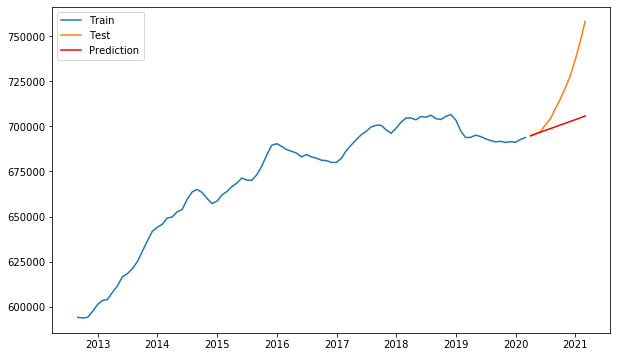

Model Explained Variance       r^2         MAE        RMSE  \
33      Seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
33   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
32   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
31   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
30   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
29   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
28   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
27   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
26   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
25   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
24   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
23   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
22   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (0, 0, 0, 0)  1522.41  
5    (3, 0, 1)   (0, 0, 0, 0)  1111.69  
4    (2, 0, 1)   (0, 0, 0, 0)  1316.28  
3    (2, 0, 1)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1616.838, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1611.448, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1613.319, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1613.315, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1614.135, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1613.430, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.357 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -804.724
Date:                Sun, 30 May 2021   AIC                           1611.448
Time:                        18:04:14   BIC                           1613.937
Sample:                             0   HQIC                          1612.451
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.108e+06   6.97e+05      5.897      0.000    2.74e+06    5.47e+06
===================================================================================
Ljung-Box (Q):                      100.91   Jarque-Bera (JB):                 0.92
Prob(Q):                              0.00   Prob(JB):                         0.63
Heteroskedasticity (H):               0.89   Skew:                             0.04
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

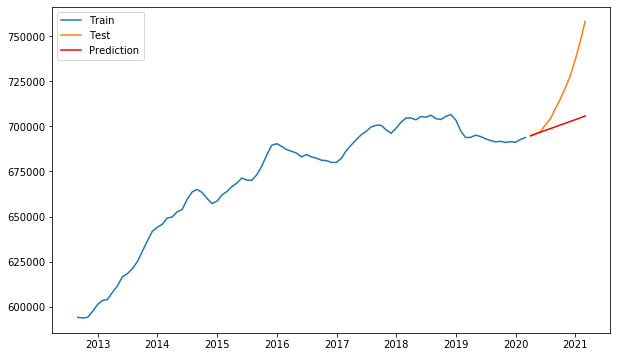

Model Explained Variance       r^2         MAE        RMSE  \
34  Non-seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
33      Seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
34   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
33   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
32   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
31   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
30   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
29   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
28   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
27   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
26   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
25   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
24   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
23   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
22   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0, 0, 0)  -792.85  
8    (0, 0, 2)   (0, 0, 0, 0)  1122.60  
7    (2, 0, 0)   (0, 0, 0, 0)  1325.07  
6    (2, 0, 0)   (

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1599.753, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1567.083, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1594.501, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1578.781, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1590.994, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1568.876, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1568.873, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1570.869, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1572.313, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1576.922, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1581.555, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 0.761 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -781.542
Date:                Sun, 30 May 2021   AIC                           1567.083
Time:                        18:04:15   BIC                           1572.083
Sample:                             0   HQIC                          1569.099
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    825.4000    150.710      5.477      0.000     530.014    1120.786
sigma2      2.043e+06   3.24e+05      6.312      0.000    1.41e+06    2.68e+06
===================================================================================
Ljung-Box (Q):                      185.19   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.00   Prob(JB):                         0.90
Heteroskedasticity (H):               0.99   Skew:                            -0.04
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

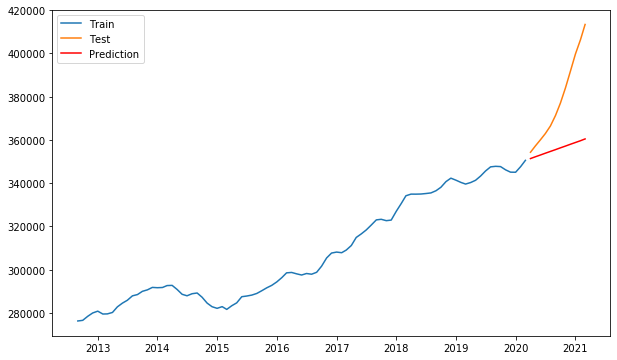

Model Explained Variance       r^2         MAE        RMSE  \
35      Seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
34  Non-seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
33      Seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
35   (0, 1, 0)  (0, 0, 0, 12)  1567.08  
34   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
33   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
32   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
31   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
30   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
29   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
28   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
27   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
26   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
25   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
24   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
23   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
22   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0, 0)  1507.30  
11   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
10   (2, 1, 2)   (0, 0, 0, 0)  -792.85  
9    (2, 1, 2)   (0, 0

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1587.278, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1567.083, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1572.313, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1576.922, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1590.994, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1581.555, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.452 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -781.542
Date:                Sun, 30 May 2021   AIC                           1567.083
Time:                        18:04:16   BIC                           1572.083
Sample:                             0   HQIC                          1569.099
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    825.4000    150.710      5.477      0.000     530.014    1120.786
sigma2      2.043e+06   3.24e+05      6.312      0.000    1.41e+06    2.68e+06
===================================================================================
Ljung-Box (Q):                      185.19   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.00   Prob(JB):                         0.90
Heteroskedasticity (H):               0.99   Skew:                            -0.04
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

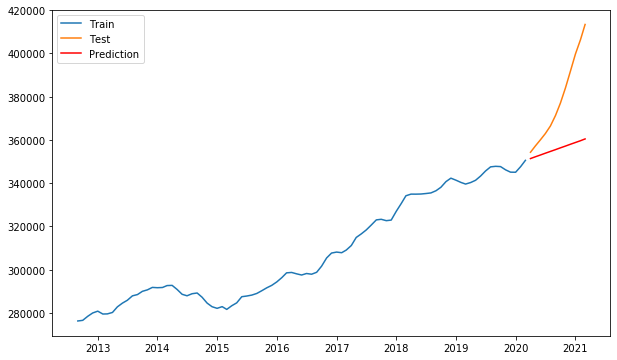

Model Explained Variance       r^2         MAE        RMSE  \
36  Non-seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
35      Seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
34  Non-seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
33      Seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
36   (0, 1, 0)  (0, 0, 0, 12)  1567.08  
35   (0, 1, 0)  (0, 0, 0, 12)  1567.08  
34   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
33   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
32   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
31   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
30   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
29   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
28   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
27   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
26   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
25   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
24   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
23   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
22   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
14   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
13   (0, 1, 0)  (0, 0, 0, 12)  1483.88  
12   (1, 1, 1)   (0, 0, 0,

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1733.808, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1682.505, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1717.789, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1693.142, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1690.752, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1683.745, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1683.741, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1685.734, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1716.500, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1691.990, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1682.558, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 1.128 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -839.253
Date:                Sun, 30 May 2021   AIC                           1682.505
Time:                        18:04:17   BIC                           1687.505
Sample:                             0   HQIC                          1684.521
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    942.1000    286.178      3.292      0.001     381.202    1502.998
sigma2      7.364e+06   8.09e+05      9.108      0.000    5.78e+06    8.95e+06
===================================================================================
Ljung-Box (Q):                      151.15   Jarque-Bera (JB):                10.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.06
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

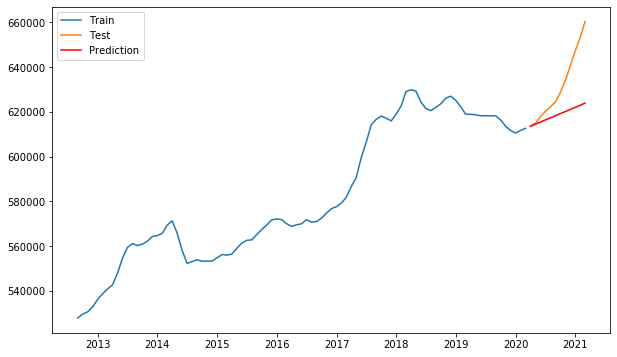

Model Explained Variance       r^2         MAE        RMSE  \
37      Seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
36  Non-seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
35      Seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
34  Non-seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
33      Seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
37   (0, 1, 0)  (0, 0, 0, 12)  1682.51  
36   (0, 1, 0)  (0, 0, 0, 12)  1567.08  
35   (0, 1, 0)  (0, 0, 0, 12)  1567.08  
34   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
33   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
32   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
31   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
30   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
29   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
28   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
27   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
26   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
25   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
24   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
23   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
22   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
17   (0, 1, 0)  (0, 0, 0, 12)  1571.33  
16   (0, 1, 0)  (0, 0, 0, 12)  1583.56  
15   (0, 1, 0)  (0, 0, 0, 12) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1729.790, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1682.505, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1716.500, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1691.990, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1690.752, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1682.558, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.451 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -839.253
Date:                Sun, 30 May 2021   AIC                           1682.505
Time:                        18:04:18   BIC                           1687.505
Sample:                             0   HQIC                          1684.521
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    942.1000    286.178      3.292      0.001     381.202    1502.998
sigma2      7.364e+06   8.09e+05      9.108      0.000    5.78e+06    8.95e+06
===================================================================================
Ljung-Box (Q):                      151.15   Jarque-Bera (JB):                10.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.06
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

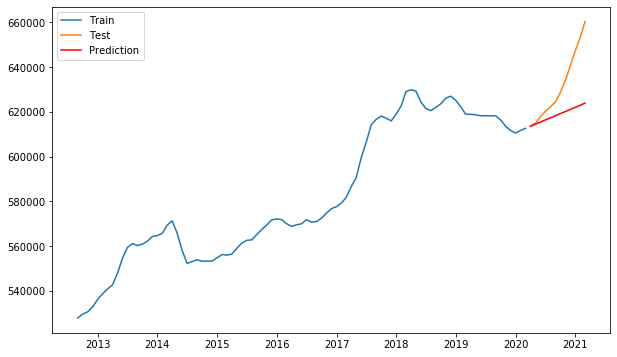

Model Explained Variance       r^2         MAE        RMSE  \
38  Non-seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
37      Seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
36  Non-seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
35      Seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
34  Non-seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
33      Seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
38   (0, 1, 0)  (0, 0, 0, 12)  1682.51  
37   (0, 1, 0)  (0, 0, 0, 12)  1682.51  
36   (0, 1, 0)  (0, 0, 0, 12)  1567.08  
35   (0, 1, 0)  (0, 0, 0, 12)  1567.08  
34   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
33   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
32   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
31   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
30   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
29   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
28   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
27   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
26   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
25   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
24   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
23   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
22   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
20   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
19   (0, 1, 0)  (1, 0, 0, 12)  1532.46  
18   (0, 1, 0)  (0, 0, 0, 12)  157

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=1554.597, Time=0.35 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1547.405, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1548.192, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1548.323, Time=0.06 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1553.840, Time=0.03 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1548.101, Time=0.05 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1557.685, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1549.232, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1549.189, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1552.869, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1549.405, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.827 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -772.703
Date:                Sun, 30 May 2021   AIC                           1547.405
Time:                        18:04:19   BIC                           1549.894
Sample:                             0   HQIC                          1548.408
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.035e+06   3.36e+05      6.051      0.000    1.38e+06    2.69e+06
===================================================================================
Ljung-Box (Q):                      123.36   Jarque-Bera (JB):                 0.47
Prob(Q):                              0.00   Prob(JB):                         0.79
Heteroskedasticity (H):               0.96   Skew:                            -0.00
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

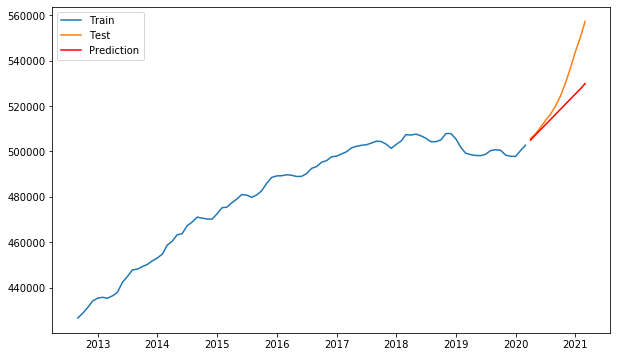

Model Explained Variance       r^2         MAE        RMSE  \
39      Seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
38  Non-seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
37      Seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
36  Non-seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
35      Seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
34  Non-seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
33      Seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
39   (0, 2, 0)  (0, 0, 0, 12)  1547.41  
38   (0, 1, 0)  (0, 0, 0, 12)  1682.51  
37   (0, 1, 0)  (0, 0, 0, 12)  1682.51  
36   (0, 1, 0)  (0, 0, 0, 12)  1567.08  
35   (0, 1, 0)  (0, 0, 0, 12)  1567.08  
34   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
33   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
32   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
31   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
30   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
29   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
28   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
27   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
26   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
25   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
24   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
23   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
22   (0, 1, 0)  (0, 0, 0, 12)  1567.72  
21   (0, 1, 0)  (0, 0, 0, 12)  1567.72

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1554.644, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1547.405, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1549.232, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1549.189, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1552.869, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1549.405, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.219 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -772.703
Date:                Sun, 30 May 2021   AIC                           1547.405
Time:                        18:04:19   BIC                           1549.894
Sample:                             0   HQIC                          1548.408
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.035e+06   3.36e+05      6.051      0.000    1.38e+06    2.69e+06
===================================================================================
Ljung-Box (Q):                      123.36   Jarque-Bera (JB):                 0.47
Prob(Q):                              0.00   Prob(JB):                         0.79
Heteroskedasticity (H):               0.96   Skew:                            -0.00
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

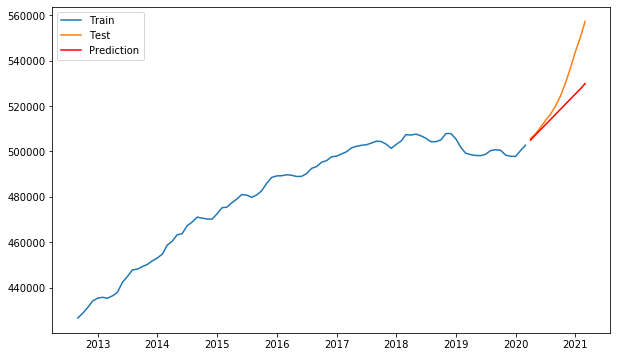

Model Explained Variance       r^2         MAE        RMSE  \
40  Non-seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
39      Seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
38  Non-seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
37      Seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
36  Non-seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
35      Seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
34  Non-seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
33      Seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
40   (0, 2, 0)  (0, 0, 0, 12)  1547.41  
39   (0, 2, 0)  (0, 0, 0, 12)  1547.41  
38   (0, 1, 0)  (0, 0, 0, 12)  1682.51  
37   (0, 1, 0)  (0, 0, 0, 12)  1682.51  
36   (0, 1, 0)  (0, 0, 0, 12)  1567.08  
35   (0, 1, 0)  (0, 0, 0, 12)  1567.08  
34   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
33   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
32   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
31   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
30   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
29   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
28   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
27   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
26   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
25   (0, 2, 0)  (1, 0, 0, 12)  1638.33  
24   (0, 1, 0)  (0, 0, 0, 12)  1512.10  
2

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1511.125, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1513.937, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1510.303, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1511.069, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1557.538, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1512.821, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1523.621, Time=0.12 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1512.199, Time=0.19 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1523.182, Time=0.04 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1510.367, Time=0.28 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1510.995, Time=0.07 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1506.001, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1509.110, Time=0.14 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=1513.456, Time=0.12 sec
 ARIMA(2,1,0)(1,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   91
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -747.488
Date:                            Sun, 30 May 2021   AIC                           1504.977
Time:                                    18:04:27   BIC                           1517.476
Sample:                                         0   HQIC                          1510.017
                                             - 91                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    522.4934    371.092      1.408      0.159    -204.834    1249.821
ar.L1          0.3916      0.421      0.931      0.352      -0.433       1.216
ma.L1         -0.3732      0.427     -0.875      0.382      -1.209       0.463
ma.S.L12      -0.0150      0.024     -0.634      0.526      -0.061       0.031
sigma2      9.534e+05   1.47e+05      6.481      0.000    6.65e+05    1.24e+06
===================================================================================
Ljung-Box (Q):                       92.99   Jarque-Bera (JB):                 0.00
Prob(Q):                              0.00   Prob(JB):                         1.00
Heteroskedasticity (H):               1.64   Skew:                            -0.01
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

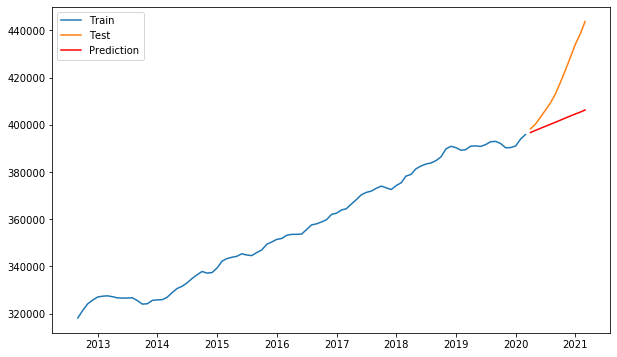

Model Explained Variance       r^2         MAE        RMSE  \
41      Seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
40  Non-seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
39      Seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
38  Non-seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
37      Seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
36  Non-seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
35      Seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
34  Non-seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
33      Seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
41   (1, 1, 1)  (0, 0, 1, 12)  1504.98  
40   (0, 2, 0)  (0, 0, 0, 12)  1547.41  
39   (0, 2, 0)  (0, 0, 0, 12)  1547.41  
38   (0, 1, 0)  (0, 0, 0, 12)  1682.51  
37   (0, 1, 0)  (0, 0, 0, 12)  1682.51  
36   (0, 1, 0)  (0, 0, 0, 12)  1567.08  
35   (0, 1, 0)  (0, 0, 0, 12)  1567.08  
34   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
33   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
32   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
31   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
30   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
29   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
28   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
27   (1, 1, 1)  (0, 0, 0, 12)  1629.08  
26   

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1514.721, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1513.937, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1512.821, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1514.387, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1557.538, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1509.110, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1513.734, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1511.310, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1510.186, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1513.264, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1559.898, Time=0.02 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.841 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   91
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -747.488
Date:                            Sun, 30 May 2021   AIC                           1504.977
Time:                                    18:04:28   BIC                           1517.476
Sample:                                         0   HQIC                          1510.017
                                             - 91                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    522.4934    371.092      1.408      0.159    -204.834    1249.821
ar.L1          0.3916      0.421      0.931      0.352      -0.433       1.216
ma.L1         -0.3732      0.427     -0.875      0.382      -1.209       0.463
ma.S.L12      -0.0150      0.024     -0.634      0.526      -0.061       0.031
sigma2      9.534e+05   1.47e+05      6.481      0.000    6.65e+05    1.24e+06
===================================================================================
Ljung-Box (Q):                       92.99   Jarque-Bera (JB):                 0.00
Prob(Q):                              0.00   Prob(JB):                         1.00
Heteroskedasticity (H):               1.64   Skew:                            -0.01
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

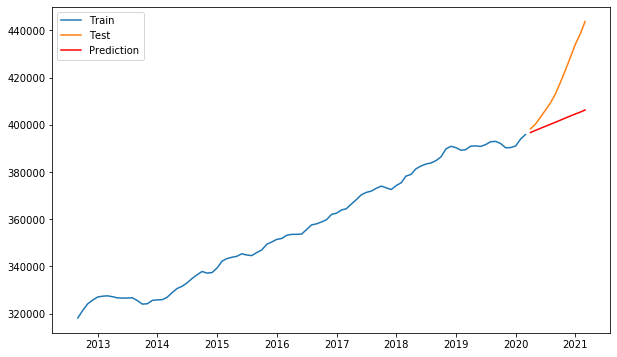

Model Explained Variance       r^2         MAE        RMSE  \
42  Non-seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
41      Seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
40  Non-seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
39      Seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
38  Non-seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
37      Seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
36  Non-seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
35      Seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
34  Non-seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
33      Seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
42   (1, 1, 1)  (0, 0, 1, 12)  1504.98  
41   (1, 1, 1)  (0, 0, 1, 12)  1504.98  
40   (0, 2, 0)  (0, 0, 0, 12)  1547.41  
39   (0, 2, 0)  (0, 0, 0, 12)  1547.41  
38   (0, 1, 0)  (0, 0, 0, 12)  1682.51  
37   (0, 1, 0)  (0, 0, 0, 12)  1682.51  
36   (0, 1, 0)  (0, 0, 0, 12)  1567.08  
35   (0, 1, 0)  (0, 0, 0, 12)  1567.08  
34   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
33   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
32   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
31   (0, 1, 0)  (0, 0, 0, 12)  1682.01  
30   (0, 1, 0)  (1, 0, 0, 12)  1548.36  
29   (0, 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=1754.924, Time=0.44 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1752.720, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1752.681, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1752.634, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1752.787, Time=0.02 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1754.434, Time=0.99 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=1754.428, Time=0.10 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1752.627, Time=0.05 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=1754.427, Time=0.35 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=1756.446, Time=0.14 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1764.362, Time=0.04 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1760.206, Time=0.08 sec
 ARIMA(0,2,2)(1,0,0)[12]             : AIC=1754.586, Time=0.10 sec
 ARIMA(1,2,2)(1,0,0)[12]             : AIC=1756.613, Time=0.08 sec
 ARIMA(0,2,1)(1,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   91
Model:             SARIMAX(0, 2, 1)x(1, 0, [], 12)   Log Likelihood                -873.314
Date:                             Sun, 30 May 2021   AIC                           1752.627
Time:                                     18:04:31   BIC                           1760.093
Sample:                                          0   HQIC                          1755.637
                                              - 91                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0064      0.102     -0.063      0.950      -0.206       0.193
ar.S.L12      -0.0049      0.008     -0.578      0.564      -0.021       0.012
sigma2      1.955e+07   4.99e-10   3.92e+16      0.000    1.95e+07    1.95e+07
===================================================================================
Ljung-Box (Q):                      180.09   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.00   Prob(JB):                         0.99
Heteroskedasticity (H):               0.95   Skew:                             0.02
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.3e+32. Standard errors may be unstable.
"""

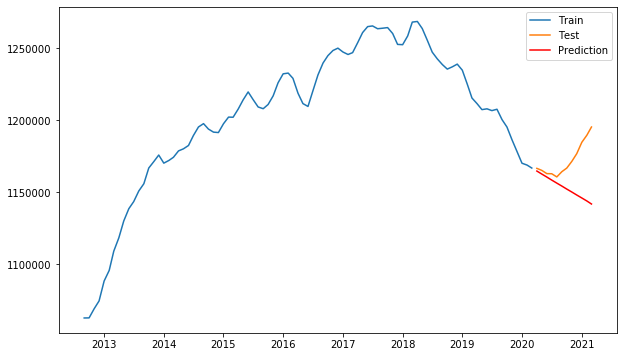

Model Explained Variance       r^2         MAE        RMSE  \
43      Seasonal 7632           -151.48%  -441.30%  $18,957.02  $25,907.51   
42  Non-seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
41      Seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
40  Non-seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
39      Seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
38  Non-seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
37      Seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
36  Non-seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
35      Seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
34  Non-seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
33      Seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
43   (0, 2, 1)  (1, 0, 0, 12)  1752.63  
42   (1, 1, 1)  (0, 0, 1, 12)  1504.98  
41   (1, 1, 1)  (0, 0, 1, 12)  1504.98  
40   (0, 2, 0)  (0, 0, 0, 12)  1547.41  
39   (0, 2, 0)  (0, 0, 0, 12)  1547.41  
38   (0, 1, 0)  (0, 0, 0, 12)  1682.51  
37   (0, 1, 0)  (0, 0, 0, 12)  1682.51  
36   (0, 1, 0)  (0, 0, 0, 12)  1567.08  
35   (0, 1, 0)  (0, 0, 0, 12)  1567.08  
34   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
33   (0, 2, 0)  (0, 0, 0, 12)  1611.45  
32   (0, 1, 0

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1753.719, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1752.720, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1752.765, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1752.787, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1761.242, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1754.696, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.253 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   91
Model:             SARIMAX(0, 2, 1)x(1, 0, [], 12)   Log Likelihood                -873.314
Date:                             Sun, 30 May 2021   AIC                           1752.627
Time:                                     18:04:31   BIC                           1760.093
Sample:                                          0   HQIC                          1755.637
                                              - 91                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0064      0.102     -0.063      0.950      -0.206       0.193
ar.S.L12      -0.0049      0.008     -0.578      0.564      -0.021       0.012
sigma2      1.955e+07   4.99e-10   3.92e+16      0.000    1.95e+07    1.95e+07
===================================================================================
Ljung-Box (Q):                      180.09   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.00   Prob(JB):                         0.99
Heteroskedasticity (H):               0.95   Skew:                             0.02
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.3e+32. Standard errors may be unstable.
"""

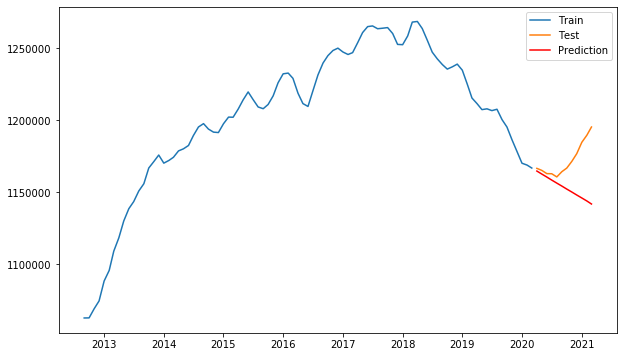

Model Explained Variance       r^2         MAE        RMSE  \
44  Non-seasonal 7632           -151.48%  -441.30%  $18,957.02  $25,907.51   
43      Seasonal 7632           -151.48%  -441.30%  $18,957.02  $25,907.51   
42  Non-seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
41      Seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
40  Non-seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
39      Seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
38  Non-seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
37      Seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
36  Non-seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
35      Seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
34  Non-seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
33      Seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
44   (0, 2, 1)  (1, 0, 0, 12)  1752.63  
43   (0, 2, 1)  (1, 0, 0, 12)  1752.63  
42   (1, 1, 1)  (0, 0, 1, 12)  1504.98  
41   (1, 1, 1)  (0, 0, 1, 12)  1504.98  
40   (0, 2, 0)  (0, 0, 0, 12)  1547.41  
39   (0, 2, 0)  (0, 0, 0, 12)  1547.41  
38   (0, 1, 0)  (0, 0, 0, 12)  1682.51  
37   (0, 1, 0)  (0, 0, 0, 12)  1682.51  
36   (0, 1, 0)  (0, 0, 0, 12)  1567.08  
35   (0, 1, 0)  (

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=1635.274, Time=0.85 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1647.620, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1649.410, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1649.402, Time=0.05 sec
 ARIMA(2,2,2)(0,0,1)[12]             : AIC=1633.671, Time=0.60 sec
 ARIMA(2,2,2)(0,0,0)[12]             : AIC=1652.509, Time=0.13 sec
 ARIMA(2,2,2)(0,0,2)[12]             : AIC=1654.651, Time=0.71 sec
 ARIMA(2,2,2)(1,0,0)[12]             : AIC=1652.684, Time=0.32 sec
 ARIMA(2,2,2)(1,0,2)[12]             : AIC=1636.996, Time=2.07 sec
 ARIMA(1,2,2)(0,0,1)[12]             : AIC=1650.781, Time=0.33 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=1652.411, Time=0.26 sec
 ARIMA(3,2,2)(0,0,1)[12]             : AIC=1661.817, Time=1.18 sec
 ARIMA(2,2,3)(0,0,1)[12]             : AIC=1636.136, Time=0.55 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1652.071, Time=0.09 sec
 ARIMA(1,2,3)(0,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   91
Model:             SARIMAX(2, 2, 2)x(0, 0, [1], 12)   Log Likelihood                -810.835
Date:                              Sun, 30 May 2021   AIC                           1633.671
Time:                                      18:04:41   BIC                           1648.603
Sample:                                           0   HQIC                          1639.689
                                               - 91                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5833      0.034     16.965      0.000       0.516       0.651
ar.L2         -0.9262      0.039    -23.986      0.000      -1.002      -0.851
ma.L1         -0.5905      0.034    -17.278      0.000      -0.658      -0.524
ma.L2          0.9244      0.040     23.318      0.000       0.847       1.002
ma.S.L12      -0.0020      0.004     -0.471      0.637      -0.010       0.006
sigma2      5.198e+06   1.07e-09   4.84e+15      0.000     5.2e+06     5.2e+06
===================================================================================
Ljung-Box (Q):                      183.90   Jarque-Bera (JB):                 1.16
Prob(Q):                              0.00   Prob(JB):                         0.56
Heteroskedasticity (H):               1.53   Skew:                             0.17
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.61e+31. Standard errors may be unstable.
"""

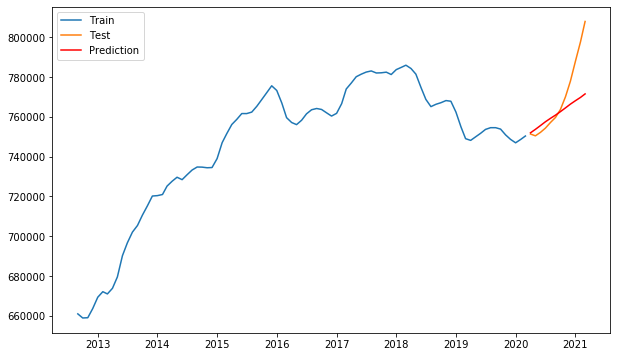

Model Explained Variance       r^2         MAE        RMSE  \
45      Seasonal 7627             51.06%    35.44%   $9,667.19  $15,005.42   
44  Non-seasonal 7632           -151.48%  -441.30%  $18,957.02  $25,907.51   
43      Seasonal 7632           -151.48%  -441.30%  $18,957.02  $25,907.51   
42  Non-seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
41      Seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
40  Non-seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
39      Seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
38  Non-seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
37      Seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
36  Non-seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
35      Seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
34  Non-seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
33      Seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
45   (2, 2, 2)  (0, 0, 1, 12)  1633.67  
44   (0, 2, 1)  (1, 0, 0, 12)  1752.63  
43   (0, 2, 1)  (1, 0, 0, 12)  1752.63  
42   (1, 1, 1)  (0, 0, 1, 12)  1504.98  
41   (1, 1, 1)  (0, 0, 1, 12)  1504.98  
40   (0, 2, 0)  (0, 0, 0, 12)  1547.41  
39   (0, 2, 0)  (0, 0, 0, 12)  1547.41  
38   (0, 1, 0)  (0, 0

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1652.509, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1647.620, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1648.975, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1648.972, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1650.055, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1649.572, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.361 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   91
Model:             SARIMAX(2, 2, 2)x(0, 0, [1], 12)   Log Likelihood                -810.835
Date:                              Sun, 30 May 2021   AIC                           1633.671
Time:                                      18:04:42   BIC                           1648.603
Sample:                                           0   HQIC                          1639.689
                                               - 91                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5833      0.034     16.965      0.000       0.516       0.651
ar.L2         -0.9262      0.039    -23.986      0.000      -1.002      -0.851
ma.L1         -0.5905      0.034    -17.278      0.000      -0.658      -0.524
ma.L2          0.9244      0.040     23.318      0.000       0.847       1.002
ma.S.L12      -0.0020      0.004     -0.471      0.637      -0.010       0.006
sigma2      5.198e+06   1.07e-09   4.84e+15      0.000     5.2e+06     5.2e+06
===================================================================================
Ljung-Box (Q):                      183.90   Jarque-Bera (JB):                 1.16
Prob(Q):                              0.00   Prob(JB):                         0.56
Heteroskedasticity (H):               1.53   Skew:                             0.17
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.61e+31. Standard errors may be unstable.
"""

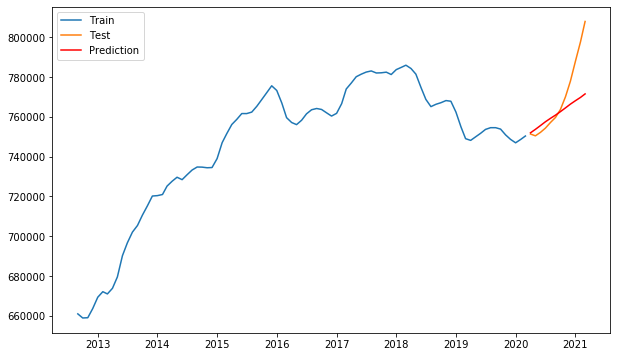

Model Explained Variance       r^2         MAE        RMSE  \
46  Non-seasonal 7627             51.06%    35.44%   $9,667.19  $15,005.42   
45      Seasonal 7627             51.06%    35.44%   $9,667.19  $15,005.42   
44  Non-seasonal 7632           -151.48%  -441.30%  $18,957.02  $25,907.51   
43      Seasonal 7632           -151.48%  -441.30%  $18,957.02  $25,907.51   
42  Non-seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
41      Seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
40  Non-seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
39      Seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
38  Non-seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
37      Seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
36  Non-seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
35      Seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
34  Non-seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
33      Seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
46   (2, 2, 2)  (0, 0, 1, 12)  1633.67  
45   (2, 2, 2)  (0, 0, 1, 12)  1633.67  
44   (0, 2, 1)  (1, 0, 0, 12)  1752.63  
43   (0, 2, 1)  (1, 0, 0, 12)  1752.63  
42   (1, 1, 1)  (0, 0, 1, 12)  1504.98  
41   (1, 1, 1)  (0, 0, 1,

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=1598.849, Time=0.36 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1588.663, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1592.199, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1592.202, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1596.911, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1592.493, Time=0.05 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1599.849, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1590.566, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1590.566, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1592.560, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1590.645, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.749 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -793.331
Date:                Sun, 30 May 2021   AIC                           1588.663
Time:                        18:04:43   BIC                           1591.151
Sample:                             0   HQIC                          1589.666
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.182e+06   4.63e+05      6.876      0.000    2.28e+06    4.09e+06
===================================================================================
Ljung-Box (Q):                       83.55   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.00   Prob(JB):                         0.99
Heteroskedasticity (H):               0.93   Skew:                             0.02
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

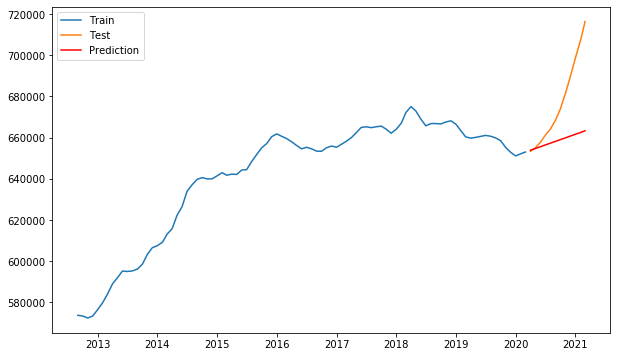

Model Explained Variance       r^2         MAE        RMSE  \
47      Seasonal 7641             26.16%   -57.35%  $18,775.00  $25,665.00   
46  Non-seasonal 7627             51.06%    35.44%   $9,667.19  $15,005.42   
45      Seasonal 7627             51.06%    35.44%   $9,667.19  $15,005.42   
44  Non-seasonal 7632           -151.48%  -441.30%  $18,957.02  $25,907.51   
43      Seasonal 7632           -151.48%  -441.30%  $18,957.02  $25,907.51   
42  Non-seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
41      Seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
40  Non-seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
39      Seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
38  Non-seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
37      Seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
36  Non-seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
35      Seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
34  Non-seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
33      Seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
47   (0, 2, 0)  (0, 0, 0, 12)  1588.66  
46   (2, 2, 2)  (0, 0, 1, 12)  1633.67  
45   (2, 2, 2)  (0, 0, 1, 12)  1633.67  
44   (0, 2, 1)  (1, 0, 0, 12)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1595.172, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1588.663, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1590.566, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1590.566, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1592.560, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1590.645, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.310 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -793.331
Date:                Sun, 30 May 2021   AIC                           1588.663
Time:                        18:04:43   BIC                           1591.151
Sample:                             0   HQIC                          1589.666
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.182e+06   4.63e+05      6.876      0.000    2.28e+06    4.09e+06
===================================================================================
Ljung-Box (Q):                       83.55   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.00   Prob(JB):                         0.99
Heteroskedasticity (H):               0.93   Skew:                             0.02
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

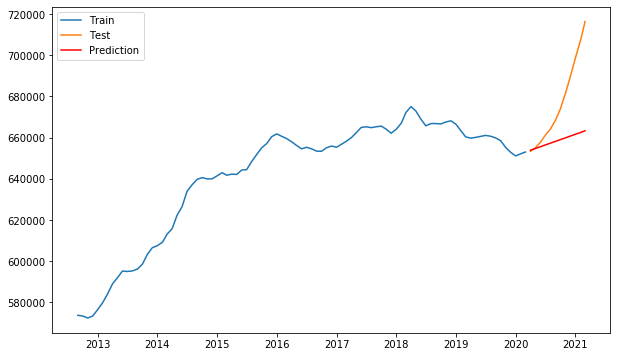

Model Explained Variance       r^2         MAE        RMSE  \
48  Non-seasonal 7641             26.16%   -57.35%  $18,775.00  $25,665.00   
47      Seasonal 7641             26.16%   -57.35%  $18,775.00  $25,665.00   
46  Non-seasonal 7627             51.06%    35.44%   $9,667.19  $15,005.42   
45      Seasonal 7627             51.06%    35.44%   $9,667.19  $15,005.42   
44  Non-seasonal 7632           -151.48%  -441.30%  $18,957.02  $25,907.51   
43      Seasonal 7632           -151.48%  -441.30%  $18,957.02  $25,907.51   
42  Non-seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
41      Seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
40  Non-seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
39      Seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
38  Non-seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
37      Seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
36  Non-seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
35      Seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
34  Non-seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
33      Seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AIC  
48   (0, 2, 0)  (0, 0, 0, 12)  1588.66  
47   (0, 2, 0)  (0, 0, 0, 12)  15

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=1540.126, Time=0.54 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1531.868, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1532.918, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1532.984, Time=0.03 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1543.268, Time=0.02 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1532.240, Time=0.03 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1545.676, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1533.359, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1533.373, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1534.970, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1533.865, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.971 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -764.934
Date:                Sun, 30 May 2021   AIC                           1531.868
Time:                        18:04:44   BIC                           1534.357
Sample:                             0   HQIC                          1532.871
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.709e+06   2.53e+05      6.747      0.000    1.21e+06    2.21e+06
===================================================================================
Ljung-Box (Q):                      139.43   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.00   Prob(JB):                         0.99
Heteroskedasticity (H):               1.21   Skew:                            -0.01
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

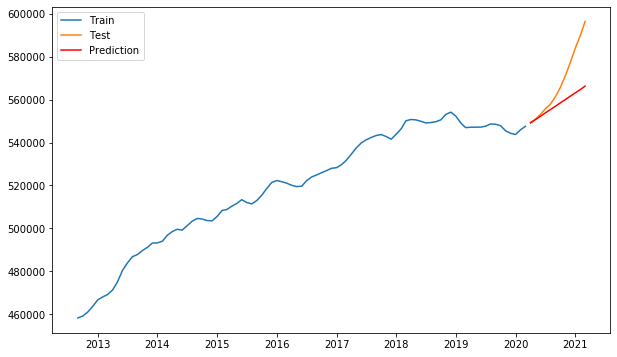

Model Explained Variance       r^2         MAE        RMSE  \
49      Seasonal mean             56.34%    13.26%  $10,069.00  $14,286.58   
48  Non-seasonal 7641             26.16%   -57.35%  $18,775.00  $25,665.00   
47      Seasonal 7641             26.16%   -57.35%  $18,775.00  $25,665.00   
46  Non-seasonal 7627             51.06%    35.44%   $9,667.19  $15,005.42   
45      Seasonal 7627             51.06%    35.44%   $9,667.19  $15,005.42   
44  Non-seasonal 7632           -151.48%  -441.30%  $18,957.02  $25,907.51   
43      Seasonal 7632           -151.48%  -441.30%  $18,957.02  $25,907.51   
42  Non-seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
41      Seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
40  Non-seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
39      Seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
38  Non-seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
37      Seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
36  Non-seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
35      Seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
34  Non-seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
33      Seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.06%   -59.07%  $12,155.19  $15,320.44   

   ARIMA Order Seasonal Order      AI

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1539.044, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1531.868, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1533.359, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1533.373, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1534.970, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1533.865, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.220 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -764.934
Date:                Sun, 30 May 2021   AIC                           1531.868
Time:                        18:04:45   BIC                           1534.357
Sample:                             0   HQIC                          1532.871
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.709e+06   2.53e+05      6.747      0.000    1.21e+06    2.21e+06
===================================================================================
Ljung-Box (Q):                      139.43   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.00   Prob(JB):                         0.99
Heteroskedasticity (H):               1.21   Skew:                            -0.01
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

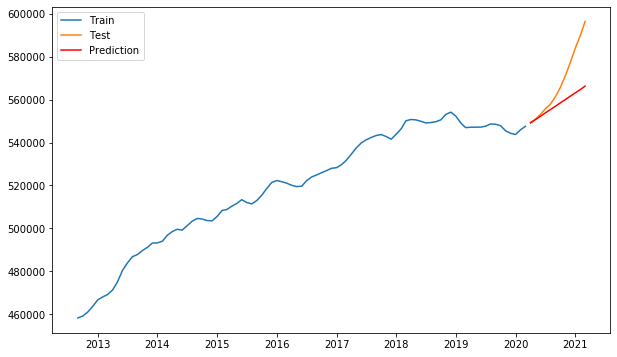

Model Explained Variance       r^2         MAE        RMSE  \
50  Non-seasonal mean             56.34%    13.26%  $10,069.00  $14,286.58   
49      Seasonal mean             56.34%    13.26%  $10,069.00  $14,286.58   
48  Non-seasonal 7641             26.16%   -57.35%  $18,775.00  $25,665.00   
47      Seasonal 7641             26.16%   -57.35%  $18,775.00  $25,665.00   
46  Non-seasonal 7627             51.06%    35.44%   $9,667.19  $15,005.42   
45      Seasonal 7627             51.06%    35.44%   $9,667.19  $15,005.42   
44  Non-seasonal 7632           -151.48%  -441.30%  $18,957.02  $25,907.51   
43      Seasonal 7632           -151.48%  -441.30%  $18,957.02  $25,907.51   
42  Non-seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
41      Seasonal 7662             35.86%   -87.36%  $16,540.30  $20,395.66   
40  Non-seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
39      Seasonal 7630             70.15%    40.96%   $8,972.58  $12,759.96   
38  Non-seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
37      Seasonal 7649             37.27%   -34.96%  $12,816.77  $17,520.03   
36  Non-seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
35      Seasonal 7603             26.86%  -112.61%  $22,793.82  $28,143.16   
34  Non-seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
33      Seasonal 7624             29.77%   -41.75%  $17,285.50  $24,277.02   
32  Non-seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
31      Seasonal 7626             51.47%    28.85%   $8,756.52  $13,636.43   
30  Non-seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
29      Seasonal 7607             31.13%  -110.90%  $19,783.56  $24,107.08   
28  Non-seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
27      Seasonal 7661              4.88%  -152.26%  $18,107.05  $22,941.78   
26  Non-seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
25      Seasonal 7670             51.84%    -5.98%  $13,323.83  $18,038.50   
24  Non-seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
23      Seasonal 7628             46.59%   -12.25%   $9,602.75  $13,263.53   
22  Non-seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
21      Seasonal 7646             41.06%   -59.07%  $12,155.19  $15,320.44   
20  Non-seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
19      Seasonal 7621             52.67%   -20.31%  $10,941.69  $14,048.40   
18  Non-seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
17      Seasonal 7631             44.74%   -87.56%  $14,883.62  $17,721.62   
16  Non-seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
15      Seasonal 7666             41.65%   -65.28%  $13,320.29  $16,560.52   
14  Non-seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
13      Seasonal 7601             43.69%   -83.65%  $14,585.04  $17,515.58   
12  Stats Best Params              5.69%  -146.87%  $15,003.81  $19,086.08   
11        Logged 36mo             76.47%   -58.20%  $19,709.78  $20,858.69   
10        Logged 24mo             62.77%    47.38%  $10,337.96  $11,176.45   
9         Logged 12mo             44.05%   -53.03%  $11,968.21  $15,026.74   
8       1st Diff 36mo             29.36%   -57.94%  $15,495.56  $20,841.99   
7       1st Diff 24mo             30.77%   -59.99%  $14,677.88  $19,488.23   
6       1st Diff 12mo             22.69%   -83.95%  $12,544.34  $16,475.30   
5       2nd Diff 36mo             67.75%    48.86%   $7,329.80  $11,859.02   
4       2nd Diff 24mo             54.80%    12.25%  $10,050.39  $14,432.66   
3       2nd Diff 12mo             40.30%   -40.10%  $10,892.44  $14,378.12   
2                36mo             66.66%    38.33%   $8,827.77  $13,023.85   
1                24mo             54.17%     3.08%  $11,013.03  $15,168.44   
0                12mo             41.0

In [77]:
for column in df.columns:
    ts = df[column]
    train_12mo, test_12mo = model_selection.train_test_split(ts, test_size=12)
  
    # create a model with seasonal considered
    arima = pm.auto_arima(train_12mo, error_action='ignore', trace=True,
                          suppress_warnings=True, maxiter=100, 
                          seasonal=True, m=12)
    arima_eval(f"Seasonal {column}", ts, train_12mo, test_12mo, arima);

    # create a model without seasonal consideration
    arima_seasonal = pm.auto_arima(train_12mo, error_action='ignore', trace=True,
                                   suppress_warnings=True, maxiter=100)
    arima_eval(f"Non-seasonal {column}", ts, train_12mo, test_12mo, arima);

In [78]:
# Because the data has already been "SEASONALLY ADJUSTED" 
# there is no need to run the seasonal adjustment in modeling. 

## AIC vs OOB

In [79]:
# Borrowing example for pmdarima for cross validating scores.

# https://alkaline-ml.com/pmdarima/auto_examples/model_selection/example_cross_validation.html#sphx-glr-auto-examples-model-selection-example-cross-validation-py

# trying AIC vs OOB for information_criteron with pmd cross_val

new_milford_7646_arima_aic = pm.auto_arima(ts, error_action='ignore', trace=True,
                                           suppress_warnings=True, maxiter=100,
                                           information_criterion='aic',
                                           out_of_sample_size=12, scoring='mae',
                                           stepwise=False)

new_milford_7646_arima_oob = pm.auto_arima(ts, error_action='ignore', trace=True,
                                           suppress_warnings=True, maxiter=100,
                                           information_criterion='oob',
                                           out_of_sample_size=12, scoring='mae',
                                           stepwise=False)

cv = model_selection.SlidingWindowForecastCV(window_size=100, step=24, h=1)

model1_cv_scores = model_selection.cross_val_score(
    new_milford_7646_arima_aic, ts, scoring='mean_absolute_error', cv=cv, verbose=2)

model2_cv_scores = model_selection.cross_val_score(
    new_milford_7646_arima_oob, ts, scoring='mean_absolute_error', cv=cv, verbose=2)

print("Model 1 CV scores: {}".format(model1_cv_scores.tolist()))
print("Model 2 CV scores: {}".format(model2_cv_scores.tolist()))

# Pick based on which has a lower MAE error rate
m1_average_error = np.average(model1_cv_scores)
m2_average_error = np.average(model2_cv_scores)
errors = [m1_average_error, m2_average_error]
models = [new_milford_7646_arima_aic, new_milford_7646_arima_oob]

# print out the answer
better_index = np.argmin(errors)  # type: int
print("Lowest average MAE: {} (model{})".format(
    errors[better_index], better_index + 1))
print("Best model: {}".format(models[better_index]))

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1828.788, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1894.561, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1936.965, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1948.023, Time=0.12 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1888.126, Time=0.17 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1898.443, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1852.189, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1903.869, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1914.759, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1925.860, Time=0.50 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1926.177, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1962.210, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1912.400, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1917.888, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1971.052, Time=0.46 sec
 ARIMA(3,1

In [80]:
# will stick with AIC for selection basis

In [81]:
new_milford_7646_arima_aic.oob_ # MAE

13767.701234567552

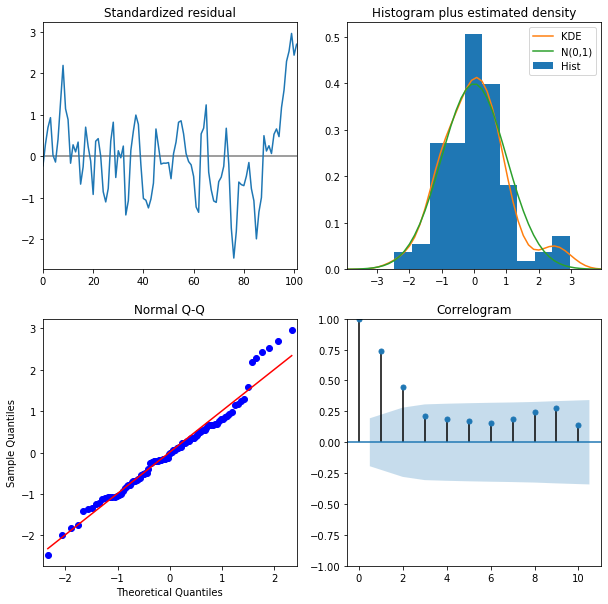

In [82]:
new_milford_7646_arima_aic.plot_diagnostics(figsize=(10, 10));

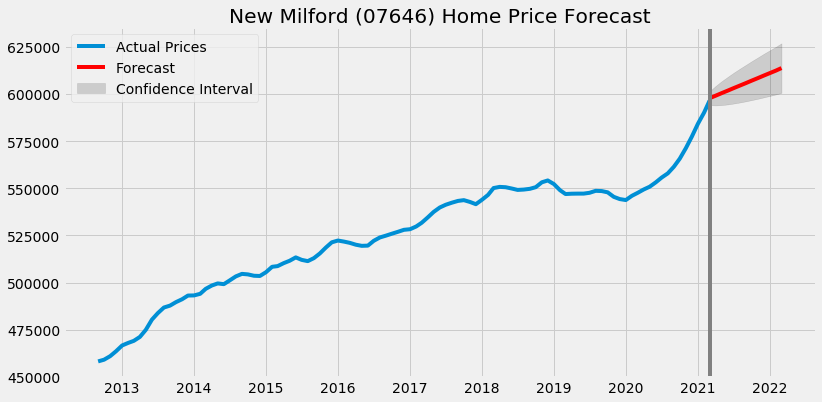

In [83]:
model = new_milford_7646_arima_aic
dti = pd.date_range(ts.index[-1], periods=13, freq="MS") #need to include last date from known dates to get pred

# Forecast
n_periods = 13
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = dti

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,6))
plt.plot(ts, label="Actual Prices")
plt.plot(fc_series, color='red', label="Forecast")
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15, label="Confidence Interval")
plt.axvline(dti[0], color='gray') # show where forecast starts
plt.legend()
plt.title("New Milford (07646) Home Price Forecast")
plt.show()

In [84]:
# calculate growth
growth = (fc[-1]-ts[-1])/ts[-1]*100
print(f"{growth:.2f}%")

2.90%


In [85]:
model.aic()

1828.787998416941

In [86]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  103
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -912.394
Date:                Sun, 30 May 2021   AIC                           1828.788
Time:                        18:04:53   BIC                           1834.038
Sample:                             0   HQIC                          1830.914
                                - 103                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1331.1361    195.333      6.815      0.000     948.290    1713.983
sigma2      3.463e+06   4.36e+05      7.946      0.000    2.61e+06    4.32e+06
===================================================================================
Ljung-Box (Q):                      205.61   Jarque-Bera (JB):                 7.06
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               3.52   Skew:                             0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Replicate For All Zips

### Function to Model & Plot all Zips

In [87]:
## Function to create auto_arima for each zip

def model_zips(df):
    
    '''
    This function will fit an auto-ARIMA model for a dataframe of time series.
    
    ---
    
    Inputs:
    df - dataframe that contains time series for desired zipcodes as columns
    
    Outputs:
    - auto-ARIMA output
    - plot with actual prices, predictions for 12m with confidence intervals
    
    Returns:
    - AIC - list of AIC scores that can be added to df
    - MAE - list of MAE scores that can be added to df
    - price - list of price scores that can be added to df
    - history - list of history scores that can be added to df 
    - growth_pred - list of growth_pred scores that can be added to df
    - lower_confint - list of lower_confint scores that can be added to df
    - upper_confint - list of upper_confint scores that can be added to df
    
    '''

    AIC = []
    MAE = []
    price = []
    history = []
    growth_pred = []
    lower_confint = []
    upper_confint = []


    for column in df:
        # assign column as timeseries
        ts = df[column]

        print(f"Building model for {column}")
        
        # build model
        model = pm.auto_arima(ts, error_action='ignore', trace=True,
                              suppress_warnings=True, maxiter=100,
                              out_of_sample_size=12, scoring='mae',
                              stepwise=False)

        # date range for confidence interval
        dti = pd.date_range(ts.index[-1], periods=13, freq="MS")

        # Forecast
        n_periods = 13
        fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
        index_of_fc = dti

        # make series for plotting purpose
        fc_series = pd.Series(fc, index=index_of_fc)
        lower_series = pd.Series(confint[:, 0], index=index_of_fc)
        upper_series = pd.Series(confint[:, 1], index=index_of_fc)

        # Add AIC
        AIC.append(model.aic())

        # Add MAE
        MAE.append(model.oob_)

        # Calculate Known Prices
        ts_start = ts[0]
        ts_fin = ts[-1]
        price.append(ts_fin)
        
        # Calculate Historical Change
        history_delta = (ts_fin-ts_start)/ts_start*100
        history.append(history_delta)

        # Calculate Predicted Growth
        pred_delta = (fc[-1]-ts_fin)/ts_fin*100
        growth_pred.append(pred_delta)

        # Calculate Lower Confidence Percentage
        lower = (confint[:, 0][-1]-ts_fin)/ts_fin*100
        lower_confint.append(lower)

        # Calculate Lower Confidence Percentage
        upper = (confint[:, 1][-1]-ts_fin)/ts_fin*100
        upper_confint.append(upper)

        print('\n\n')
        print(f"Plotting Predictions for {column}")
        
        # Plot     
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(12,6))
        plt.plot(ts, label="Actual Prices")
        plt.plot(fc_series, color='red', label="Forecast")
        plt.fill_between(lower_series.index, 
                         lower_series, 
                         upper_series, 
                         color='k', alpha=.15, label="Confidence Interval")
        plt.axvline(dti[0], color='gray') # show where forecast starts
        
        
        ax = plt.gca()
        fmt = '${x:,.0f}'
        tick = mtick.StrMethodFormatter(fmt)
        ax.yaxis.set_major_formatter(tick) 
        ax.yaxis.tick_right()
        
        plt.legend()
        plt.title(f"Prediction for {column}")
        plt.show()
        
        print('\n\n\n\n')
        
    return AIC, MAE, price, history, growth_pred, lower_confint, upper_confint

Building model for 7601
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1639.940, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1640.584, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1642.176, Time=0.03 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1652.816, Time=0.04 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1648.581, Time=0.11 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1646.718, Time=0.17 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1640.654, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1644.311, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1644.349, Time=0.05 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1654.290, Time=0.14 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1656.520, Time=0.20 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1642.289, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1644.012, Time=0.14 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=inf, Time=0.31 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=inf, Time=0.37 

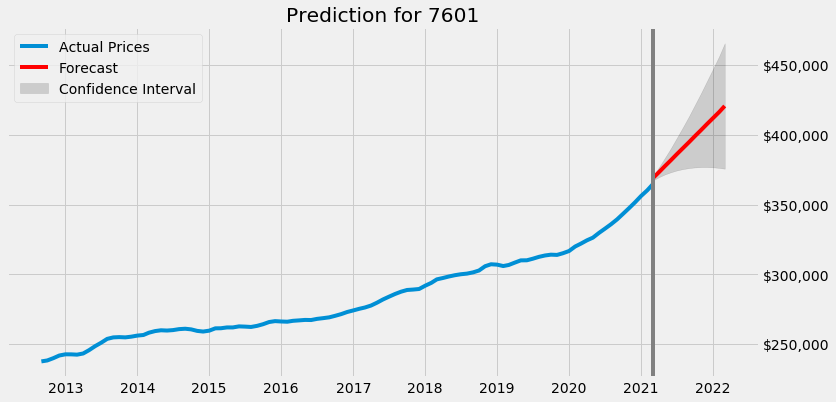






Building model for 7666
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1814.410, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1855.027, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1899.149, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1876.830, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1850.500, Time=0.11 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1851.379, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1900.049, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1870.116, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1876.068, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1824.582, Time=0.24 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1873.348, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1921.940, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1913.715, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1883.900, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, 

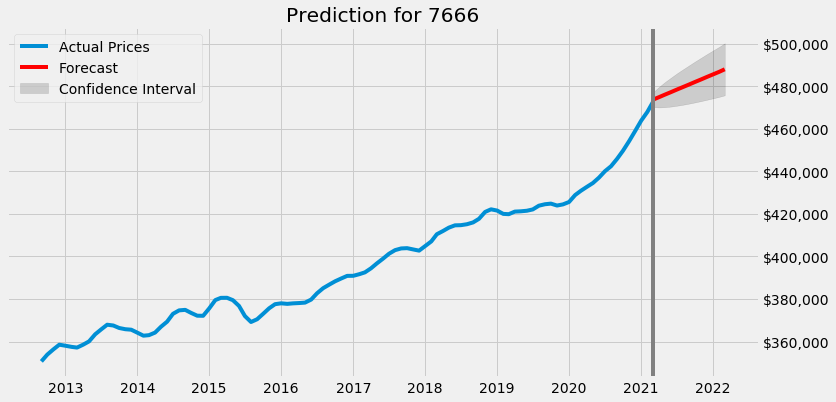






Building model for 7631
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1804.906, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1843.303, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1822.689, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1973.200, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1828.270, Time=0.18 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1968.896, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1814.682, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1888.846, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1813.113, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1813.632, Time=0.31 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1927.466, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1998.631, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1814.178, Time=0.69 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=

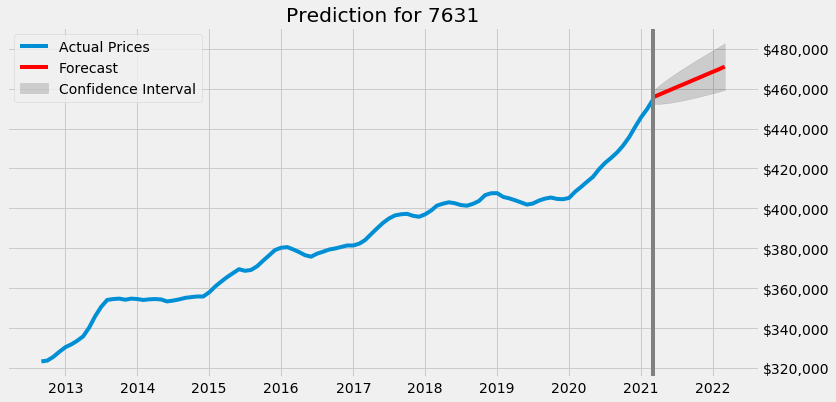






Building model for 7621
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1770.398, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1784.954, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1789.492, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1861.171, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1844.677, Time=0.10 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1848.382, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1883.123, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1807.975, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1787.017, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1835.444, Time=0.14 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1831.724, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1793.041, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1820.566, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1831.120, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1838.

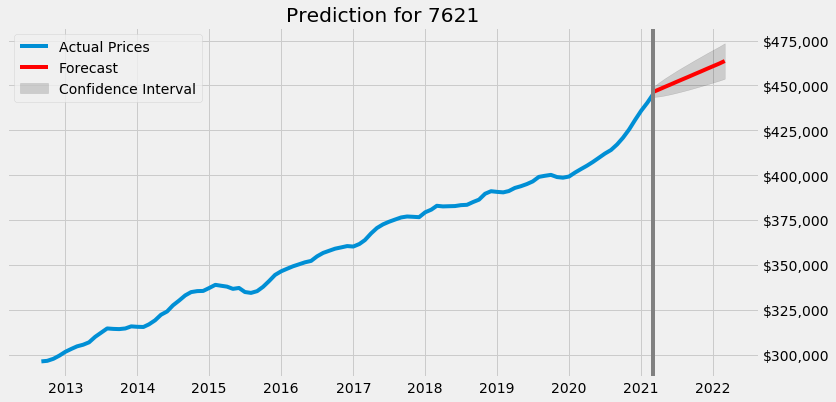






Building model for 7646
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1737.805, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1740.543, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1741.750, Time=0.06 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1743.032, Time=0.29 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1744.466, Time=0.32 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1748.241, Time=0.17 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1740.176, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1741.136, Time=0.21 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1743.305, Time=0.12 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1746.024, Time=0.45 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1747.029, Time=0.61 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1741.612, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1745.579, Time=0.45 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=1745.203, Time=0.18 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=1750.

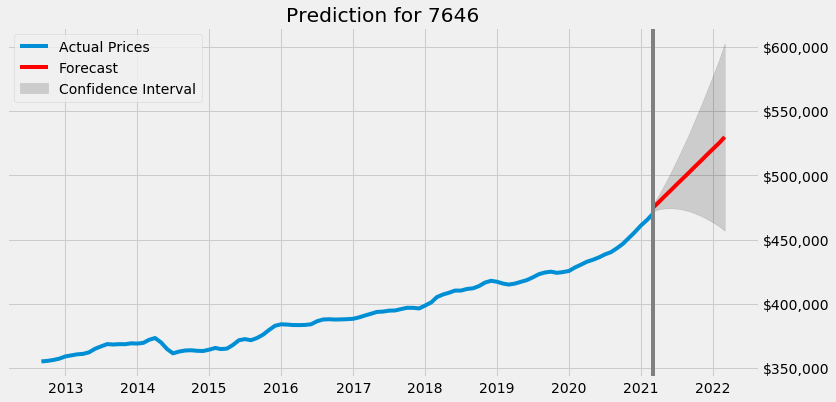






Building model for 7628
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1764.135, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1788.575, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1853.693, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1865.541, Time=0.20 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1822.934, Time=0.19 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1823.100, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1786.039, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1814.482, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1853.409, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1862.063, Time=0.19 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1831.608, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1843.564, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1845.459, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1863.848, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1840.

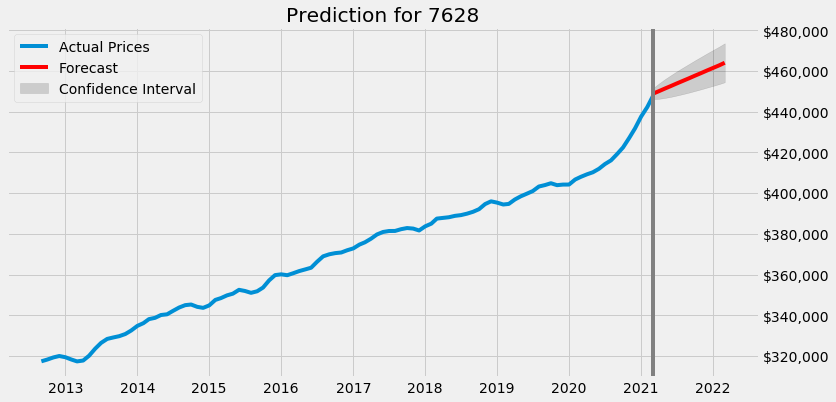






Building model for 7670
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1944.169, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1969.540, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1950.814, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2002.264, Time=0.26 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1982.802, Time=0.21 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=2003.591, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=2015.526, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1964.977, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1976.720, Time=0.42 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2255.742, Time=0.66 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=2062.722, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=2022.998, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1983.162, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2122.224, 

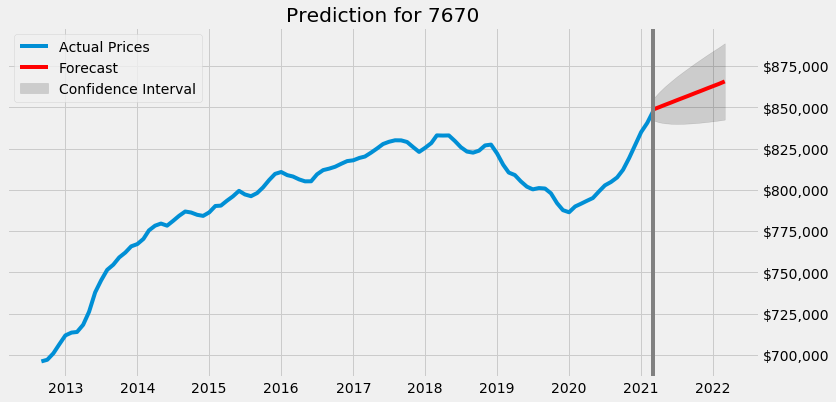






Building model for 7661
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1871.949, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1910.729, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1953.577, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1970.011, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1927.508, Time=0.09 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1946.869, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1943.818, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1871.163, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1932.464, Time=0.43 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1904.194, Time=0.35 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1948.084, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1952.600, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1923.555, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0

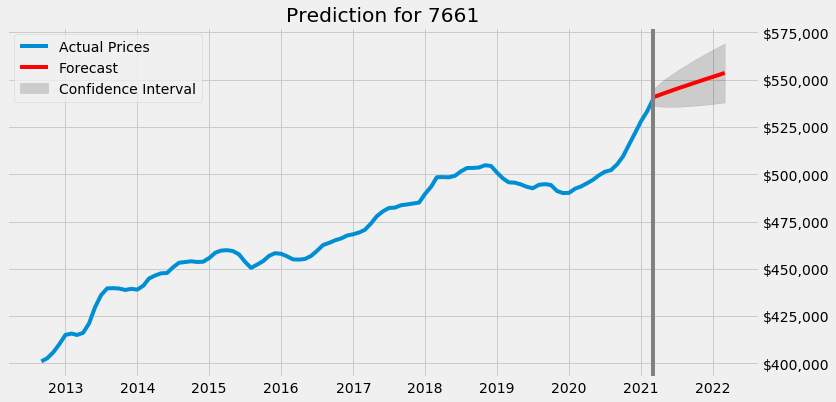






Building model for 7607
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1816.289, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1890.742, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1925.145, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1856.288, Time=0.22 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1894.989, Time=0.12 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1904.312, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1908.193, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1851.298, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1907.444, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1968.329, Time=0.14 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1913.893, Time=0.48 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1908.076, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1853.489, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1873.589, Time=0.50 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1967.

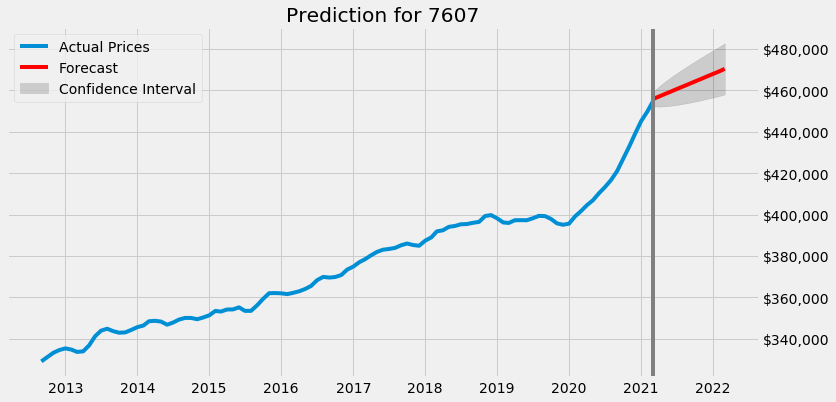






Building model for 7626
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1916.831, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1937.282, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1979.429, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2002.896, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1991.134, Time=0.14 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=2016.275, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1927.567, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1921.663, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1972.661, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1987.189, Time=0.30 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1926.464, Time=0.44 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1978.984, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1950.063, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1974.793, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1985.

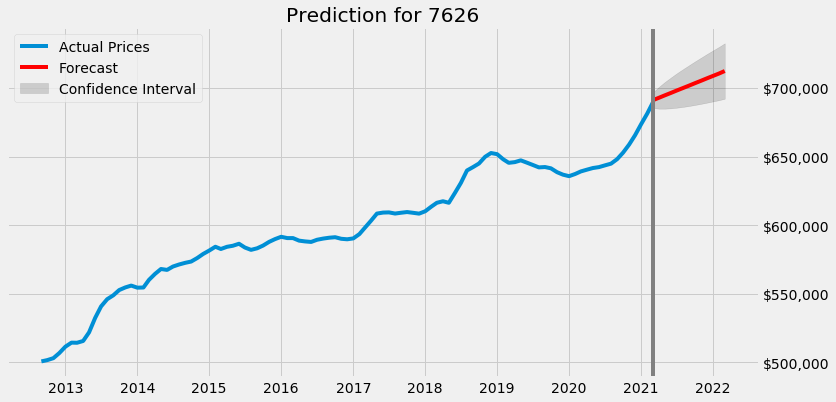






Building model for 7624
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1918.961, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1963.631, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=2002.416, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2007.630, Time=0.12 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=2004.846, Time=0.09 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=2017.675, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=2018.413, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1986.378, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1996.197, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2007.750, Time=0.22 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=2000.635, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=2020.457, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1990.380, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=2000.200, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2009.

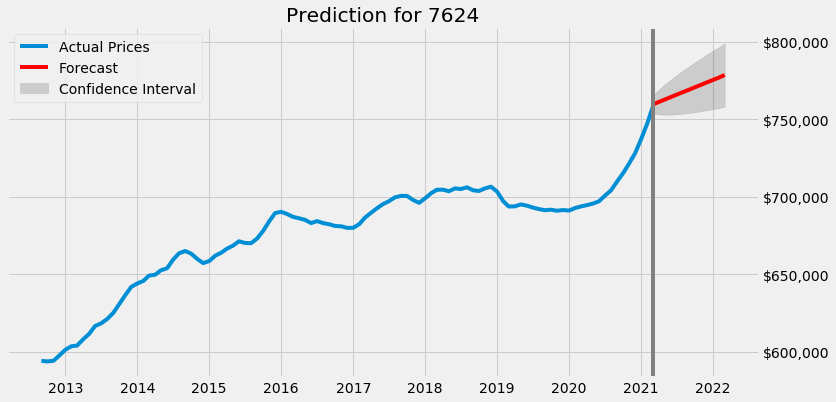






Building model for 7603
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1729.041, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1729.840, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1731.677, Time=0.09 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1739.221, Time=0.07 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1734.874, Time=0.09 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1735.252, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1729.842, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1733.103, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1733.625, Time=0.06 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1741.821, Time=0.05 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1747.406, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1731.761, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1738.223, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=1735.615, Time=0.17 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=1744.

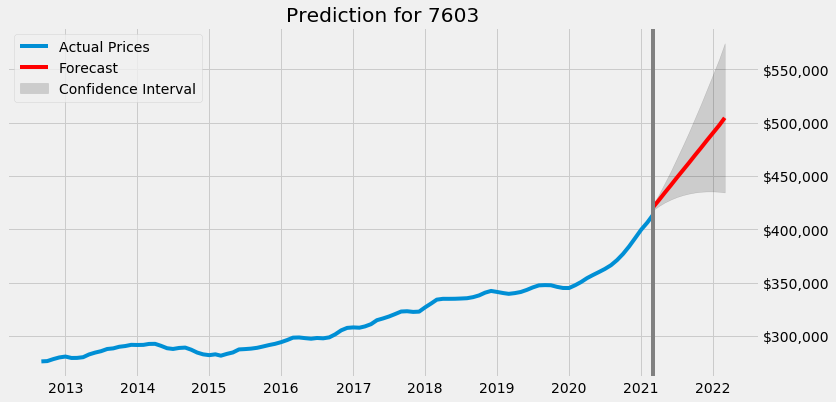






Building model for 7649
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1914.825, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1936.170, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1985.781, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1926.045, Time=0.26 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1982.996, Time=0.20 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1980.042, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1976.871, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1918.471, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1978.147, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1928.709, Time=0.31 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1979.391, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1984.309, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1966.906, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1981.197, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2020.

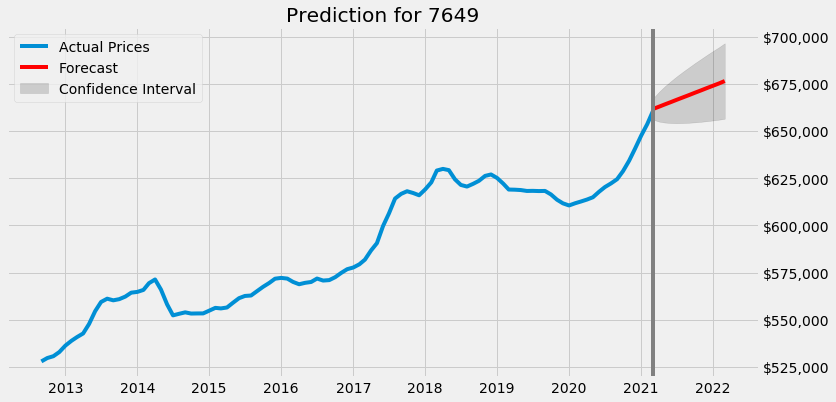






Building model for 7630
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1837.216, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1896.190, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1952.956, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1966.081, Time=0.21 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1895.942, Time=0.10 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1913.399, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1937.992, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1895.613, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1868.114, Time=0.32 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2021.236, Time=0.17 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1944.548, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1932.155, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1926.332, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1886.132, 

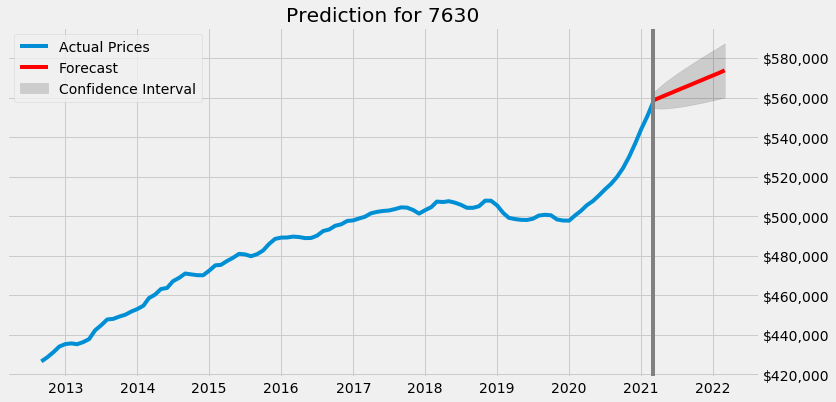






Building model for 7662
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1693.952, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1695.941, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1696.932, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1700.833, Time=0.07 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1701.265, Time=0.15 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1702.395, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1696.134, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1697.356, Time=0.22 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1698.978, Time=0.07 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1702.996, Time=0.06 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1703.820, Time=0.22 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1696.807, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1701.481, Time=0.10 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=1700.256, Time=0.11 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=1704.

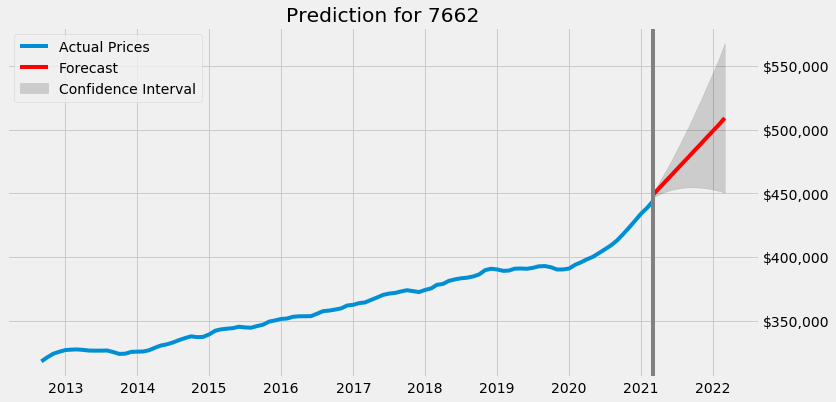






Building model for 7632
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1979.819, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1979.888, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1981.806, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1983.651, Time=0.05 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1981.708, Time=0.18 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1979.580, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1980.154, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1985.737, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1983.798, Time=0.11 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1980.420, Time=0.17 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1982.645, Time=0.34 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1982.201, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1987.402, Time=0.16 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=1980.658, Time=0.13 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=1984.

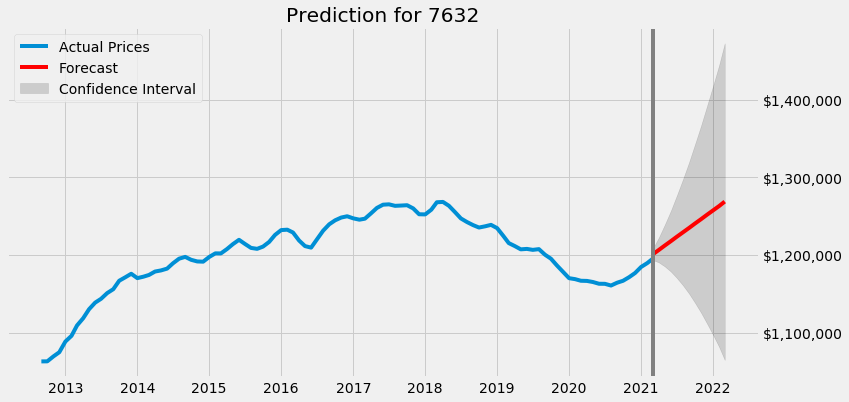






Building model for 7627
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1965.675, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1994.748, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=2048.567, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2049.832, Time=0.18 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=2025.186, Time=0.19 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=2038.294, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=2047.802, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1985.041, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1963.740, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2077.645, Time=0.34 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=2043.620, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=2070.084, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=2048.172, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=2063.983, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2097.

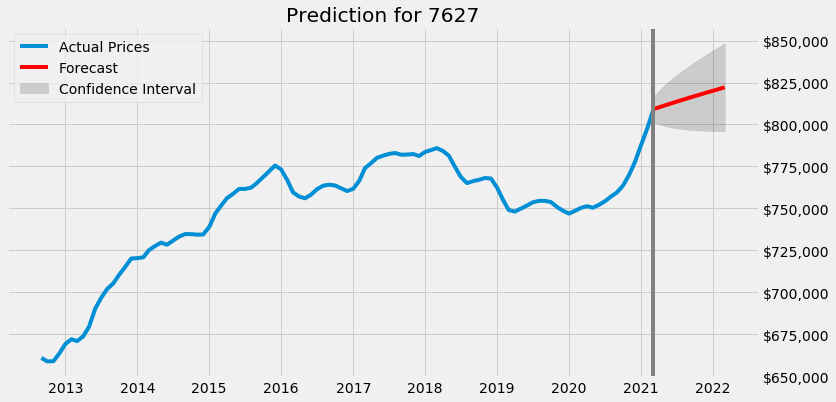






Building model for 7641
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1907.731, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1925.844, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=2002.771, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2002.696, Time=0.07 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=2005.488, Time=0.09 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=2032.544, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=2030.457, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1994.970, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=2002.046, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1997.297, Time=0.13 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1998.696, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=2029.616, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=2004.555, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=

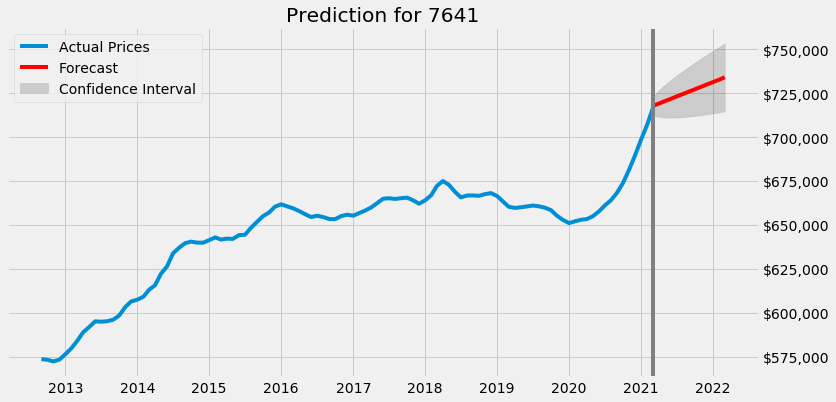






Building model for mean
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1828.788, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1894.561, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1936.965, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1948.023, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1888.126, Time=0.12 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1898.443, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1852.189, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1903.869, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1914.759, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1925.860, Time=0.38 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1926.177, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1962.210, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1912.400, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1917.888, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1971.

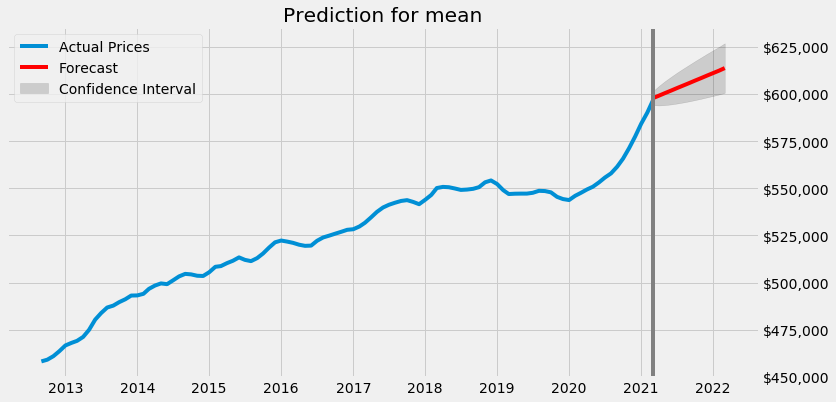

In [88]:
AIC, MAE, price, history, growth_pred, lower_confint, upper_confint = model_zips(df)

### Function to Evaluate All Models

In [89]:
def eval_zips(zips):
    '''
    Create a dataframe to evaluate the results of auto-ARIMA modeling for desired zipcodes
    
    ---
    
    Inputs:
    - zips - list of selected zipcodes
    
    Returns:
    - df_eval - dataframe which contains AIC, MAE, price, history, growth_pred, lower_confint, upper_confint
    
    '''

    # grab necessary identification columns
    id_cols = ['City', 'State', 'RegionName']

    # change RegionName to Zip
    df_eval = df_full[id_cols].rename(columns = {'RegionName':'Zip'})

    # grab selected zips
    df_eval = df_eval[df_eval.Zip.isin(zips)].reset_index(drop=True)

    # create df for mean values
    mean_row = pd.DataFrame([['Mean', 'Mean', 'Mean']], columns=df_eval.columns)

    # add mean value row to main df
    df_eval = df_eval.append(mean_row).reset_index(drop=True)

    # add all evaluations columns
    df_eval['AIC'] = AIC
    df_eval['MAE'] = MAE
    df_eval['Price'] = price
    df_eval['History'] = history
    df_eval['Pred %'] = growth_pred
    df_eval['Lower'] = lower_confint
    df_eval['Higher'] = upper_confint

    return df_eval

In [90]:
df_eval = eval_zips(selected_zipcodes)
df_eval.sort_values(by=['History','Pred %'], 
                        ascending=False).style.format({'AIC':'{:,.2f}',
                                                       'MAE':'{:,.2f}',
                                                       'Price':'${:,.2f}',
                                                       'History':'{:,.2f}%',
                                                       'Pred %':'{:,.2f}%',
                                                       'Lower':'{:,.2f}%',
                                                       'Higher':'{:,.2f}%'
                                                       }).background_gradient(cmap=cm)

## More Zips

In [91]:
# All Bergen County Zips
more_zips = list(df_more.RegionName)
df_more_zips_full = df_zip[df_zip.Zip.isin(more_zips)].reset_index(drop=True)
df_more_zips_full = df_more_zips_full.set_index('Zip')
df_more_zips_full.index.name = None
df_more_zips_full = df_more_zips_full.T
df_more_zips_full.index = pd.to_datetime(df_more_zips_full.index)

# Factor In Housing Crash
df_more_zips_full['mean'] = df_more_zips_full.mean(axis=1)
df_more_zips = df_more_zips_full[(df_more_zips_full.index >= '2012-09-01')]

Building model for 7024
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1794.188, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1816.115, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1841.495, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1860.134, Time=0.16 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1820.868, Time=0.09 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1824.879, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1834.444, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1814.202, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1833.442, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1801.704, Time=0.22 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1852.782, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1839.178, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1799.611, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1790.075, Time=0.47 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=

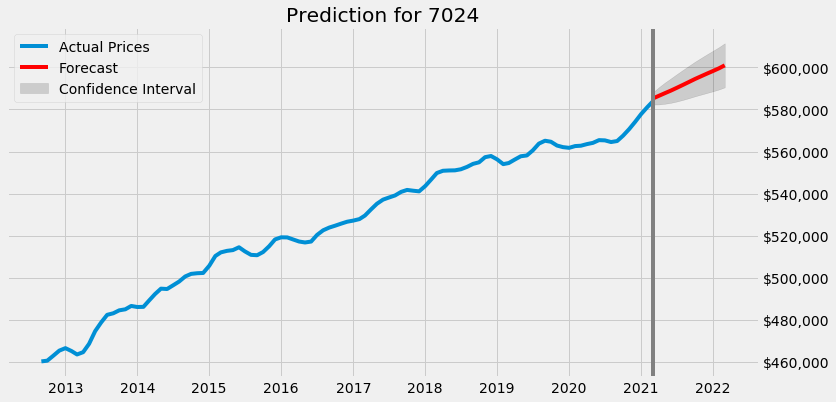






Building model for 7601
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1639.940, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1640.584, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1642.176, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1652.816, Time=0.04 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1648.581, Time=0.11 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1646.718, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1640.654, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1644.311, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1644.349, Time=0.04 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1654.290, Time=0.13 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1656.520, Time=0.19 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1642.289, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1644.012, Time=0.14 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=inf, Time=0.32 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=inf, Time=

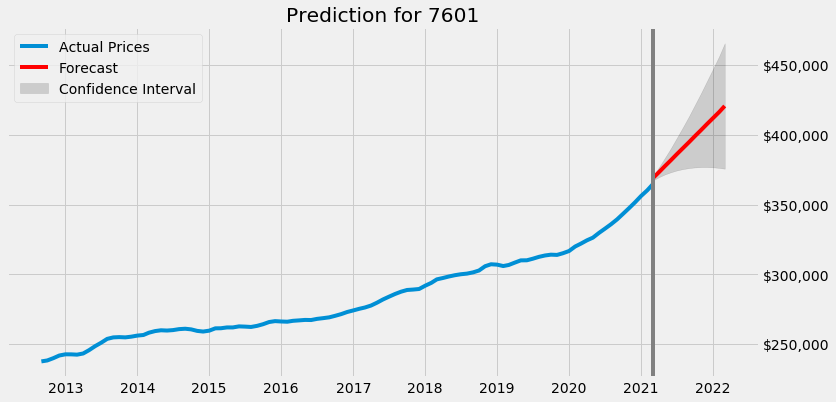






Building model for 7666
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1814.410, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1855.027, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1899.149, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1876.830, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1850.500, Time=0.08 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1851.379, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1900.049, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1870.116, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1876.068, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1824.582, Time=0.25 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1873.348, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1921.940, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1913.715, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1883.900, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, 

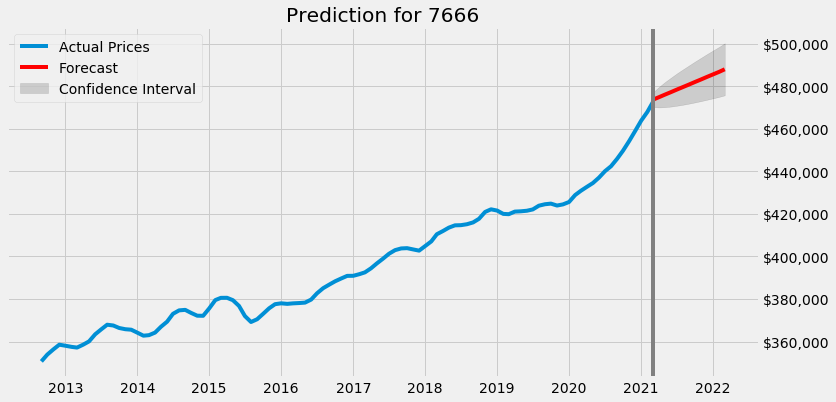






Building model for 7410
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1817.917, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1825.766, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1867.151, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1866.617, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1847.178, Time=0.13 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1848.166, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1829.644, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1820.955, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1848.178, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1861.528, Time=0.13 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1847.288, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1872.300, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1848.872, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1854.161, Time=0.26 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1864.

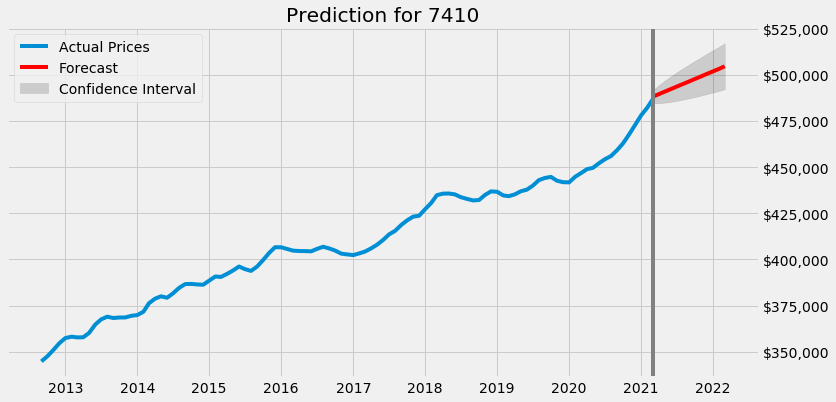






Building model for 7631
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1804.906, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1843.303, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1822.689, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1973.200, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1828.270, Time=0.21 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1968.896, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1814.682, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1888.846, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1813.113, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1813.632, Time=0.36 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1927.466, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1998.631, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1814.178, Time=0.75 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=

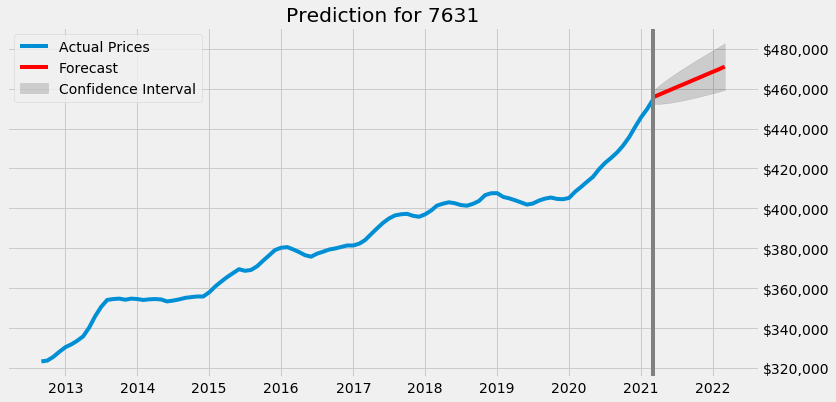






Building model for 7026
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1734.447, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1734.199, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1735.199, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1740.800, Time=0.09 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1739.975, Time=0.09 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1739.028, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1734.227, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1735.517, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1737.199, Time=0.12 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1741.994, Time=0.32 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1740.846, Time=0.36 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1735.085, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1743.301, Time=0.22 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=inf, Time=0.66 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=inf, Time=

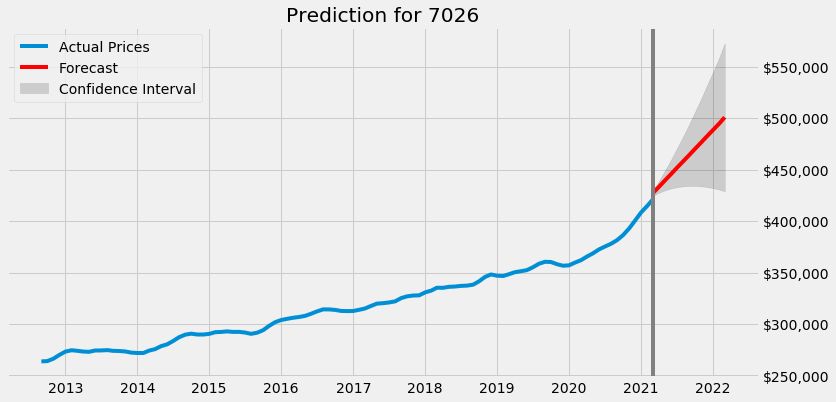






Building model for 7010
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1800.887, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1819.565, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1842.791, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1842.191, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1835.241, Time=0.12 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1836.229, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1814.040, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1824.598, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1806.321, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1849.033, Time=0.12 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1833.742, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1859.863, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1832.590, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1806.440, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1822.

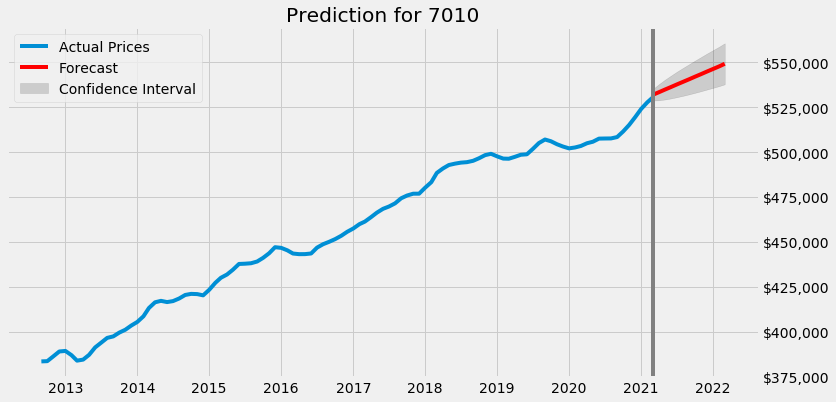






Building model for 7675
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1843.497, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1880.027, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1911.442, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1919.447, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1892.500, Time=0.25 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1923.447, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1922.460, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1886.763, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1898.862, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1921.304, Time=0.14 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1907.246, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1920.304, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1897.289, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1898.748, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1918.

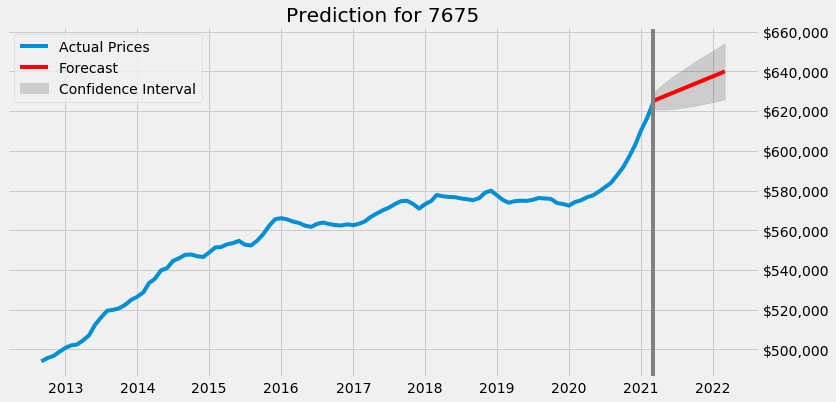






Building model for 7430
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1820.192, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1855.977, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1887.749, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1912.418, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1878.983, Time=0.09 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1894.667, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1832.912, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1842.215, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1873.794, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1902.390, Time=0.21 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1875.218, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1887.531, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1860.405, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1873.288, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1897.

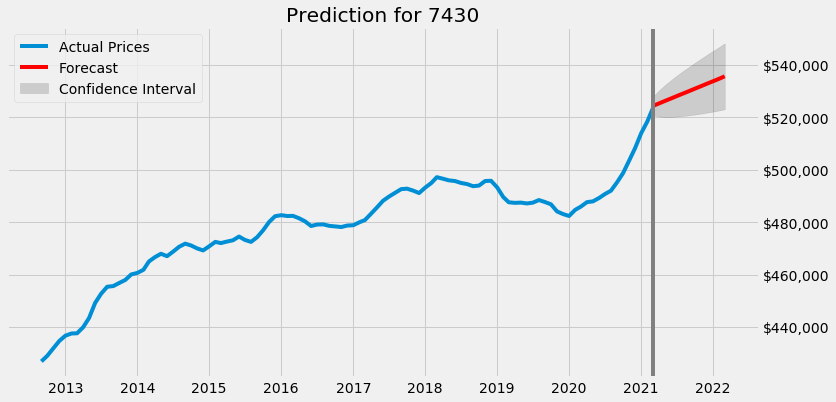






Building model for 7621
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1770.398, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1784.954, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1789.492, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1861.171, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1844.677, Time=0.09 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1848.382, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1883.123, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1807.975, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1787.017, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1835.444, Time=0.14 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1831.724, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1793.041, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1820.566, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1831.120, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1838.

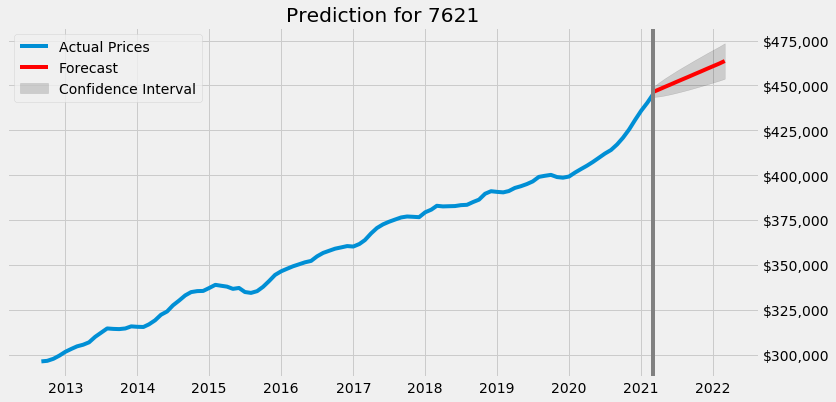






Building model for 7644
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1681.145, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1683.219, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1684.406, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1689.045, Time=0.05 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1688.235, Time=0.09 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1690.761, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1683.241, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1685.305, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1686.398, Time=0.15 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1690.531, Time=0.19 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1694.353, Time=0.23 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1684.372, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1688.834, Time=0.09 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=1687.354, Time=0.11 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=1693.

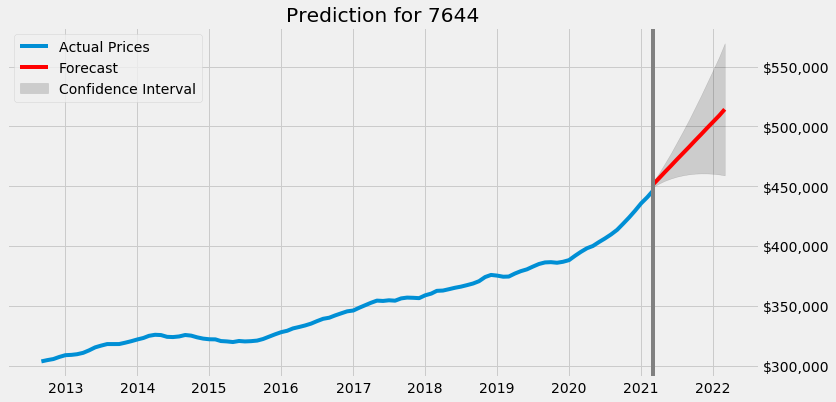






Building model for 7652
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1914.877, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1959.341, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=2005.679, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2060.010, Time=0.15 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1979.558, Time=0.08 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1992.901, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1995.497, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1960.021, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1935.510, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2044.520, Time=0.18 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1990.581, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1991.841, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1975.635, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1986.760, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2050.

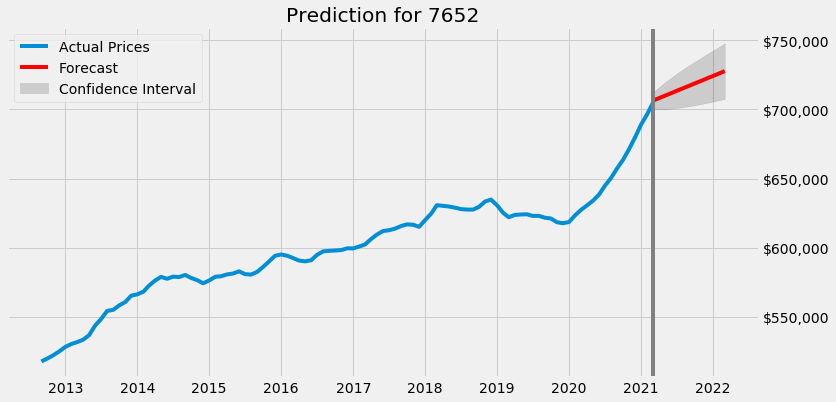






Building model for 7450
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1924.073, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1958.310, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1976.206, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1992.620, Time=0.10 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1960.902, Time=0.12 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1969.912, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1966.639, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1944.842, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1959.415, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2001.350, Time=0.22 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1959.669, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1978.025, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1959.239, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2004.186, 

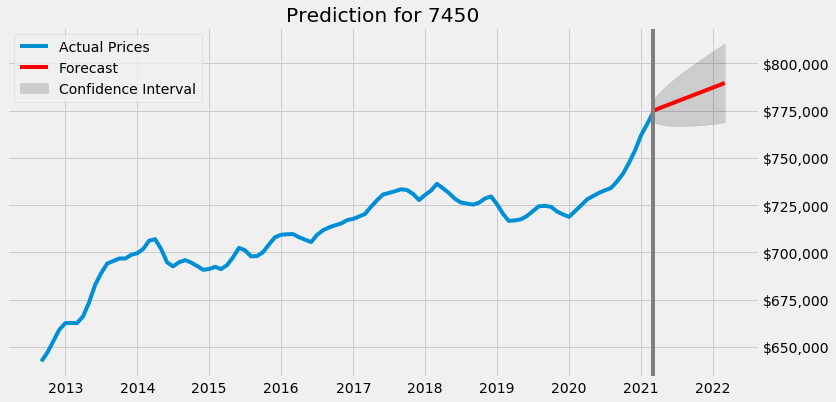






Building model for 7071
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1799.066, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1872.835, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1824.038, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1825.600, Time=0.15 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1863.557, Time=0.09 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1866.096, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1821.985, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1818.278, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1905.650, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1919.909, Time=0.16 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1821.218, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1922.558, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1820.894, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1887.387, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, 

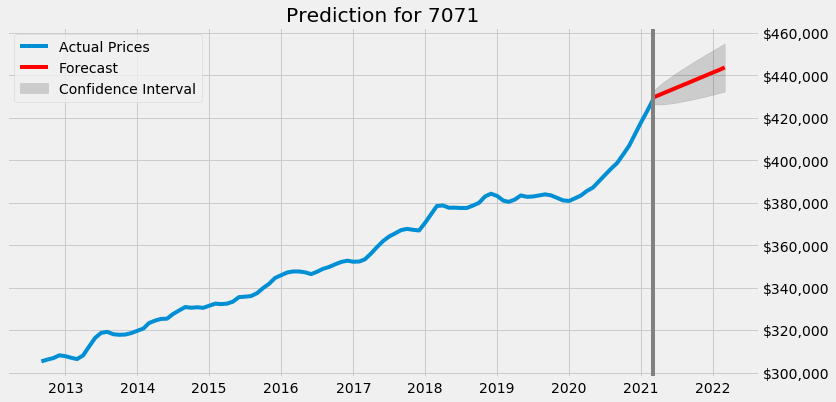






Building model for 7407
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1707.161, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1705.410, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1707.249, Time=0.03 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1713.688, Time=0.09 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1709.627, Time=0.09 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1709.496, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1705.403, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1706.805, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1709.236, Time=0.06 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1716.570, Time=0.16 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1711.998, Time=0.18 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1707.289, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1717.091, Time=0.08 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=1710.734, Time=0.08 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=1717.

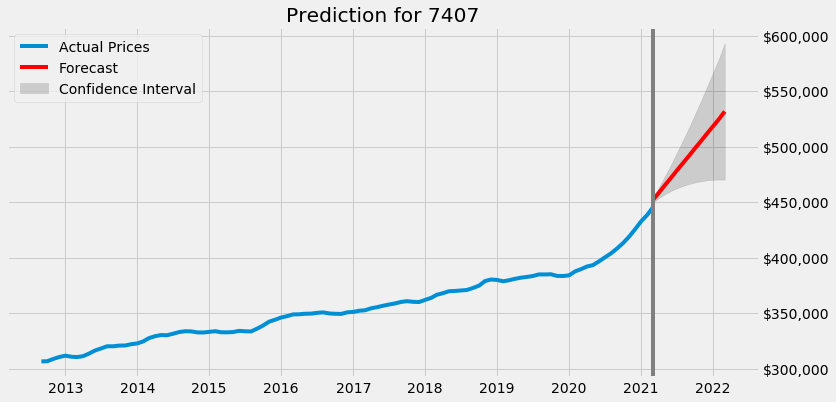






Building model for 7020
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1852.631, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1868.229, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1858.338, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1883.051, Time=0.07 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1877.926, Time=0.07 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1879.061, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1898.125, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1857.050, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1859.036, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1880.885, Time=0.53 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1926.226, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1860.306, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1916.229, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1877.035, Time=0.57 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, 

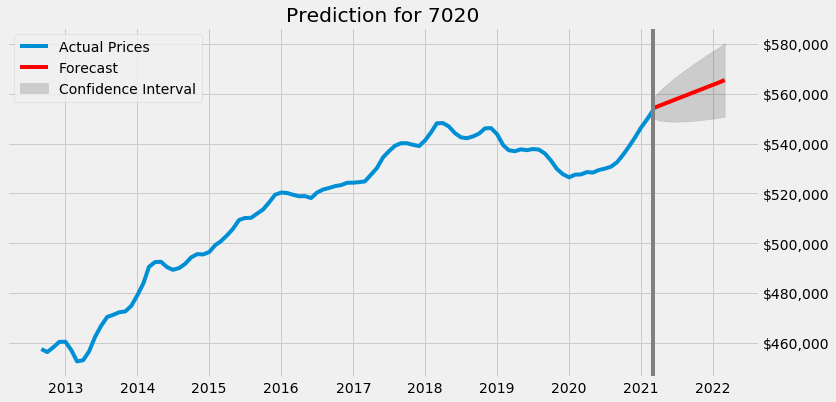






Building model for 7070
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1827.139, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1848.117, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1833.893, Time=0.32 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1906.666, Time=0.32 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1885.899, Time=0.54 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1874.095, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1844.524, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1847.320, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1878.898, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1831.767, Time=0.30 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1832.556, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1897.993, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1862.383, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1856.400, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, 

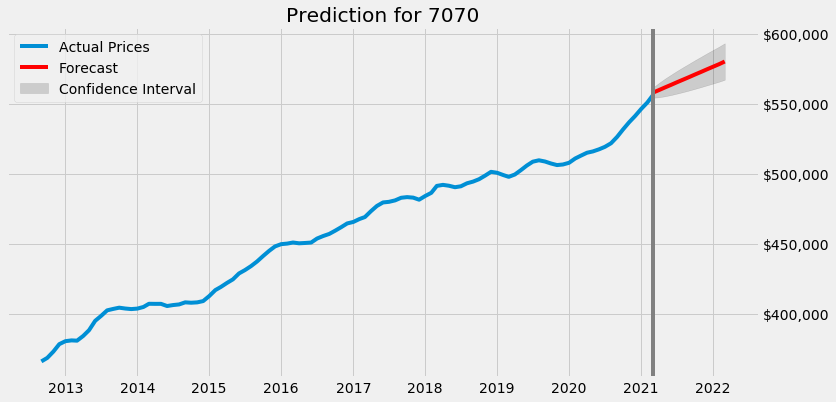






Building model for 7650
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1903.662, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1930.174, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1951.159, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1957.509, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1938.901, Time=0.26 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1945.420, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1964.698, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1908.315, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1948.987, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1987.348, Time=0.32 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1967.370, Time=0.46 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1968.513, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1946.266, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1900.201, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1890.

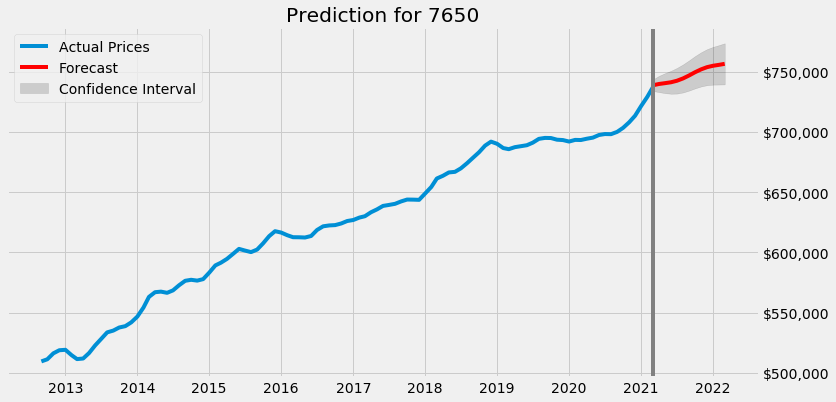






Building model for 7646
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1737.805, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1740.543, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1741.750, Time=0.05 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1743.032, Time=0.11 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1744.466, Time=0.13 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1748.241, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1740.176, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1741.136, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1743.305, Time=0.05 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1746.024, Time=0.12 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1747.029, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1741.612, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1745.579, Time=0.16 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=1745.203, Time=0.12 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=1750.

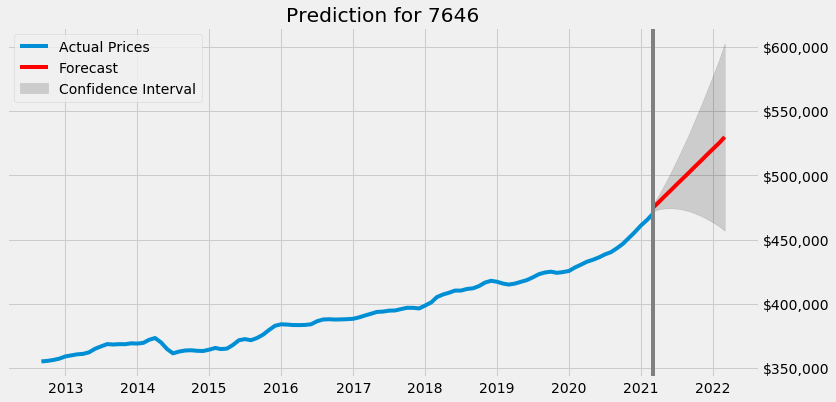






Building model for 7628
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1764.135, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1788.575, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1853.693, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1865.541, Time=0.10 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1822.934, Time=0.08 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1823.100, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1786.039, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1814.482, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1853.409, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1862.063, Time=0.24 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1831.608, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1843.564, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1845.459, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1863.848, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1840.

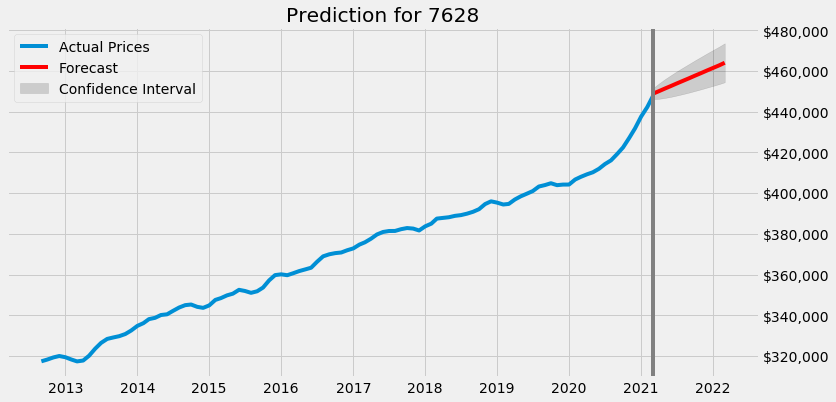






Building model for 7031
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1781.341, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1812.166, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1864.255, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1891.048, Time=0.10 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1843.529, Time=0.11 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1841.034, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1797.432, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1806.342, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1854.260, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1865.985, Time=0.55 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1831.579, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1843.630, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1791.987, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1842.483, 

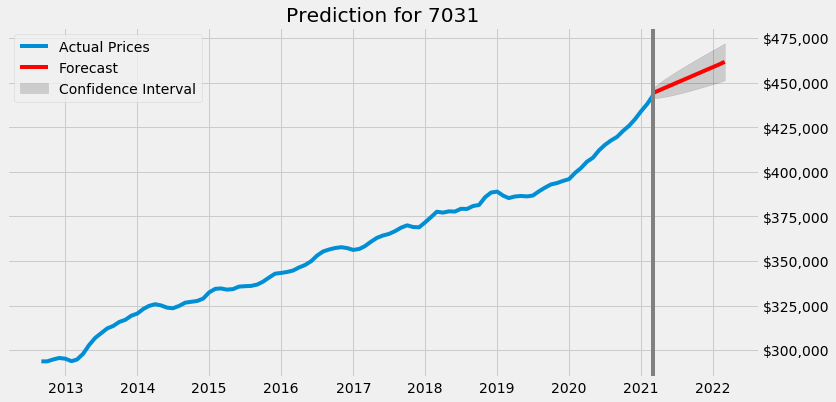






Building model for 7481
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1924.368, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1967.672, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1985.424, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2021.871, Time=0.15 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1992.608, Time=0.24 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1999.813, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1996.108, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1947.649, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1948.881, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2024.523, Time=0.24 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=2000.629, Time=0.42 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1992.680, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1948.460, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2033.966, 

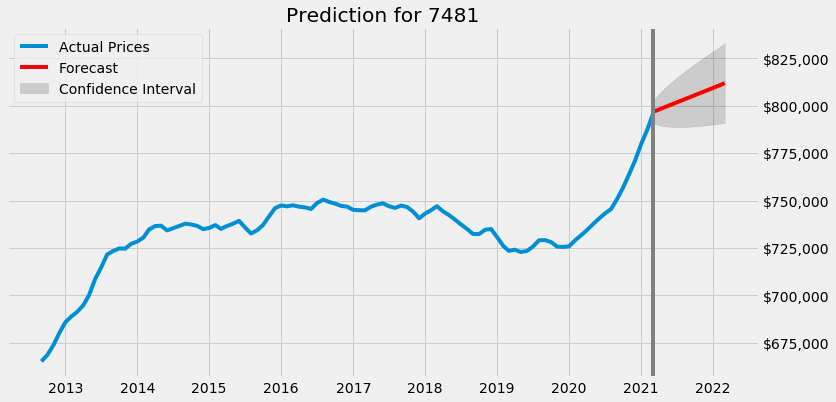






Building model for 7446
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1903.179, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1920.311, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1951.317, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1952.852, Time=0.15 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1923.908, Time=0.23 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1928.043, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1945.848, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1929.917, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1943.877, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1924.313, Time=0.50 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1938.968, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1954.271, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1943.753, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1947.986, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1972.

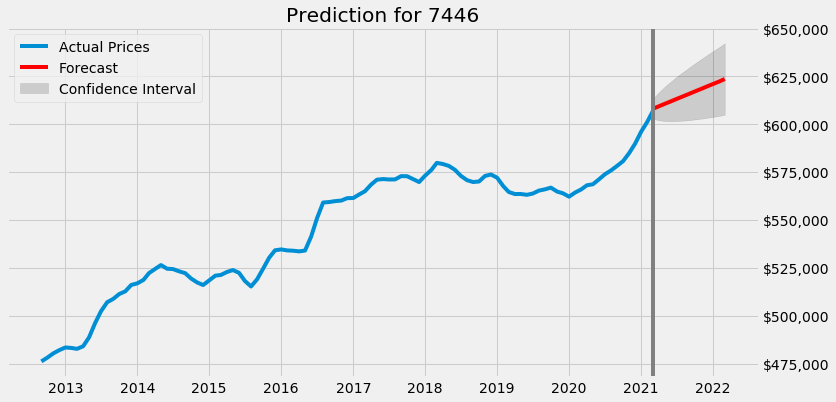






Building model for 7663
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1744.424, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1747.071, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1748.673, Time=0.05 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1753.258, Time=0.05 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1752.093, Time=0.13 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1758.310, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1746.652, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1748.290, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1750.432, Time=0.05 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1755.391, Time=0.13 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1756.967, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1748.194, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=inf, Time=0.12 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=inf, Time=0.49 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=1758.655, Time=

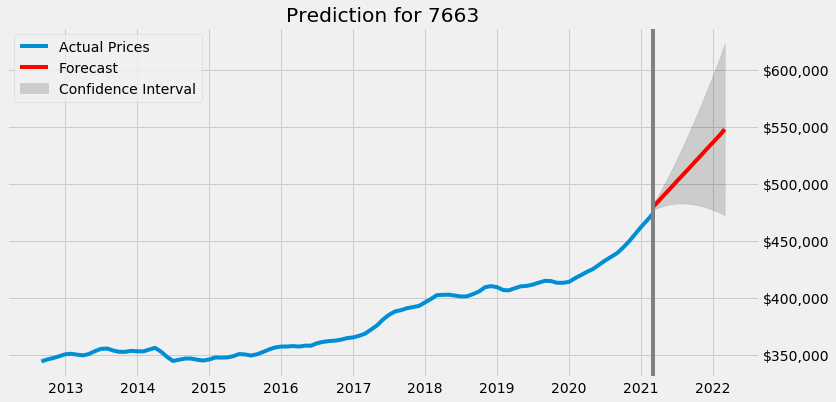






Building model for 7670
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1944.169, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1969.540, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1950.814, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2002.264, Time=0.28 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1982.802, Time=0.24 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=2003.591, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=2015.526, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1964.977, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1976.720, Time=0.45 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2255.742, Time=0.62 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=2062.722, Time=0.54 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=2022.998, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1983.162, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2122.224, 

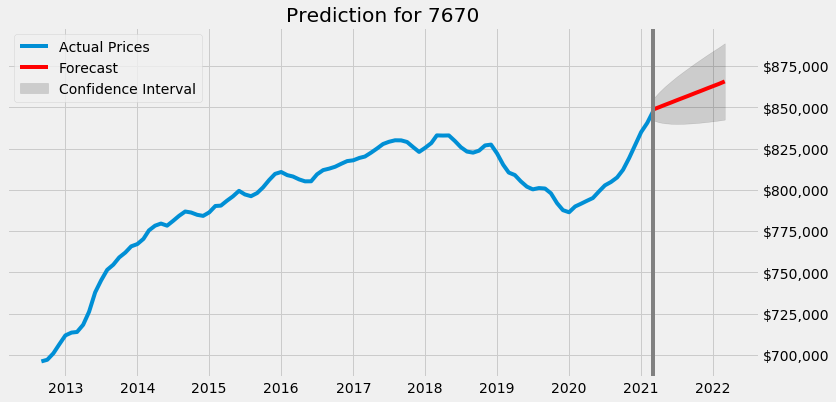






Building model for 7660
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1768.945, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1770.818, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1772.730, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1778.839, Time=0.05 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1779.792, Time=0.13 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1778.704, Time=0.18 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1770.799, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1772.798, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1774.235, Time=0.15 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1775.537, Time=0.22 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1782.265, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1772.761, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=inf, Time=0.27 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=1776.875, Time=0.06 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=inf, Time=

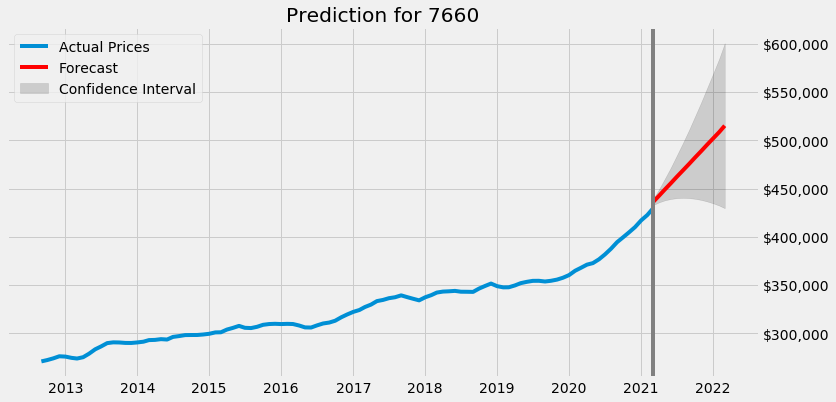






Building model for 7022
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1832.889, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1888.853, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1851.048, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1943.334, Time=0.10 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1907.313, Time=0.11 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1902.400, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1854.115, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1889.257, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1849.236, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1849.236, Time=0.33 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1848.690, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1937.991, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1900.119, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1921.072, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1937.

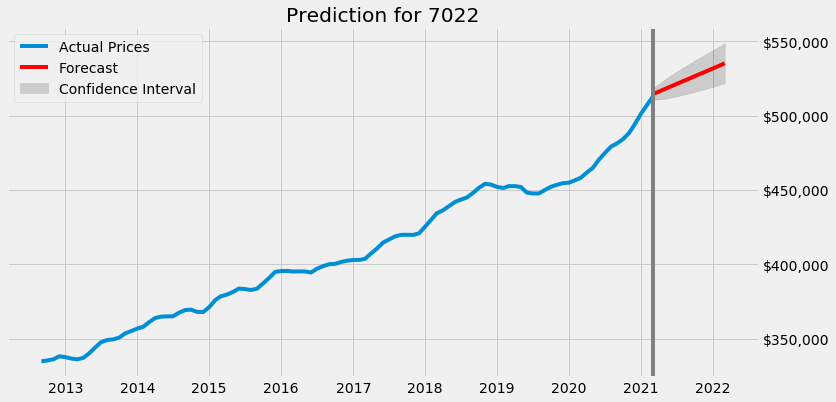






Building model for 7604
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1748.312, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1750.963, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1752.177, Time=0.03 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1762.421, Time=0.09 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1762.679, Time=0.08 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1764.600, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1750.662, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1753.521, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1754.176, Time=0.04 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1764.191, Time=0.15 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1764.830, Time=0.18 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1752.673, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1759.048, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=1756.168, Time=0.09 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=1767.

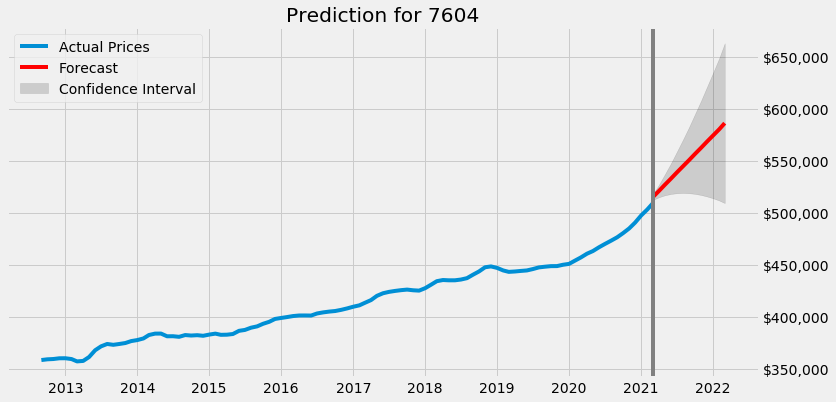






Building model for 7436
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1826.504, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1898.484, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1949.099, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1963.653, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1917.778, Time=0.10 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1943.011, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1856.451, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1898.609, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1856.559, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1948.084, Time=0.15 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1911.565, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1936.384, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1856.620, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1911.043, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1959.

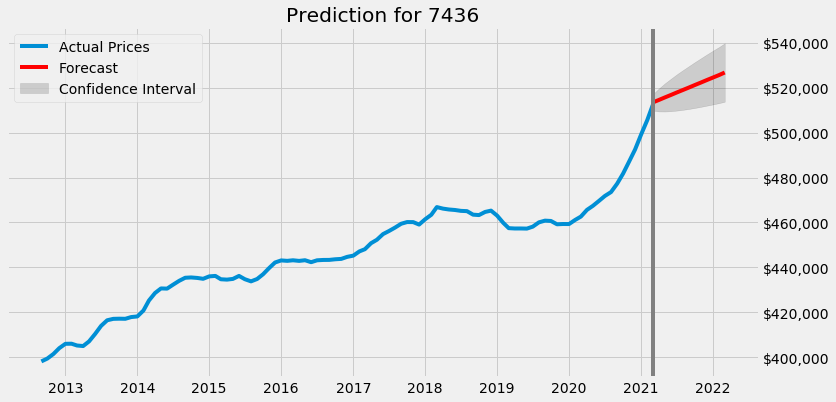






Building model for 7057
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1777.197, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1779.415, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1781.036, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1790.779, Time=0.04 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1787.305, Time=0.09 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1799.565, Time=0.15 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1779.081, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1781.077, Time=0.26 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1783.157, Time=0.06 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=inf, Time=0.19 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1787.195, Time=0.29 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1782.981, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1803.873, Time=0.06 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=1760.331, Time=0.22 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=inf, Time=

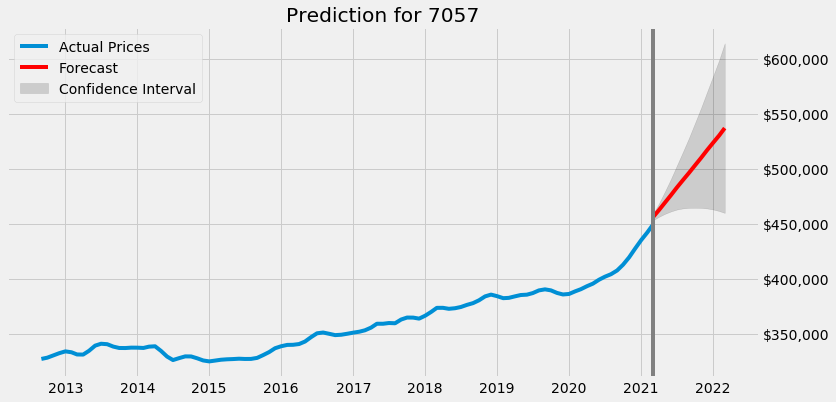






Building model for 7458
 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=2400.565, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=2042.401, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=1978.884, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1945.391, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=1942.354, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1903.413, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(3,0,0)(0,0,0)[1] in

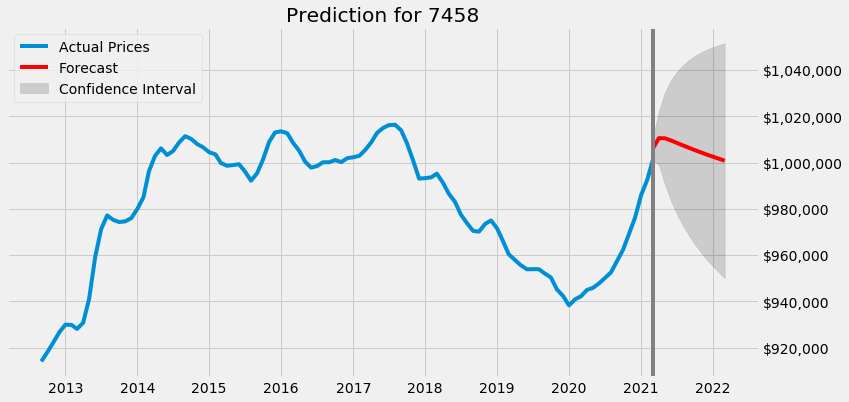






Building model for 7661
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1871.949, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1910.729, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1953.577, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1970.011, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1927.508, Time=0.09 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1946.869, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1943.818, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1871.163, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1932.464, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1904.194, Time=0.34 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1948.084, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1952.600, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1923.555, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0

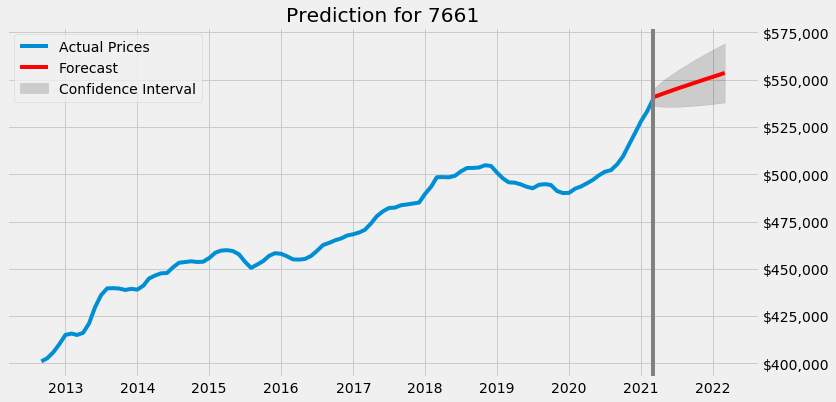






Building model for 7643
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1742.714, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1744.998, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1746.233, Time=0.03 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1752.236, Time=0.07 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1750.052, Time=0.08 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1751.611, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1744.720, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1746.545, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1748.111, Time=0.10 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1757.203, Time=0.16 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1754.619, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1746.090, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1749.456, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=1742.636, Time=0.32 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=1749.

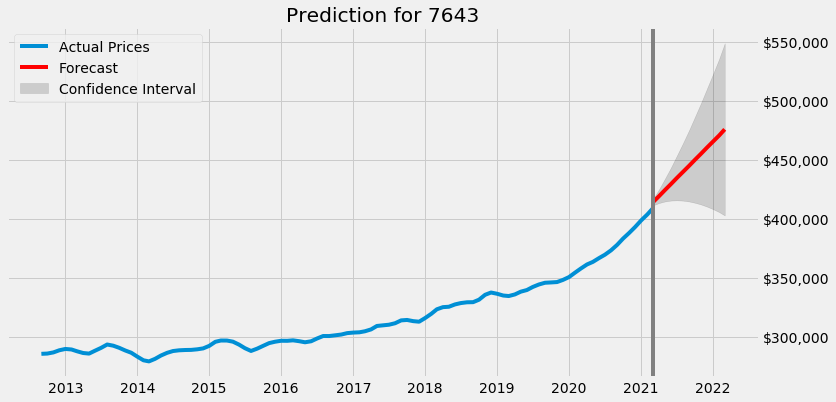






Building model for 7073
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1771.210, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1772.960, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1774.507, Time=0.06 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1781.697, Time=0.05 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1781.194, Time=0.19 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1781.704, Time=0.15 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1772.931, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1775.971, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1776.375, Time=0.06 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1783.879, Time=0.08 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1783.947, Time=0.20 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1774.424, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1780.472, Time=0.17 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=1778.298, Time=0.14 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=1787.

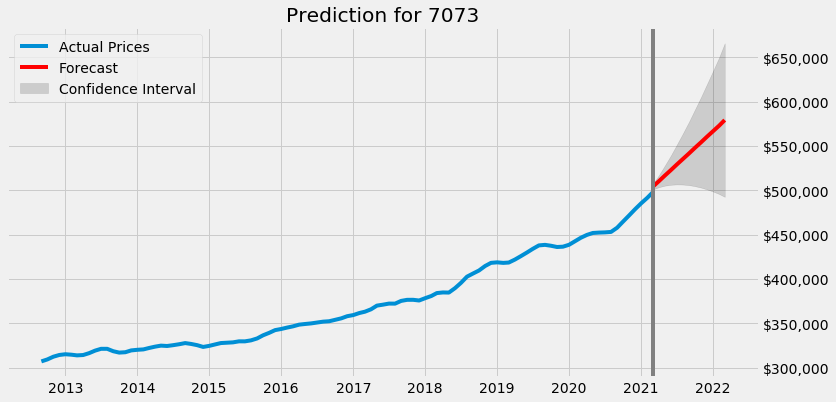






Building model for 7075
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1863.834, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1902.855, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1947.198, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1965.594, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1933.064, Time=0.18 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1918.793, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1918.833, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1873.596, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1875.930, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1947.821, Time=0.23 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1928.408, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1939.573, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1928.823, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=

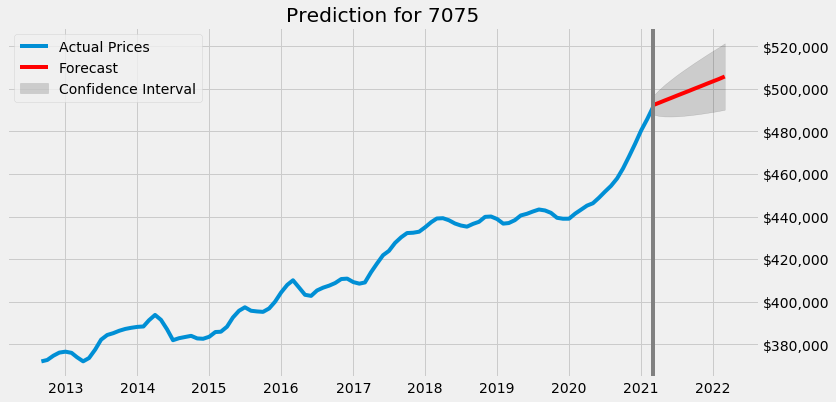






Building model for 7452
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1886.066, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1908.793, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1893.107, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1893.689, Time=0.20 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1912.120, Time=0.15 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1924.667, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1958.659, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1892.232, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1889.243, Time=0.32 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1969.658, Time=0.16 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1931.864, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1954.337, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1927.480, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1925.525, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1974.

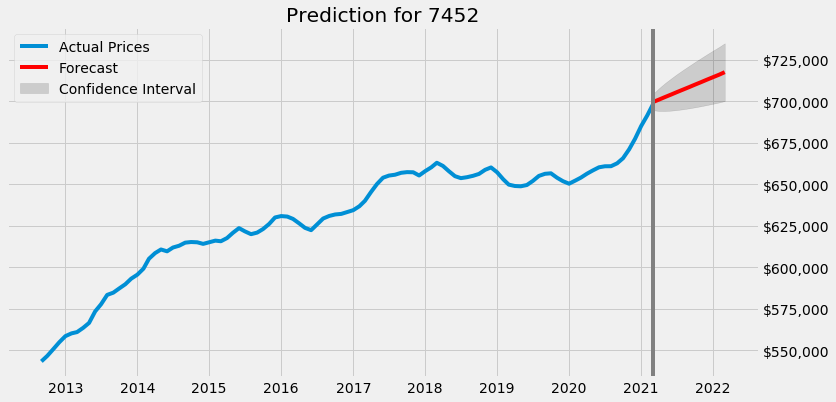






Building model for 7417
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=2015.419, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=2037.517, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=2094.735, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2130.729, Time=0.21 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=2173.798, Time=0.15 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=2199.445, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=2152.531, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=2042.921, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=2143.461, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2226.498, Time=0.24 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=2222.315, Time=0.45 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=2154.932, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=2119.084, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=2140.106, Time=0.26 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2247.

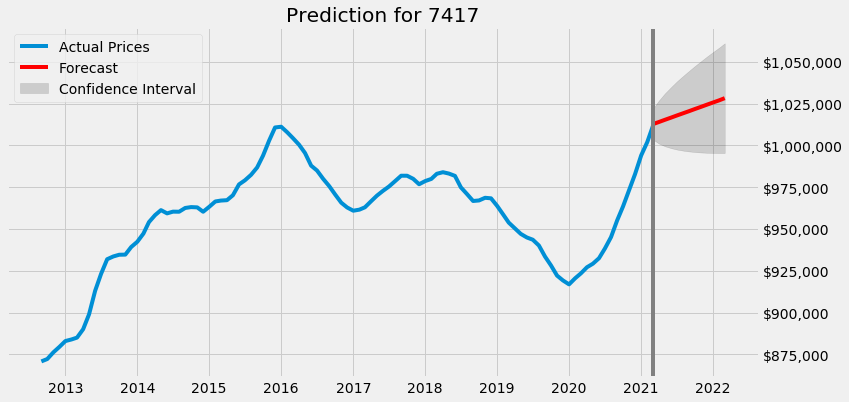






Building model for 7657
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1842.432, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1868.792, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1888.522, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1897.855, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1871.096, Time=0.13 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1872.071, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1893.447, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1863.063, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1874.531, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1892.556, Time=0.17 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1873.383, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1852.789, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1870.958, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1842.754, Time=0.31 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1894.

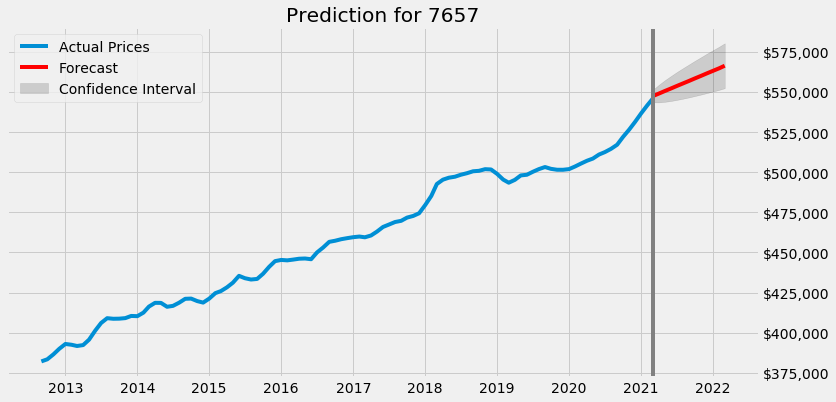






Building model for 7607
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1816.289, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1890.742, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1925.145, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1856.288, Time=0.18 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1894.989, Time=0.11 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1904.312, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1908.193, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1851.298, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1907.444, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1968.329, Time=0.13 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1913.893, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1908.076, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1853.489, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1873.589, Time=0.62 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1967.

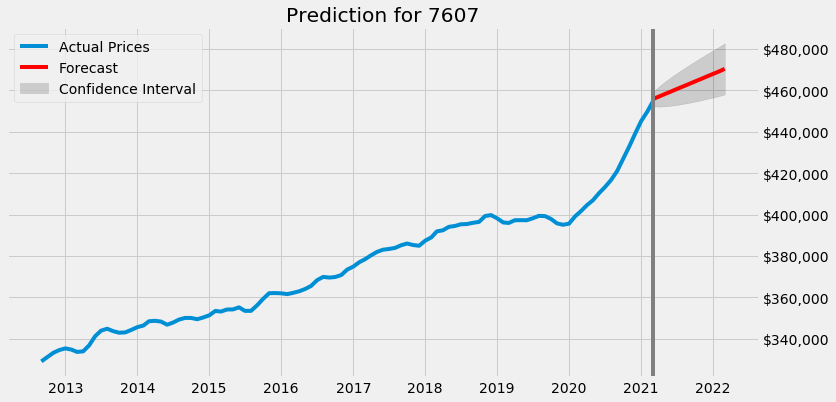






Building model for 7463
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1835.751, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1861.250, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1851.642, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1918.516, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1898.649, Time=0.09 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1901.571, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1883.311, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1846.611, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1890.973, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1849.851, Time=0.24 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1888.151, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1881.446, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1877.526, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1893.089, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1900.

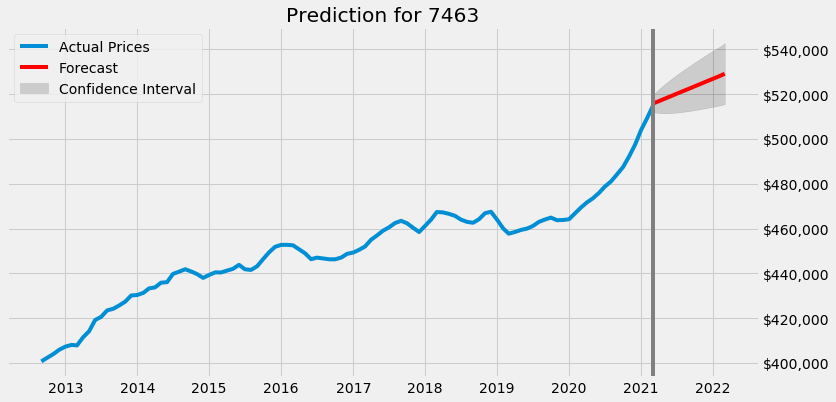






Building model for 7642
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1878.945, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1952.853, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1980.430, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1894.899, Time=0.26 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1983.321, Time=0.14 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1964.671, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1949.932, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1889.935, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1965.252, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1892.419, Time=0.50 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1966.915, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1892.490, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1985.997, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2009.426, 

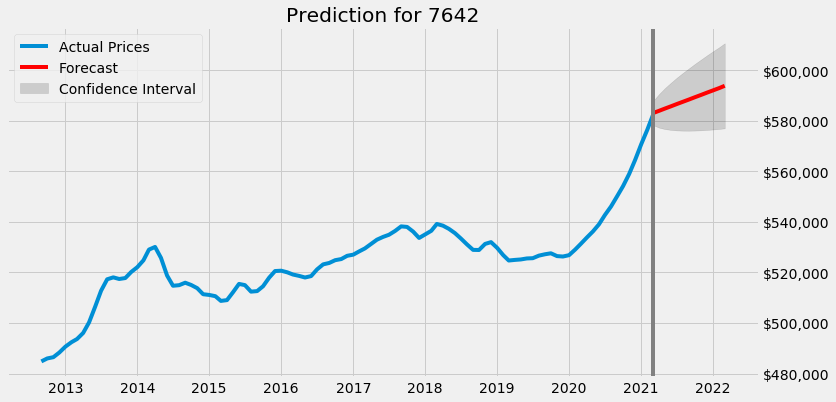






Building model for 7605
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1884.966, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1913.325, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1939.919, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1964.482, Time=0.12 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1952.851, Time=0.14 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1970.740, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1926.901, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1890.054, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1928.624, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1950.412, Time=0.18 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1940.115, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1934.515, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1891.948, Time=0.24 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1937.124, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1953.

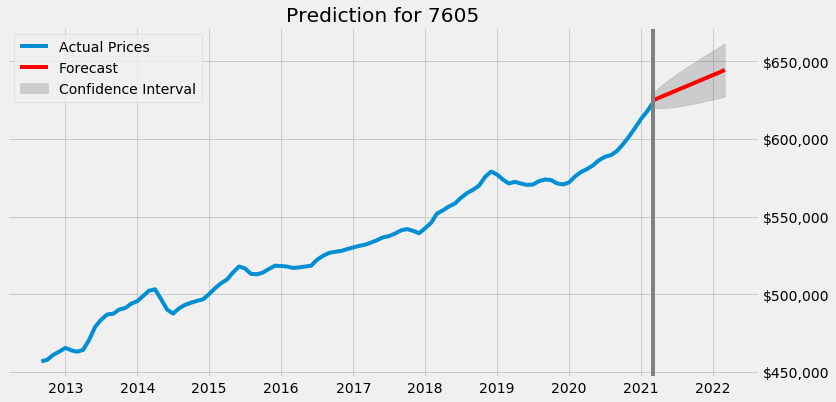






Building model for 7656
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1851.761, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1878.775, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1928.467, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1909.251, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1904.826, Time=0.25 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1932.885, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1934.870, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1862.222, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1919.306, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1932.733, Time=0.20 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1922.946, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1933.846, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1920.442, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1921.706, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, 

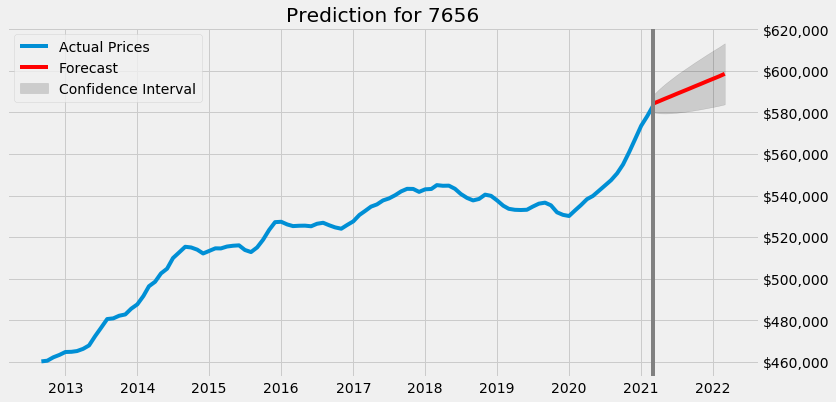






Building model for 7676
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1860.963, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1874.029, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1937.606, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1956.560, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1927.481, Time=0.14 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1942.660, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1874.003, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1881.408, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1918.842, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1872.955, Time=0.28 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1931.570, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1949.572, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1944.078, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1962.818, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1982.

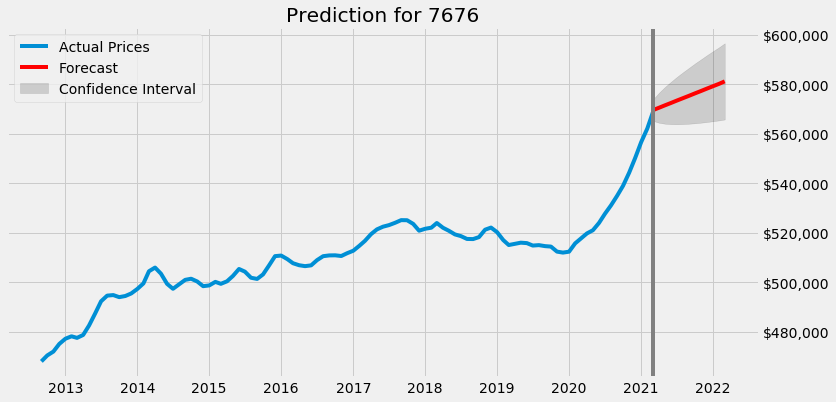






Building model for 7645
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1838.630, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1870.926, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1850.813, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1950.106, Time=0.16 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1931.042, Time=0.09 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1907.898, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1888.489, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1847.938, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1898.417, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1956.015, Time=0.20 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1926.838, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1899.090, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1893.170, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1854.282, Time=0.55 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1902.

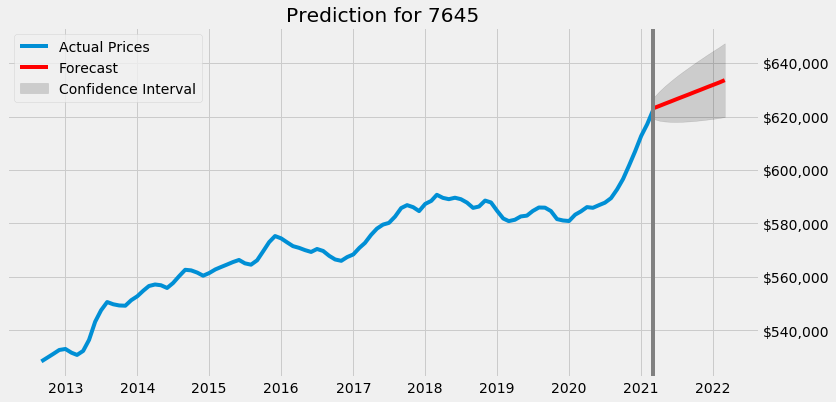






Building model for 7626
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1916.831, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1937.282, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1979.429, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2002.896, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1991.134, Time=0.14 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=2016.275, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1927.567, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1921.663, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1972.661, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1987.189, Time=0.23 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1926.464, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1978.984, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1950.063, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1974.793, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1985.

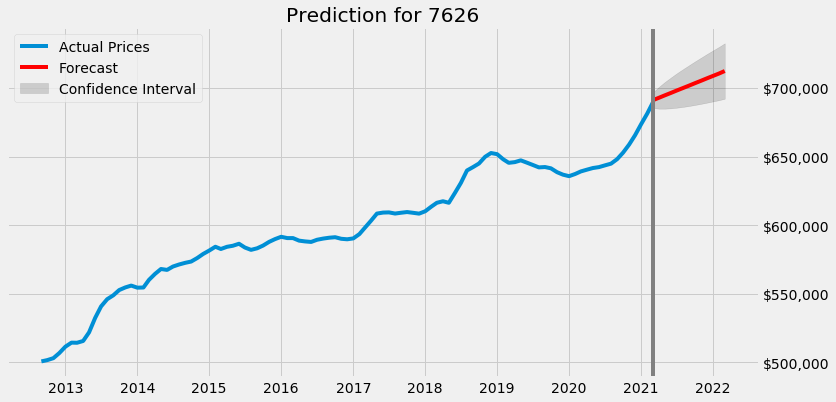






Building model for 7624
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1918.961, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1963.631, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=2002.416, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2007.630, Time=0.12 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=2004.846, Time=0.08 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=2017.675, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=2018.413, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1986.378, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1996.197, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2007.750, Time=0.22 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=2000.635, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=2020.457, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1990.380, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=2000.200, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2009.

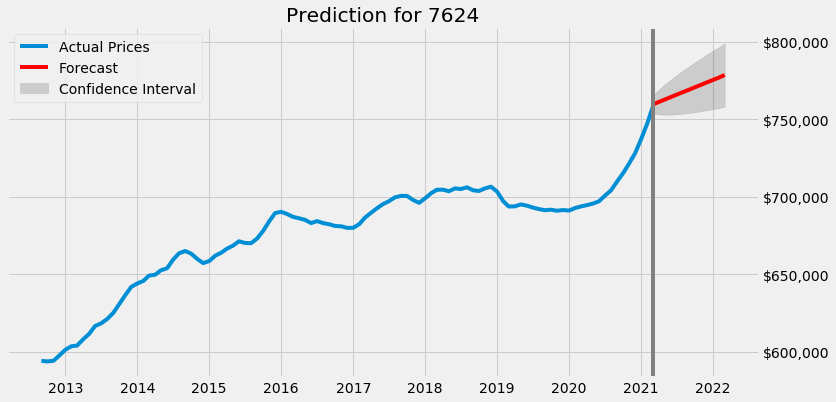






Building model for 7603
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1729.041, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1729.840, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1731.677, Time=0.06 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1739.221, Time=0.07 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1734.874, Time=0.09 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1735.252, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1729.842, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1733.103, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1733.625, Time=0.08 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1741.821, Time=0.08 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1747.406, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1731.761, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1738.223, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=1735.615, Time=0.17 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=1744.

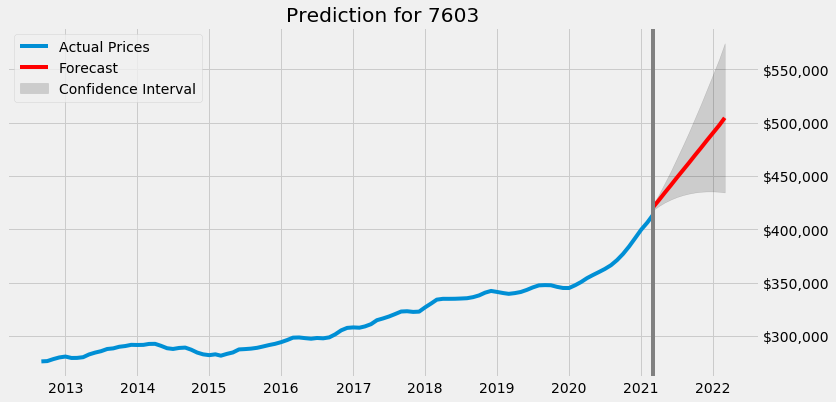






Building model for 7649
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1914.825, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1936.170, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1985.781, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1926.045, Time=0.27 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1982.996, Time=0.23 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1980.042, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1976.871, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1918.471, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1978.147, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1928.709, Time=0.37 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1979.391, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1984.309, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1966.906, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1981.197, Time=0.57 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2020.

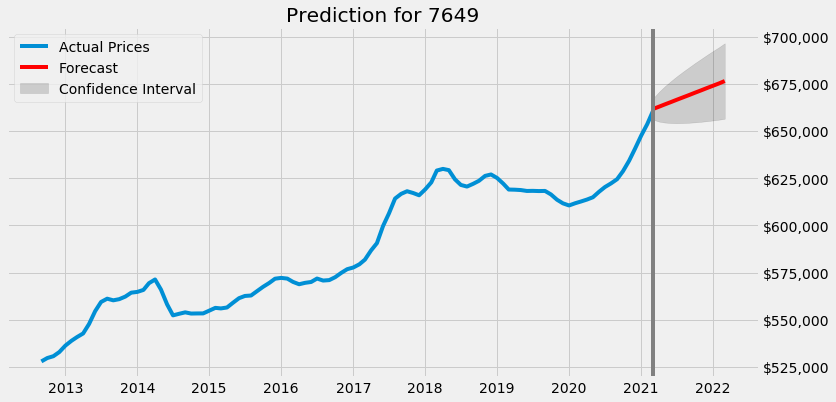






Building model for 7432
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1835.958, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1872.533, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1912.300, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1922.695, Time=0.58 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1913.191, Time=0.12 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1908.492, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1850.798, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1847.812, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1899.040, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1921.432, Time=0.15 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1904.108, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1904.322, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1887.966, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1902.812, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1922.

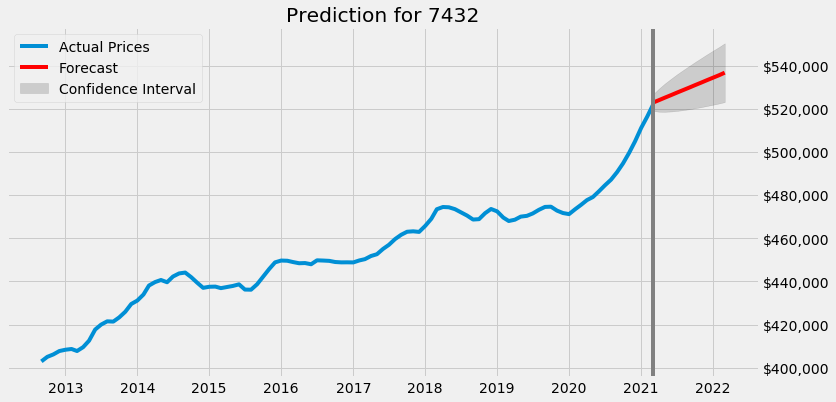






Building model for 7630
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1837.216, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1896.190, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1952.956, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1966.081, Time=0.12 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1895.942, Time=0.20 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1913.399, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1937.992, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1895.613, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1868.114, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2021.236, Time=0.21 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1944.548, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1932.155, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1926.332, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1886.132, 

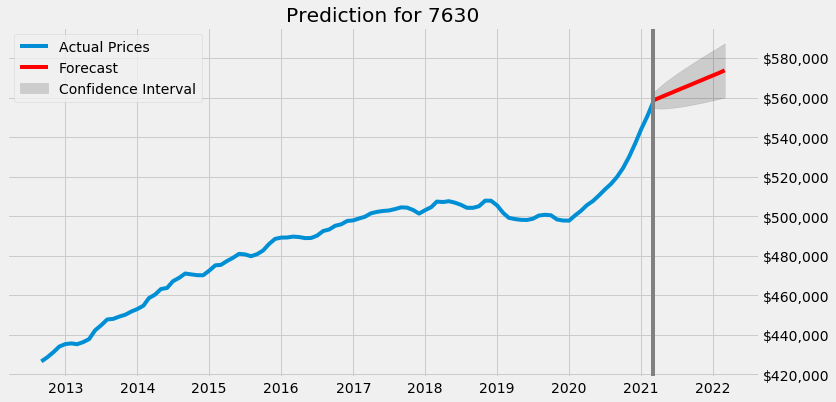






Building model for 7401
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1908.034, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1936.443, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1993.378, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2016.856, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=2039.759, Time=0.17 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=2009.188, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1970.886, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1917.557, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1982.013, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1999.218, Time=0.22 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=2023.482, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1971.881, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1952.855, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=

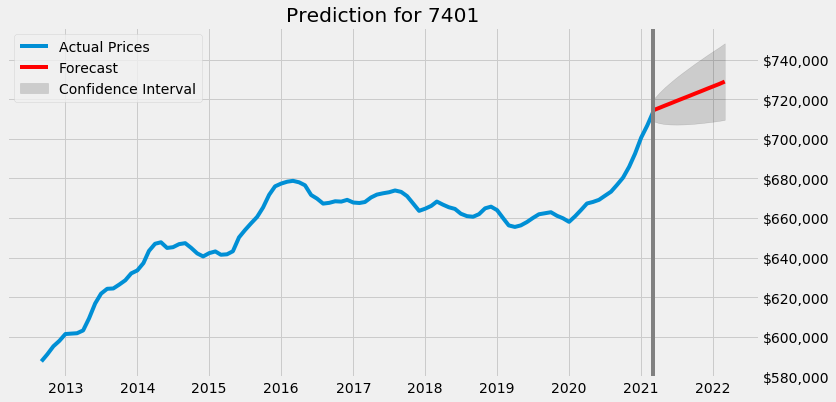






Building model for 7662
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1693.952, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1695.941, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1696.932, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1700.833, Time=0.09 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1701.265, Time=0.21 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1702.395, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1696.134, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1697.356, Time=0.36 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1698.978, Time=0.07 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1702.996, Time=0.06 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1703.820, Time=0.23 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1696.807, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1701.481, Time=0.11 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=1700.256, Time=0.14 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=1704.

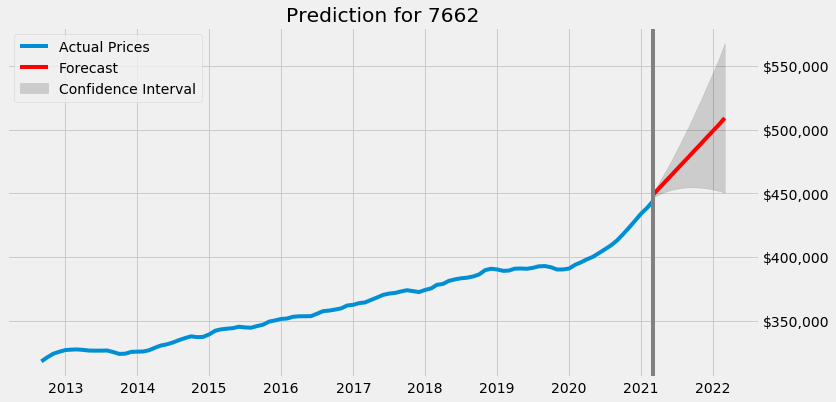






Building model for 7072
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1776.542, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1778.213, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1777.415, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1781.692, Time=0.07 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1781.284, Time=0.13 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1783.171, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1777.396, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1781.751, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1779.601, Time=0.19 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1785.846, Time=0.07 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1788.364, Time=0.25 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1777.102, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1782.666, Time=0.09 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=1782.475, Time=0.27 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=1793.

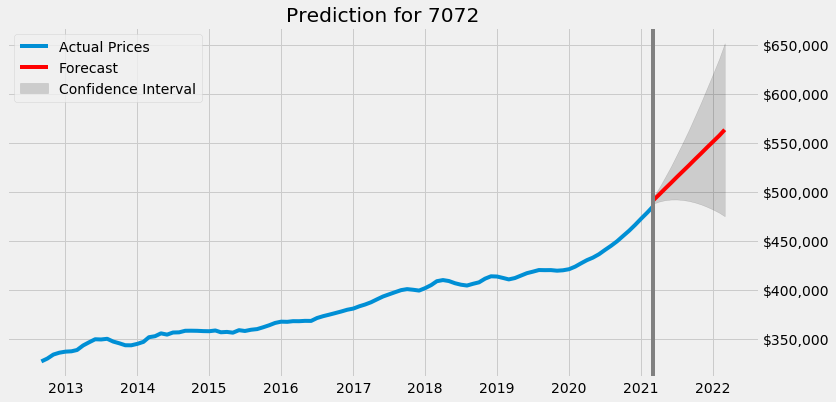






Building model for 7677
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1905.417, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1931.049, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1960.755, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1976.760, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1947.289, Time=0.13 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1967.135, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1958.907, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1912.258, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1949.440, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1979.014, Time=0.25 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1957.983, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1962.086, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1944.442, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1953.441, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1975.

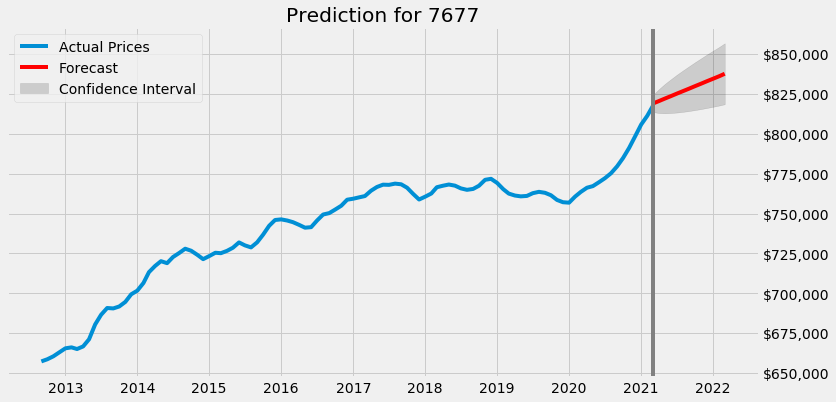






Building model for 7648
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1889.454, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1948.298, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=2004.974, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1999.740, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1940.085, Time=0.17 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1952.286, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1976.533, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1896.963, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1903.311, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2004.030, Time=0.31 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1929.266, Time=0.74 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1907.329, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1994.356, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1996.804, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2017.

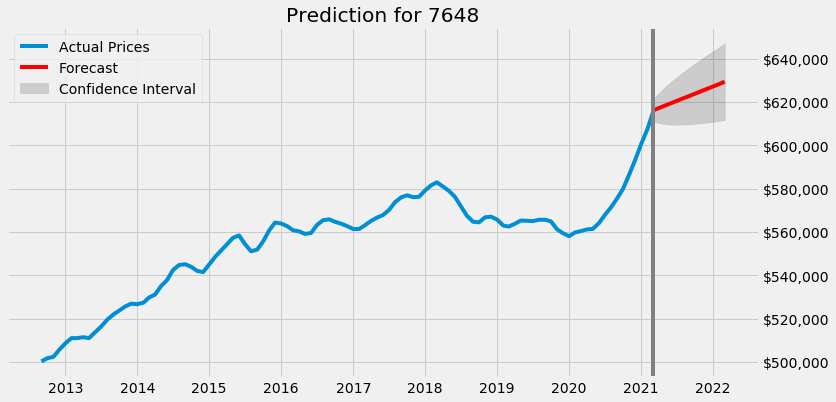






Building model for 7632
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1979.819, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1979.888, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1981.806, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1983.651, Time=0.06 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1981.708, Time=0.21 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1979.580, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1980.154, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1985.737, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1983.798, Time=0.10 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1980.420, Time=0.16 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1982.645, Time=0.30 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1982.201, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1987.402, Time=0.16 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=1980.658, Time=0.12 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=1984.

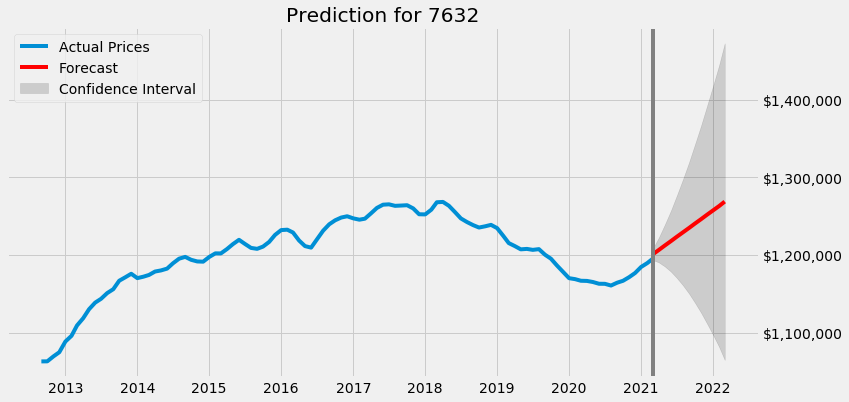






Building model for 7647
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1832.154, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1856.699, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1901.077, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1901.819, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1863.862, Time=0.18 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1866.390, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1843.844, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1839.449, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1883.861, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1903.938, Time=0.20 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1881.395, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1898.378, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1888.385, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1886.608, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1911.

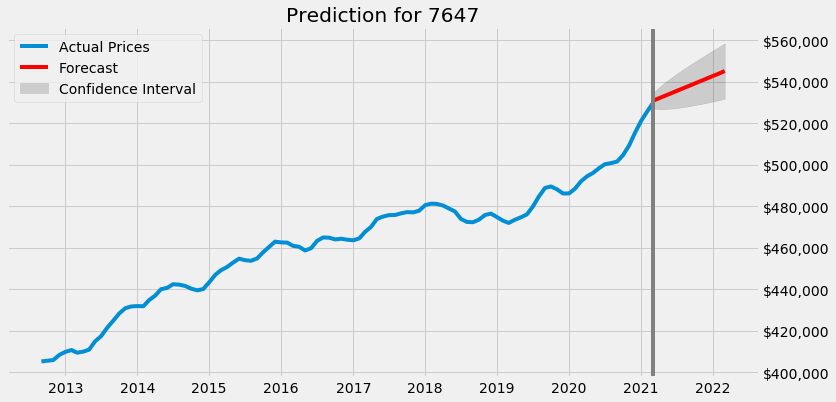






Building model for 7627
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1965.675, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1994.748, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=2048.567, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2049.832, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=2025.186, Time=0.18 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=2038.294, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=2047.802, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1985.041, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1963.740, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2077.645, Time=0.42 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=2043.620, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=2070.084, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=2048.172, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=2063.983, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2097.

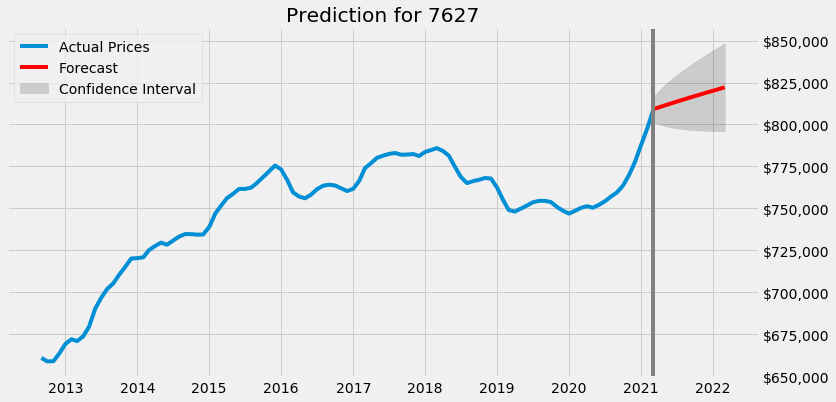






Building model for 7640
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1883.395, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1935.861, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1989.690, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2022.568, Time=0.19 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1955.862, Time=0.14 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1948.485, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1899.644, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1903.465, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1960.708, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1976.910, Time=0.27 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1936.791, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1971.462, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1949.079, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=

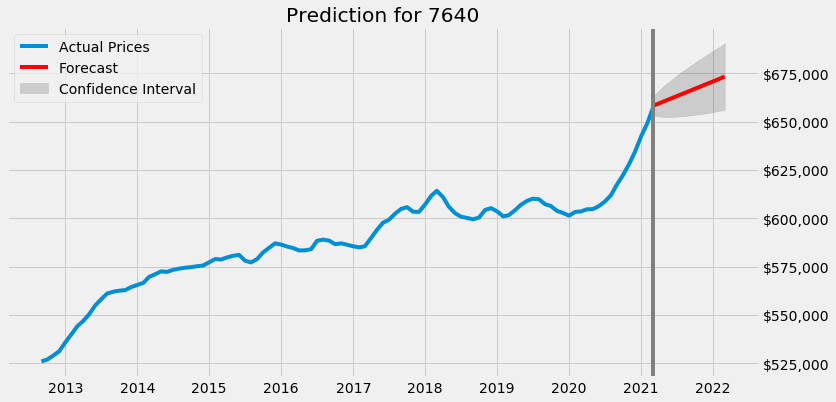






Building model for 7423
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1940.008, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1955.069, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1999.252, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1996.547, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1967.466, Time=0.15 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1991.312, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=2013.126, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1935.854, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1942.738, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2008.299, Time=0.23 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1985.959, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=2006.451, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1985.474, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1998.235, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, 

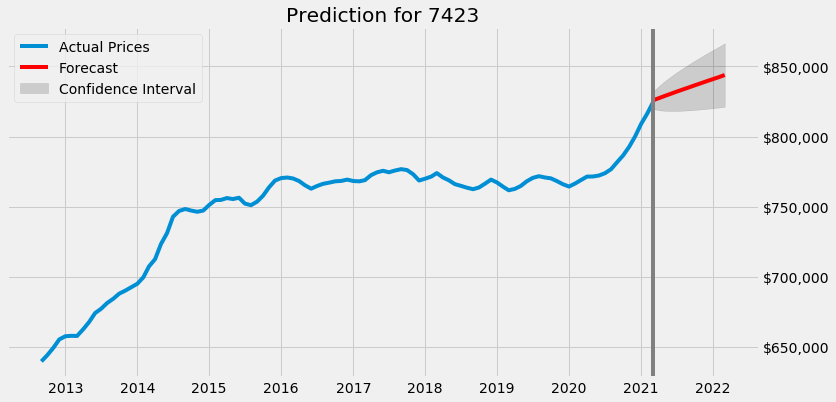






Building model for 7641
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1907.731, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1925.844, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=2002.771, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2002.696, Time=0.23 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=2005.488, Time=0.11 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=2032.544, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=2030.457, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1994.970, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=2002.046, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1997.297, Time=0.15 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1998.696, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=2029.616, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=2004.555, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=

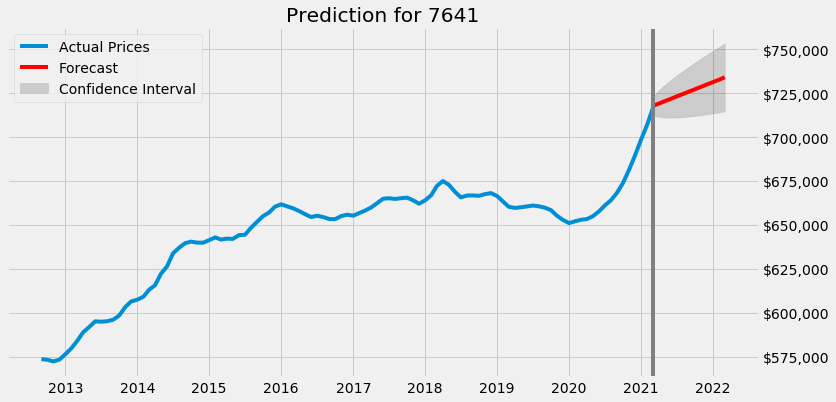






Building model for 7074
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1741.308, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1743.810, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1745.481, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1750.163, Time=0.07 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1749.185, Time=0.15 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1750.698, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1743.640, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1746.528, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1747.497, Time=0.05 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1752.346, Time=0.10 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1752.859, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1745.636, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1750.052, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=1749.442, Time=0.06 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=1751.

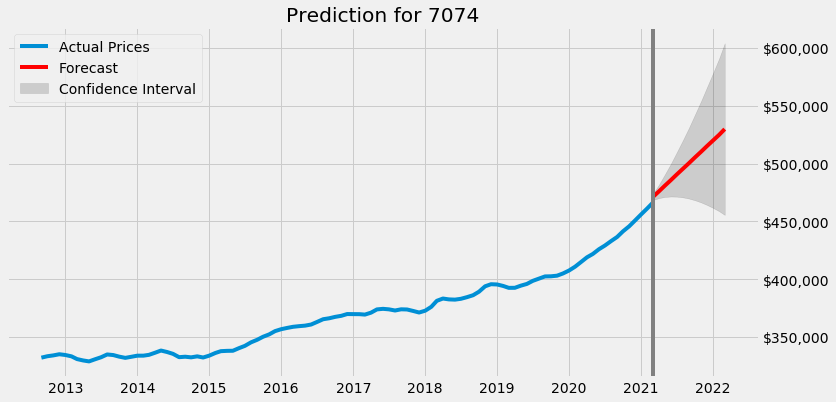






Building model for 7606
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1756.725, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1759.076, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1760.241, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1763.087, Time=0.13 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1762.675, Time=0.09 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1763.454, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1759.012, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1761.530, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=1762.218, Time=0.07 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1764.842, Time=0.14 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=1764.963, Time=0.24 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1760.060, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=1766.651, Time=0.08 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=inf, Time=0.33 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=inf, Time=

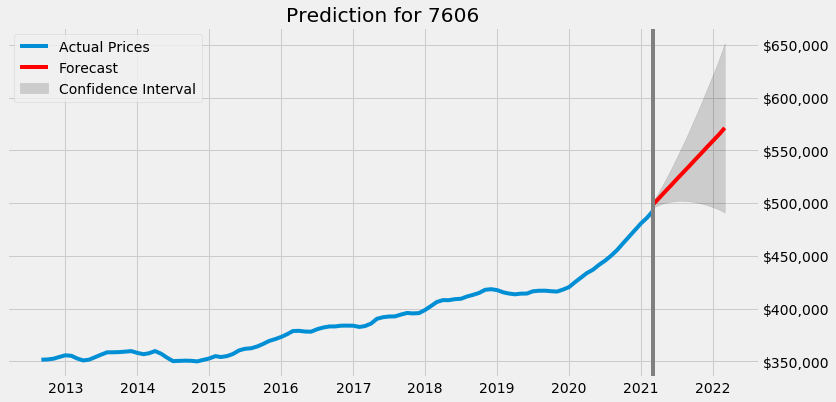






Building model for 7620
 ARIMA(0,2,0)(0,0,0)[1]             : AIC=2201.010, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=2202.970, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=2204.728, Time=0.09 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=2212.003, Time=0.31 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=2208.906, Time=0.17 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=2211.142, Time=0.22 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=2202.991, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=2204.820, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=2206.248, Time=0.16 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=2214.930, Time=0.22 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=inf, Time=0.68 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=2204.945, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=2209.698, Time=0.25 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=inf, Time=0.47 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=2187.086, Time=

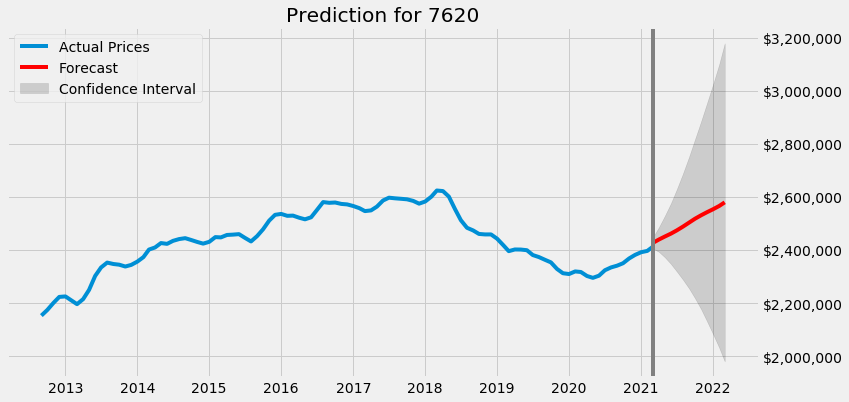






Building model for mean
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1840.085, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1899.951, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1938.605, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1950.402, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1888.772, Time=0.11 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1905.849, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1859.096, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1897.156, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1915.708, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1990.570, Time=0.18 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1926.090, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1947.517, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1856.109, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1927.080, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1995.

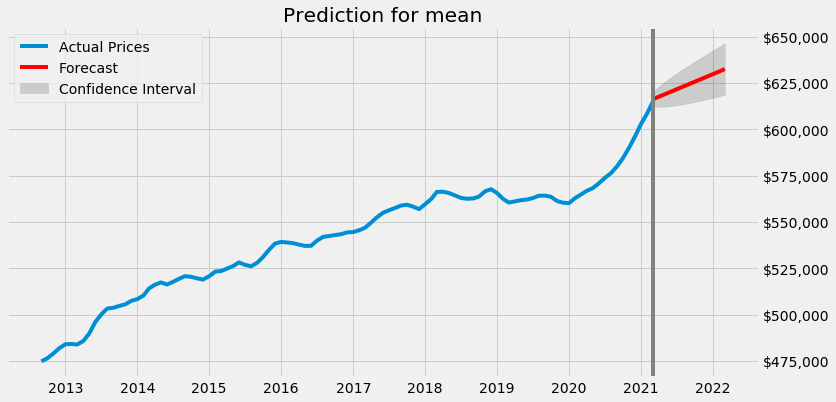

In [92]:
AIC, MAE, price, history, growth_pred, lower_confint, upper_confint = model_zips(df_more_zips)

In [93]:
df_more_eval = eval_zips(more_zips)
df_more_eval.sort_values(by=['History','Pred %'], 
                        ascending=False).style.format({'AIC':'{:,.2f}',
                                                       'MAE':'{:,.2f}',
                                                       'Price':'${:,.2f}',
                                                       'History':'{:,.2f}%',
                                                       'Pred %':'{:,.2f}%',
                                                       'Lower':'{:,.2f}%',
                                                       'Higher':'{:,.2f}%'
                                                       }).background_gradient(cmap=cm)

# Results

In [94]:
# subset values that are above mean values

df_more_select = df_more_eval[(df_more_eval['History'] > df_more_eval.iloc[65]['History']) &  # better than avg historical performance
                              (df_more_eval['Pred %'] > df_more_eval.iloc[65]['Pred %']) & # better than avg predicted growth
                              (df_more_eval['AIC'] < df_more_eval.iloc[65]['AIC']) & # better than avg AIC score
                              (df_more_eval['MAE'] < df_more_eval.iloc[65]['MAE']) & # better than avg MAE
                              (df_more_eval['Pred %'] > 10)] # prediction is greater than 10%

df_more_select.sort_values(by=['History','Pred %'], 
                        ascending=False).style.format({'AIC':'{:,.2f}',
                                                       'MAE':'{:,.2f}',
                                                       'Price':'${:,.2f}',
                                                       'History':'{:,.2f}%',
                                                       'Pred %':'{:,.2f}%',
                                                       'Lower':'{:,.2f}%',
                                                       'Higher':'{:,.2f}%'
                                                       }).background_gradient(cmap=cm)

Based on these results we would select:
1. East Rutherford - 16.35%
2. Garfield - 18.99%
3. Ridgefield Park - 20.02%
4. Hackensack - 15.41%
5. Bogota - 22.06%

We set out to create a tool that can be utilized by first time home buyers (FTHBs) to have an understanding of growth potential of various zipcodes that they are in interested in when looking for homes. In addition to other essential factors, such a tool would allow FTHBs to include the 'investment' aspect in their decision making process.

For time series - there are many metrics we can use too evaluate the models. We focused on the auto-ARIMA implementation from [pmdarima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima). To select the best model, the Akaike information criterion (AIC) is minimized. AIC is a mathematical method for evaluating how well a model fits the data it was generated from and is especially useful in comparing two models. 

We created a separate ARIMA model for each zip code and added metrics and information for each to a dataframe for comparison. Using the mean as a baseline we filtered the zipcodes based on a few factors:
- Historical performance is higher than average
- The predicted growth is higher than average
- The AIC score is less than (better than) the average AIC score
- The MAE of the validation set is less than the average MAE
- The predicted growth is greater than 10%

We then sorted the dataframe by historical growth. The reason for this is because this is an established value that we know to be true. Based on all of these factors, we can now select the top 5 cities as our recommendation for zip codes to invest in.

# Conclusion

As a First Time Homebuyer myself, I believe there is great value in a tool such as what we have created the backbone for. Price is an interesting and simple aggregate of many factors that influence the profitablity of homes in a given zip code. A time series model is a powerful way to utilize this important predictor to empower First Time Home Buyers who often get lost in many details. There are many elements of homebuying, if viewed as investment, would be extremely financially beneficial for FTHs. This applies to the home search process as well as the financing of the purchase. Fine-tuning and providing a tool like the above would be an important enabling and equipping value that a Real Estate Agency (such ACME) could provide it's clients. 

This ARIMA model has been automatically tuned for best parameters. As described below, we think exploring more complex models and datasets could inform this early iteration of the prediction tool. Also the year 2020 and 2021 have been vastly different than the previous decade leading up to it, to the point of some claiming we are in a bubble. There are many factors contributing to the high prices which make modeling a time series somewhat restrictive. It may be beneficial to validate on other similar historical time frames. Also, any predicitons must be taken with a grain of salt as prices simply cannot go up forever, as any model that weighs the recent past may predict. We think further work must be done before this model can be ready for regular use. 

# Future Work

There are multiple areas of potential future work:

1. Design a proprietary scoring model that takes the various relevant factors into account
2. Explore other house pricing datasets and modeling packages such as Facebook Prophet 
3. Build a GUI where users can select desired zipcodes from a map to feed into the model and return results

# Plots for Presentation

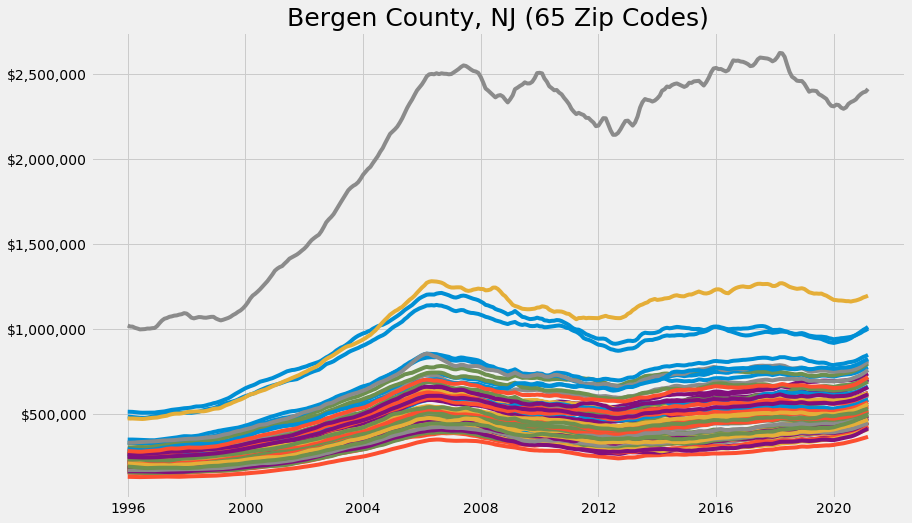

In [95]:
fig, ax = plt.subplots(figsize=(13,8))
ax.plot(df_more_zips_full)

ax.title.set_text('Bergen County, NJ (65 Zip Codes)')
ax.title.set_size(25)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

plt.legend('',frameon=False);

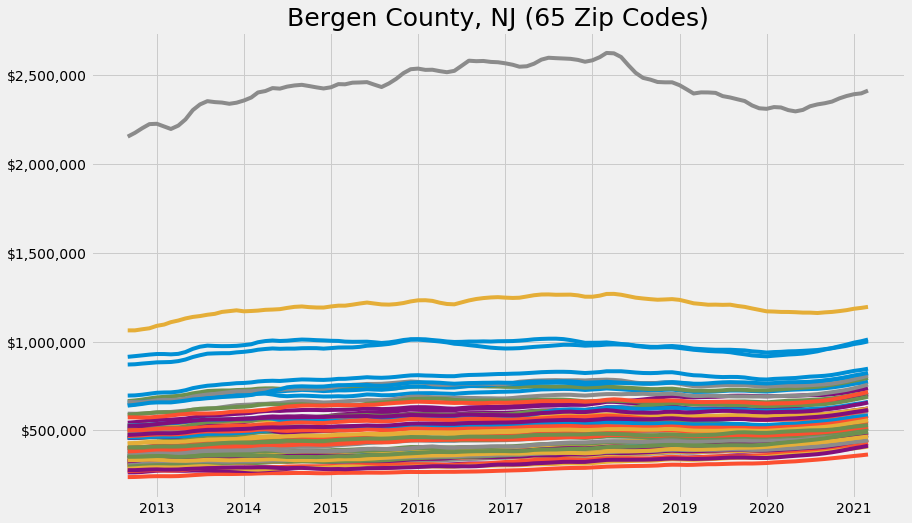

In [96]:
fig, ax = plt.subplots(figsize=(13,8))
ax.plot(df_more_zips)

ax.title.set_text('Bergen County, NJ (65 Zip Codes)')
ax.title.set_size(25)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

plt.legend('',frameon=False);